# 2025 Data-Driven Driver Rankings

The goal of this notebook is to create an objective driver ranking, based on data.

## Methodology

We will use features generated from F1 data and create a normalization algorithm to process each feature category, creating a hypothetical score for each driver in each feature category.

I will explain everything below as I proceed, which should make things much clearer.

In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

pd.set_option('display.max_columns', None)

In [59]:
# change path for local imports

if not (Path.cwd() / 'src').exists():
    project_root = Path.cwd().parents[1]
    os.chdir(project_root)
    print(f"Diretório alterado para: {Path.cwd()}")
else:
    print(f"Já estamos na raiz do projeto: {Path.cwd()}")

Já estamos na raiz do projeto: b:\projetos\f1_analytics


In [60]:
from src.analysis.data_viz.plotter import *
from src.analysis.data_viz.constants import TEAM_COLORS
from src.analysis.data_viz.constants import JOLPICA_CONSTRUCTOR_RENAME
import notebooks.f1_2025_data_rankings.utils as nb_utils # helpers for this specific notebook
from src.analysis.utils.feature_normalizer import FeatureNormalizer

# Features and plan for them:

The analysis of the features in this notebook will consider the features to have some amount of validation (see feature_table_validation.ipynb for reference), and in this notebook I will dive deeper in the values produced in each feature for each driver. Explaining and revisiting each one of the features. And than, after, I will try to create a score/power ranking for each one of the drivers.

Also, all of the datasets have received previous data treatment to calculate the features appropriately. Check the extractor for each feature for more details.

The analysis will focus on the 2025 championship.

In [61]:
# Loading feature datasets:

pace_path = 'data/features/pace_features.csv'
perf_path = 'data/features/performance_features.csv'
exp_path = 'data/features/experience_features.csv'

df_pace = pd.read_csv(pace_path)
df_perf = pd.read_csv(perf_path)
df_exp = pd.read_csv(exp_path)

list_df_features = [df_pace, df_perf, df_exp]

# Data treatment useful for later

def clean_df(df):
    df = nb_utils.filter_year(df, 2025)
    return nb_utils.replace_constructors_names(df)

df_pace, df_perf, df_exp = [clean_df(p) for p in list_df_features]


b:\projetos\f1_analytics\notebooks\f1_2025_data_rankings\utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['constructor_name'] = df_features['constructor_name'].replace(JOLPICA_CONSTRUCTOR_RENAME)


# Pace features:

In [62]:
df_pace

driver_id  year       driver_full_name driver_surname constructor_name  \
332        763  2025        Fernando Alonso         Alonso     Aston Martin   
460        795  2025         Lewis Hamilton       Hamilton          Ferrari   
528        807  2025        Nico Hülkenberg     Hülkenberg           Sauber   
632        830  2025           Carlos Sainz          Sainz         Williams   
643        831  2025         Max Verstappen     Verstappen         Red Bull   
661        838  2025           Esteban Ocon           Ocon             Haas   
673        840  2025           Lance Stroll         Stroll     Aston Martin   
682        841  2025           Pierre Gasly          Gasly           Alpine   
692        843  2025        Charles Leclerc        Leclerc          Ferrari   
700        845  2025           Lando Norris         Norris          McLaren   
706        846  2025        Alexander Albon          Albon         Williams   
713        847  2025         George Russell        Russell         Mercedes   
721        851  2025           Yuki Tsunoda        Tsunoda         Red Bull   
733        857  2025          Oscar Piastri        Piastri          McLaren   
736        858  2025            Liam Lawson         Lawson            VCARB   
737        859  2025         Oliver Bearman        Bearman             Haas   
739        860  2025       Franco Colapinto      Colapinto           Alpine   
740        861  2025            Jack Doohan         Doohan           Alpine   
741        862  2025      Gabriel Bortoleto      Bortoleto           Sauber   
742        863  2025  Andrea Kimi Antonelli      Antonelli         Mercedes   
743        864  2025           Isack Hadjar         Hadjar            VCARB   

     avg_pace_vs_field  avg_pace_vs_teammate  avg_lap_time_std_dev_vs_field  \
332           1.001067              0.996977                       1.132184   
460           0.994950              1.004095                       0.920399   
528           1.004016              0.999390                       1.163217   
632           1.001073              1.002047                       0.930246   
643           0.989197              0.986488                       0.870101   
661           1.003274              1.001039                       1.036349   
673           1.004111              1.003052                       1.152193   
682           1.005062              0.999293                       1.069933   
692           0.990911              0.995954                       0.836841   
700           0.986219              0.999705                       0.857730   
706           0.999037              0.997988                       1.060487   
713           0.993418              0.996992                       0.824542   
721           1.002775              1.013794                       0.984863   
733           0.986521              1.000307                       0.858410   
736           1.002187              1.001558                       1.068566   
737           1.002249              0.998995                       1.208730   
739           1.006296              1.000252                       1.159259   
740           1.001739              1.004600                       1.265951   
741           1.004640              1.000636                       1.041961   
742           0.996432              1.003038                       0.933710   
743           1.000653              0.998489                       1.113047   

     avg_lap_time_std_dev_vs_teammate  avg_raw_lap_time_std_dev  \
332                          1.043929               1264.869173   
460                          1.153122               1082.251872   
528                          1.306893                983.630713   
632                          0.911361               1005.424836   
643                          1.012703               1047.093856   
661                          0.933262               1177.592150   
673                          1.060781               1146.9

In [63]:
list_pace_features = nb_utils.get_features_column_list(df_pace)
list_pace_features

['avg_pace_vs_field',
 'avg_pace_vs_teammate',
 'avg_lap_time_std_dev_vs_field',
 'avg_lap_time_std_dev_vs_teammate',
 'avg_raw_lap_time_std_dev',
 'avg_qualifying_gap_to_pole_pct',
 'avg_qualifying_gap_to_teammate_pct']

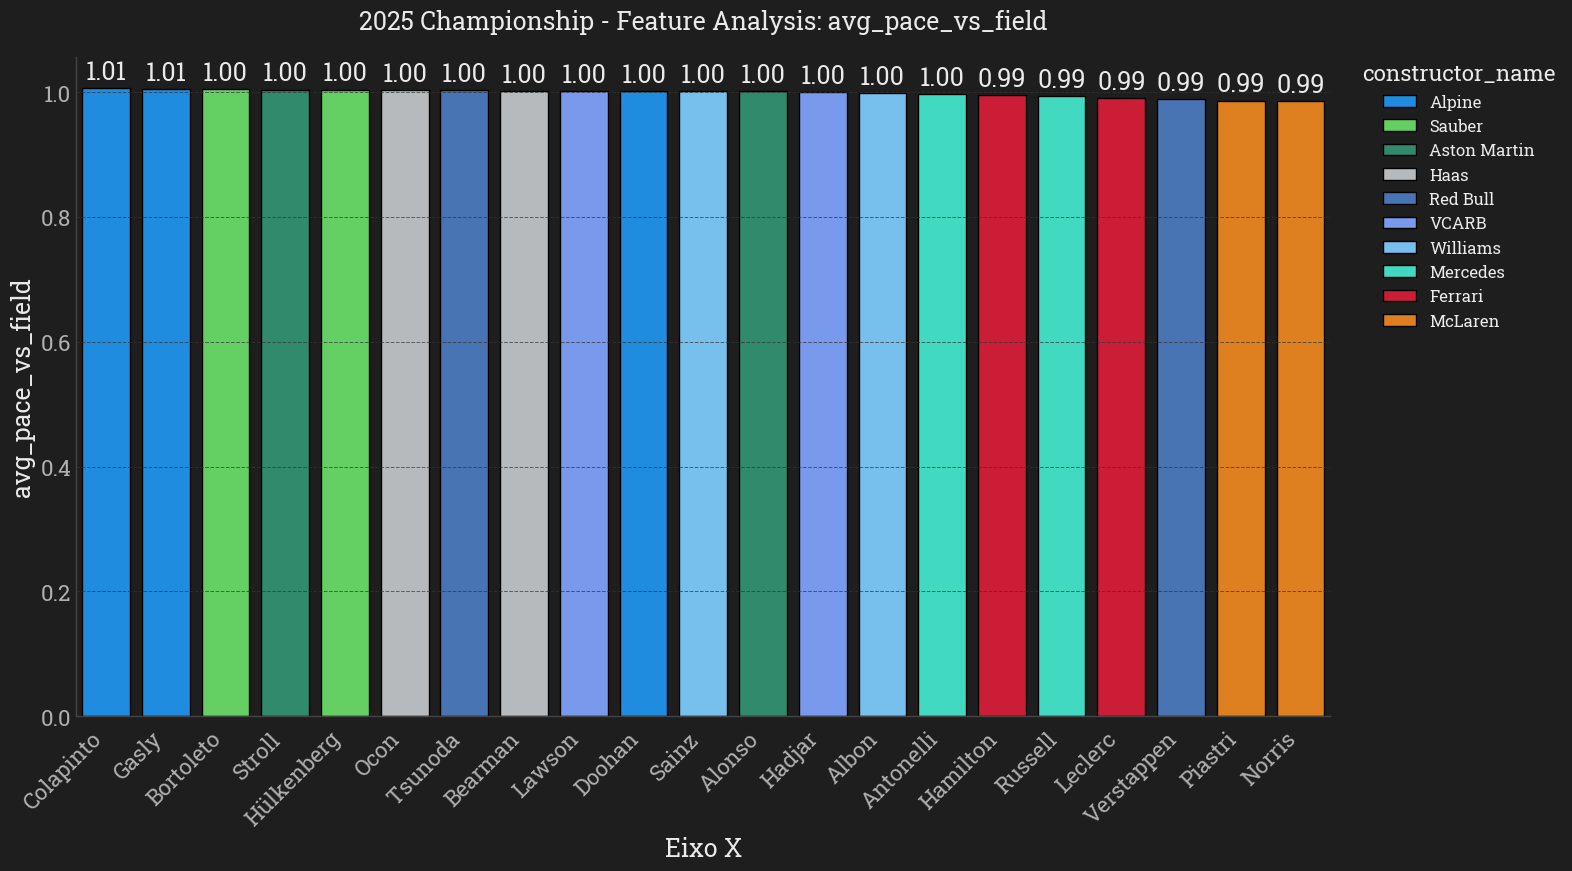

In [64]:
selected_feature = 'avg_pace_vs_field'

df_plot = df_pace.sort_values(by=selected_feature, ascending=False)

graf_barras_padrao(
    df_dados=df_plot,
    x_col='driver_surname',
    y_col=selected_feature,
    hue_col='constructor_name',
    cores_map=TEAM_COLORS,
    titulo=f'2025 Championship - Feature Analysis: {selected_feature}',
    ylabel=selected_feature,
    fmt_rotulo='%.2f'
)

The problem with what I'm showing above is that it is not really the best way to present this kind of value... The differences are really small and it doesn't really show how much the drivers are diverging from each other... Let's treat the features and then we will get back to analyzing them...

# Normalization/Score Creation

I've created a separate module to normalize the features so we can extract more information from visualizing them and then we can later add weights to each one of them and created a combined score for each feature "category".

## How the normalization works:

1- Apply Z-Score normalization to normalize using mean and std. dev., being a better normalization method to not distort the whole series if there are outliers

2- Apply min-max scaling so the numbers are better interpreted -> Here we will have a max value of 10 and a min value of 5 (elite baseline logic, since the analysis is based on comparison and not an actual test score, we are only comparing elite drivers).

So, now that I made this quick break to briefly explain the normalization technique. I will apply it to the feature analysis and we can both see the original value and than the normalized value and I will explain the feature as we go.

But before going ahead, I'm going to create a function below to make my life a little easier when analyzing each single feature.

In [65]:
def create_feature_norm_analysis(df_feature, feature, lower_is_better):

    '''
    Plots chart for feature analysis and returns original dataframe with normalized feature col added
    '''

    df = df_feature.copy()

    df_plot = df.sort_values(by=feature, ascending=False)

    graf_barras_padrao(
        df_dados=df_plot,
        x_col='driver_surname',
        y_col=feature,
        hue_col='constructor_name',
        cores_map=TEAM_COLORS,
        titulo=f'2025 Championship - Feature Analysis: {feature}',
        ylabel=feature,
        xlabel='Driver',
        fmt_rotulo='%.2f',
        show_legend=False
    )

    normalizer = FeatureNormalizer()

    df[f'{feature}_norm'] = normalizer.robust_normalize(df[feature], target_range=(5, 10), lower_is_better=lower_is_better).copy()
    df_plot = df.sort_values(by=feature, ascending=False)

    graf_barras_padrao(
        df_dados=df_plot,
        x_col='driver_surname',
        y_col=f'{feature}_norm',
        hue_col='constructor_name',
        cores_map=TEAM_COLORS,
        titulo=f'2025 Championship - Feature Analysis: {feature} Normalized',
        ylabel=f'{feature} Normalized',
        xlabel='Driver',
        fmt_rotulo='%.2f',
        show_legend=False
    )

    return df


# Going back to Pace Features

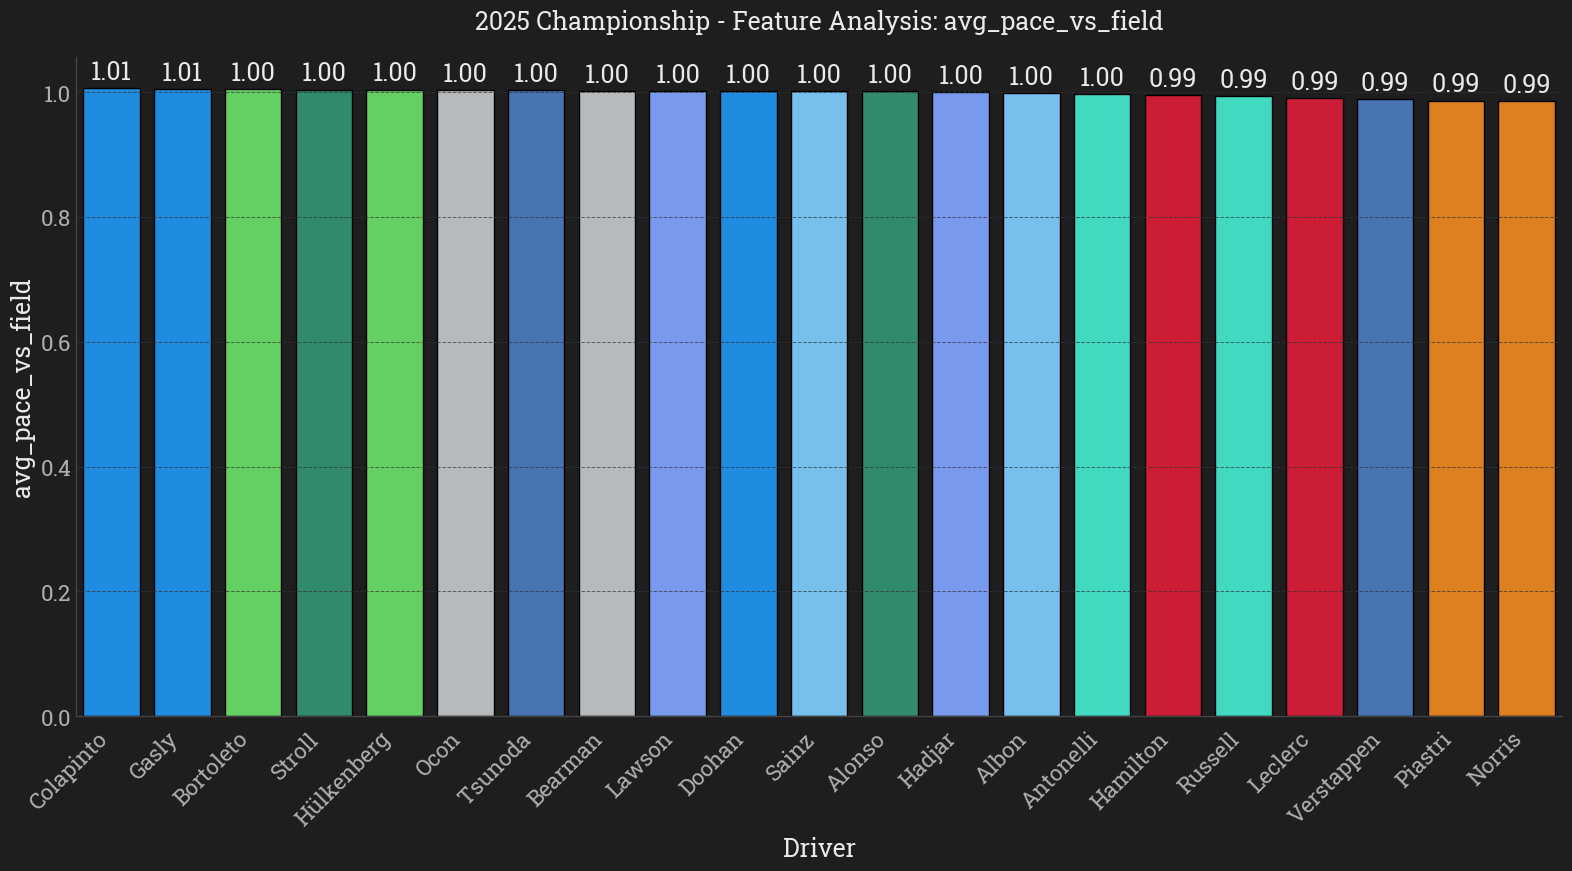

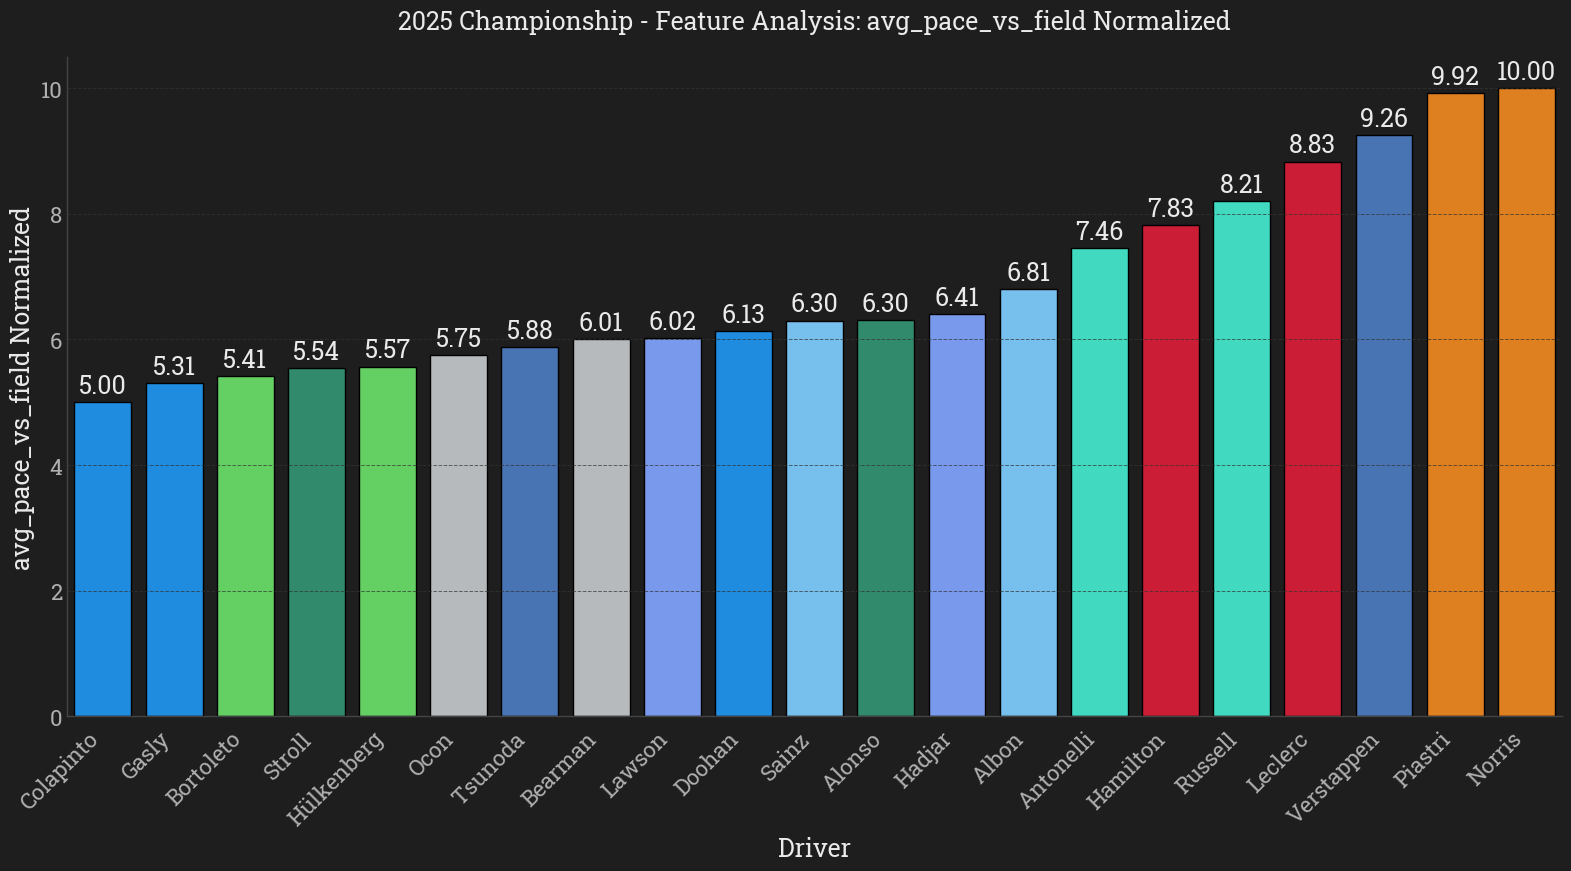

In [66]:
feature_index = 0

selected_feature = list_pace_features[feature_index]

df_pace = create_feature_norm_analysis(df_feature=df_pace, feature=selected_feature, lower_is_better=True)

feature_index += 1

This feature is generated by the following formula:
- For each race, the driver's median pace (pace is represented by the lap time) is calculated;
- The median pace of the field is calculated by getting the median value of the driver's median pace of the field;
- The driver's median pace is then divided by the median pace of the field to get the pace vs field. This calculation is still done in a race level;
- Then, I average the value for the whole year and get the final value for the driver.

So, at the end of the day, the feature in itself is a ratio of the driver's median pace to the median pace of the field. It could be interpreted as a percentage value of the driver's median pace relative to the median pace of the field. With lower values being better, since the pace is represented by the lap time, and lower lap times are better, obviously.

A driver with a pace vs field of 1.0 is the median of the field, while a driver with a pace vs field of 2.0 is twice the median pace of the field, and so on. And for every driver with a pace vs field lower than 1.0, it means that their pace is lower than the median pace of the field.

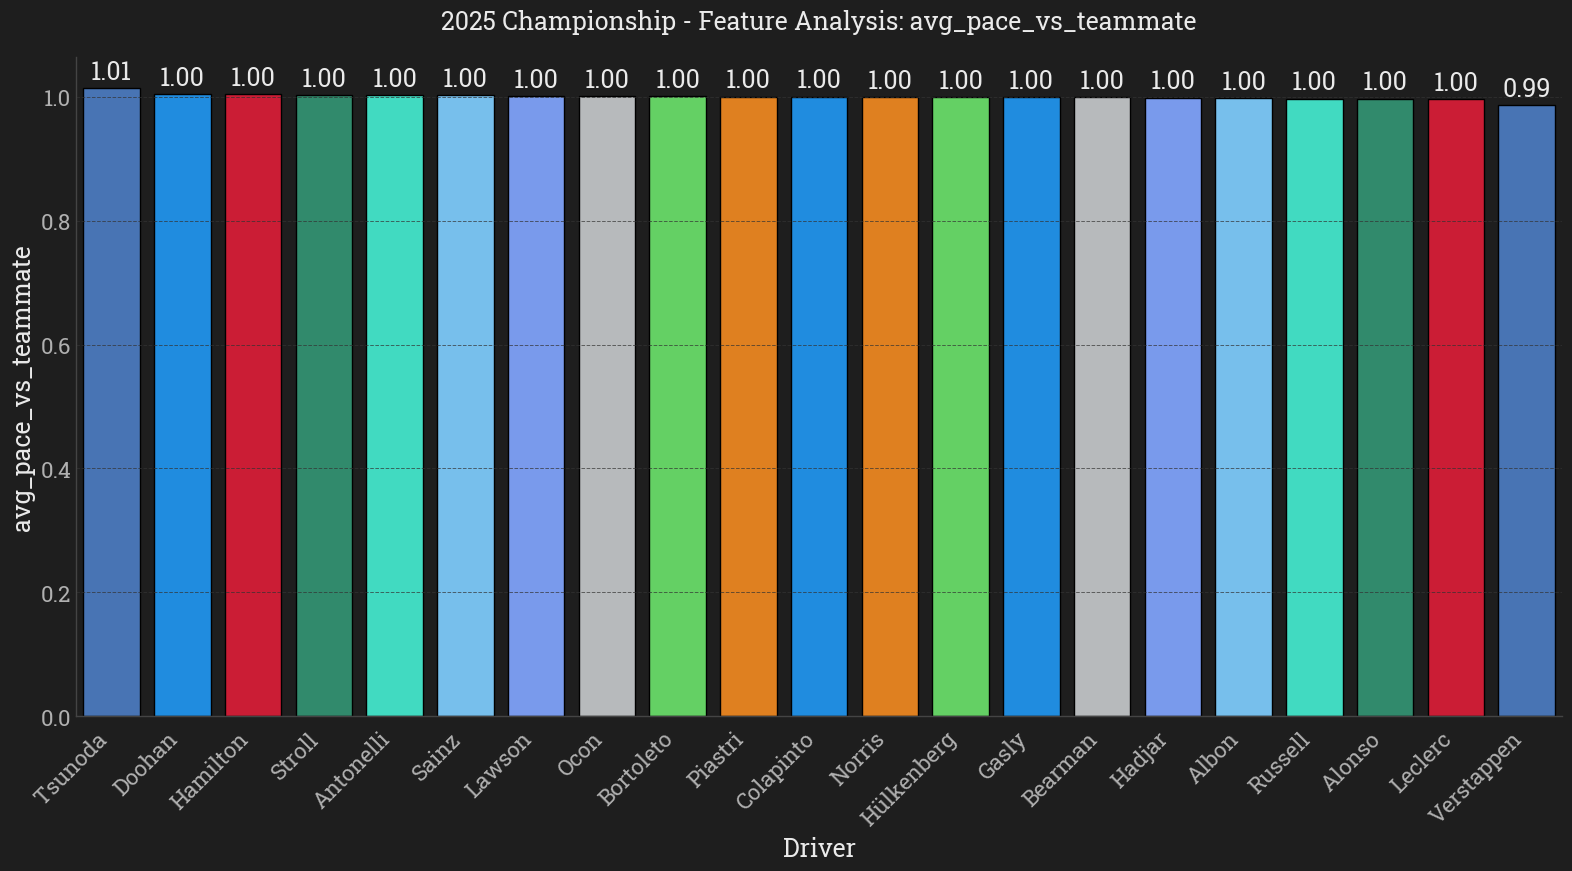

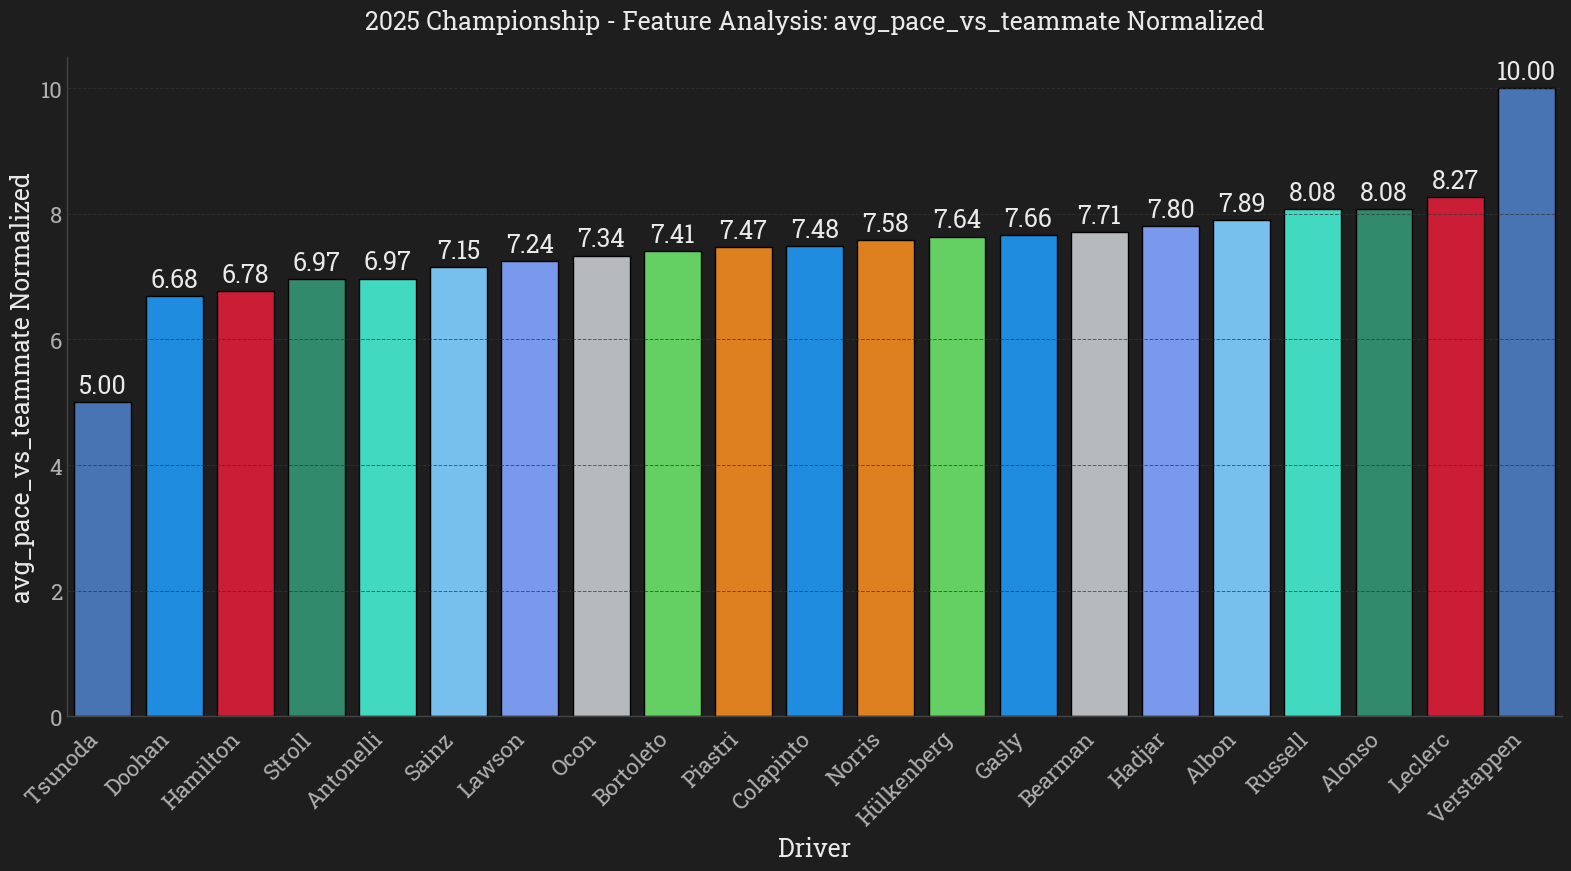

In [67]:
selected_feature = list_pace_features[feature_index]

df_pace = create_feature_norm_analysis(df_feature=df_pace, feature=selected_feature, lower_is_better=True)

feature_index += 1

This feature is calculated using pretty much the same logic as the previous one, but it compares the driver's median pace to his teammate's median pace instead of the whole field median pace.

We can see that, even though I used the z-score normalization to make outliers not affect the analysis by so much, it will still detect drivers that have a feature value that is far from the mean and give those drivers a high/low score. Just as we can see with Verstappen and Tsunoda on the chart above.

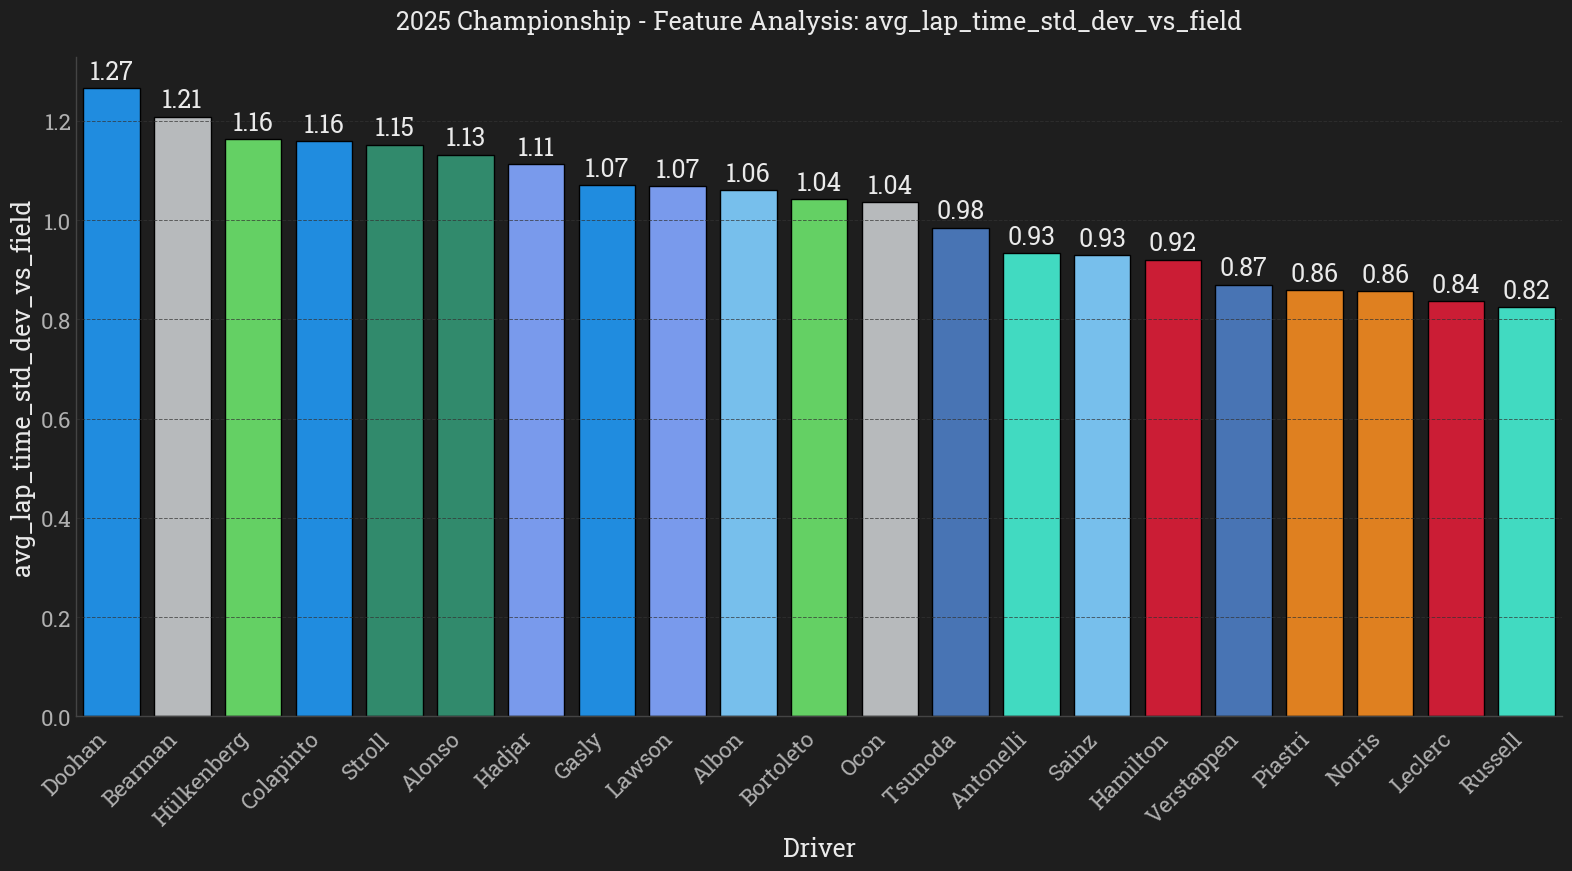

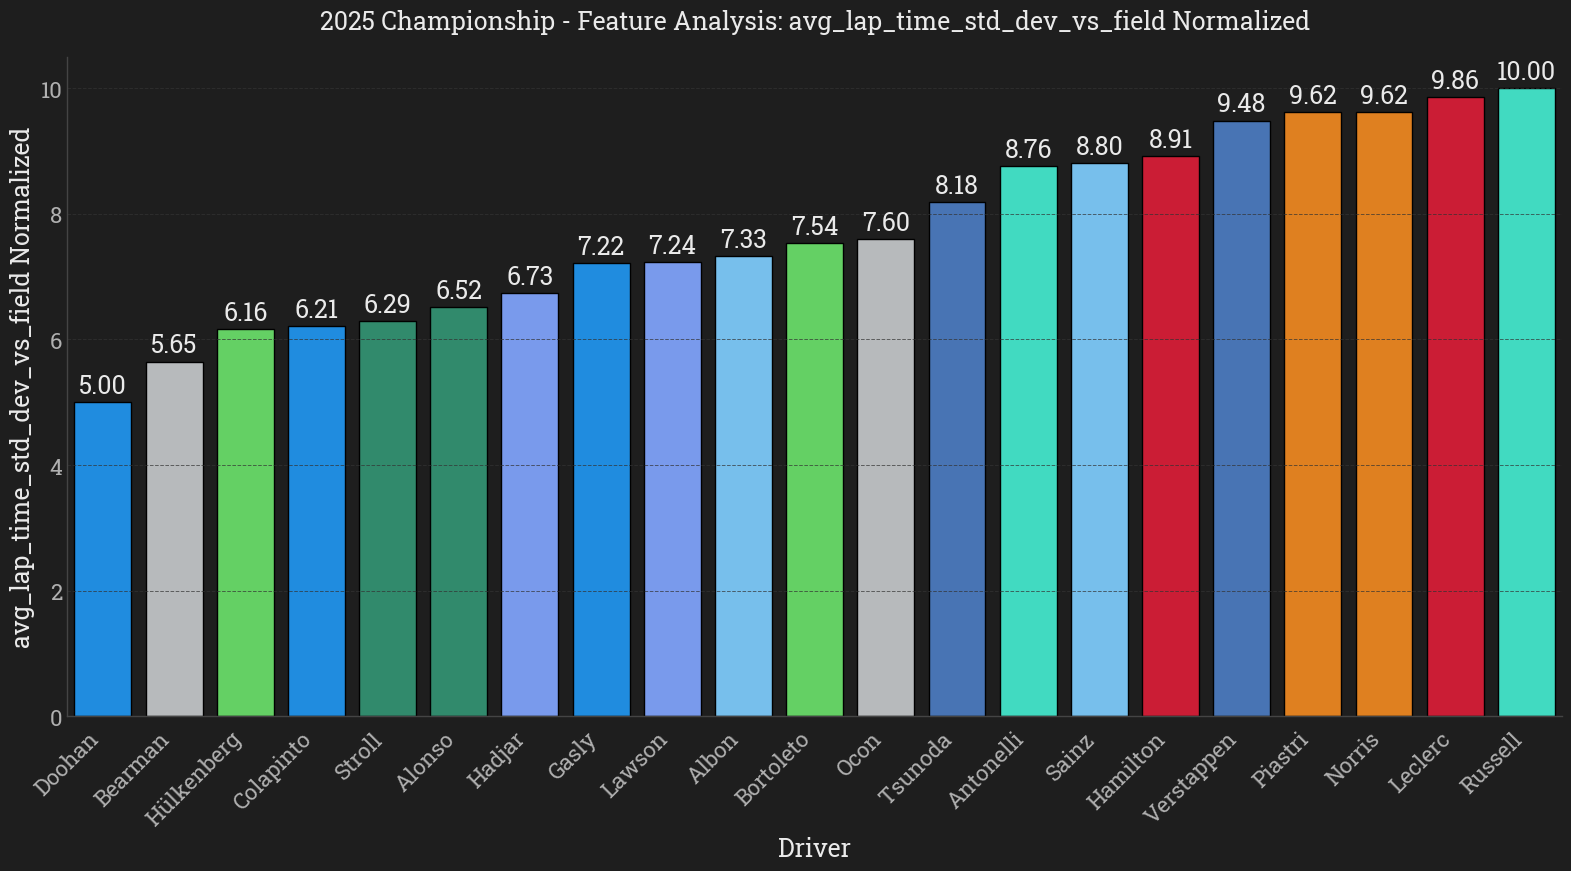

In [68]:
selected_feature = list_pace_features[feature_index]

df_pace = create_feature_norm_analysis(df_feature=df_pace, feature=selected_feature, lower_is_better=True)

feature_index += 1

The feature above is calculated using the following logic:

1. Calculate the standard deviation for every driver in every race stint, than average the value for all the stints in a race to get the standard deviation for each driver in each race;
2. Calculate the mean value for the above to get the standard deviation for each race;
3. Divide the driver's std. dev. by the race std. dev. to get the feature value for each race.
4. Average the value for each driver for the whole season to get the final feature value.

So, like the previous feature, this feature also represents a ration between values, which can also be interpreted as a percentage between the two.

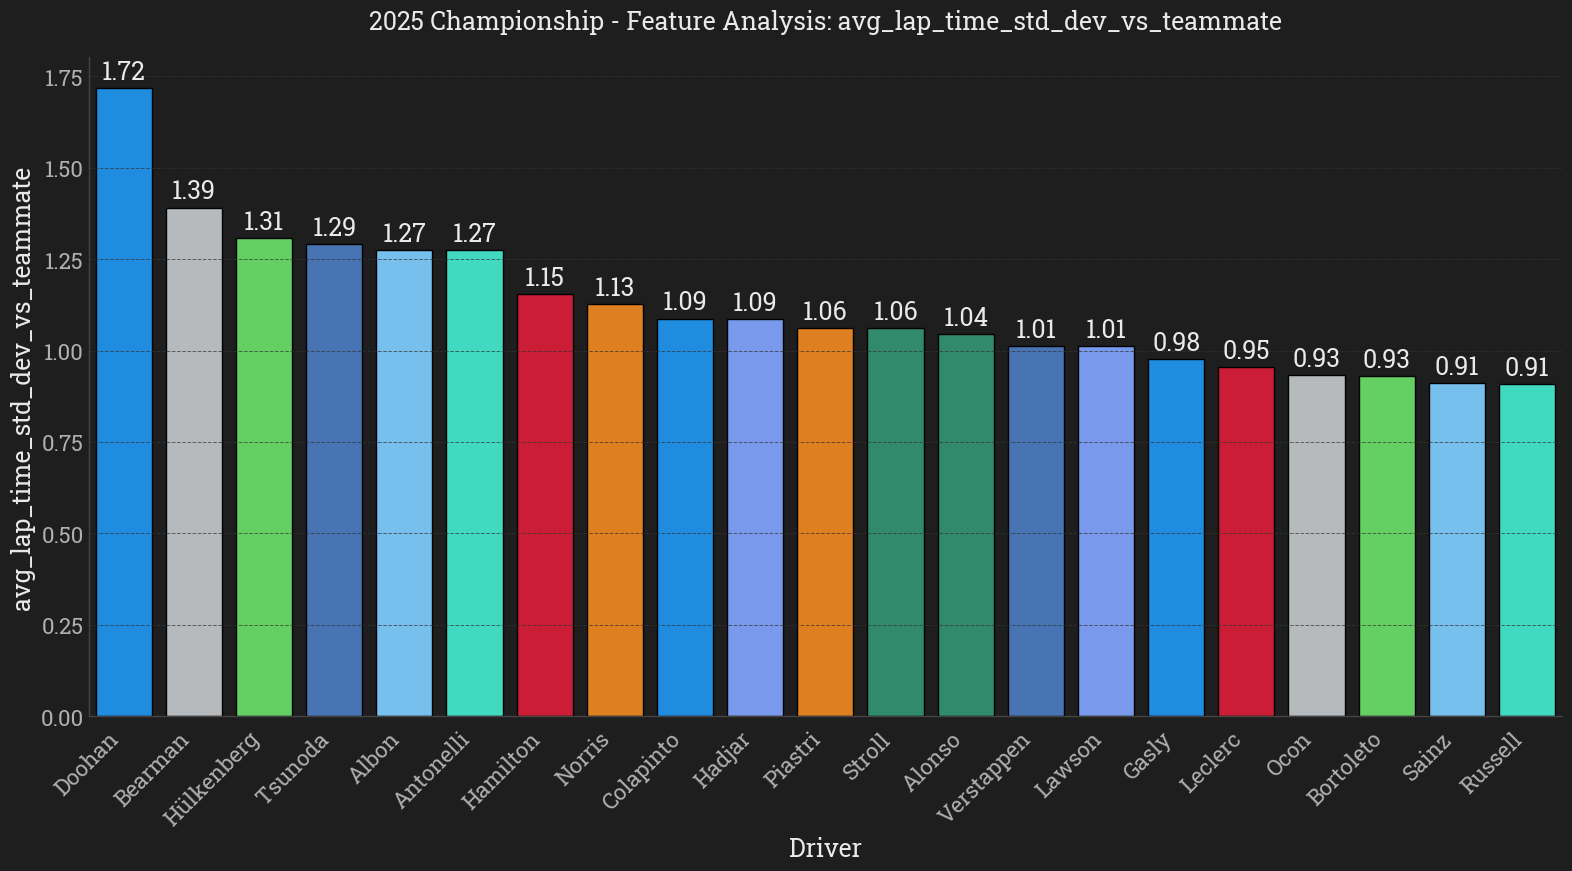

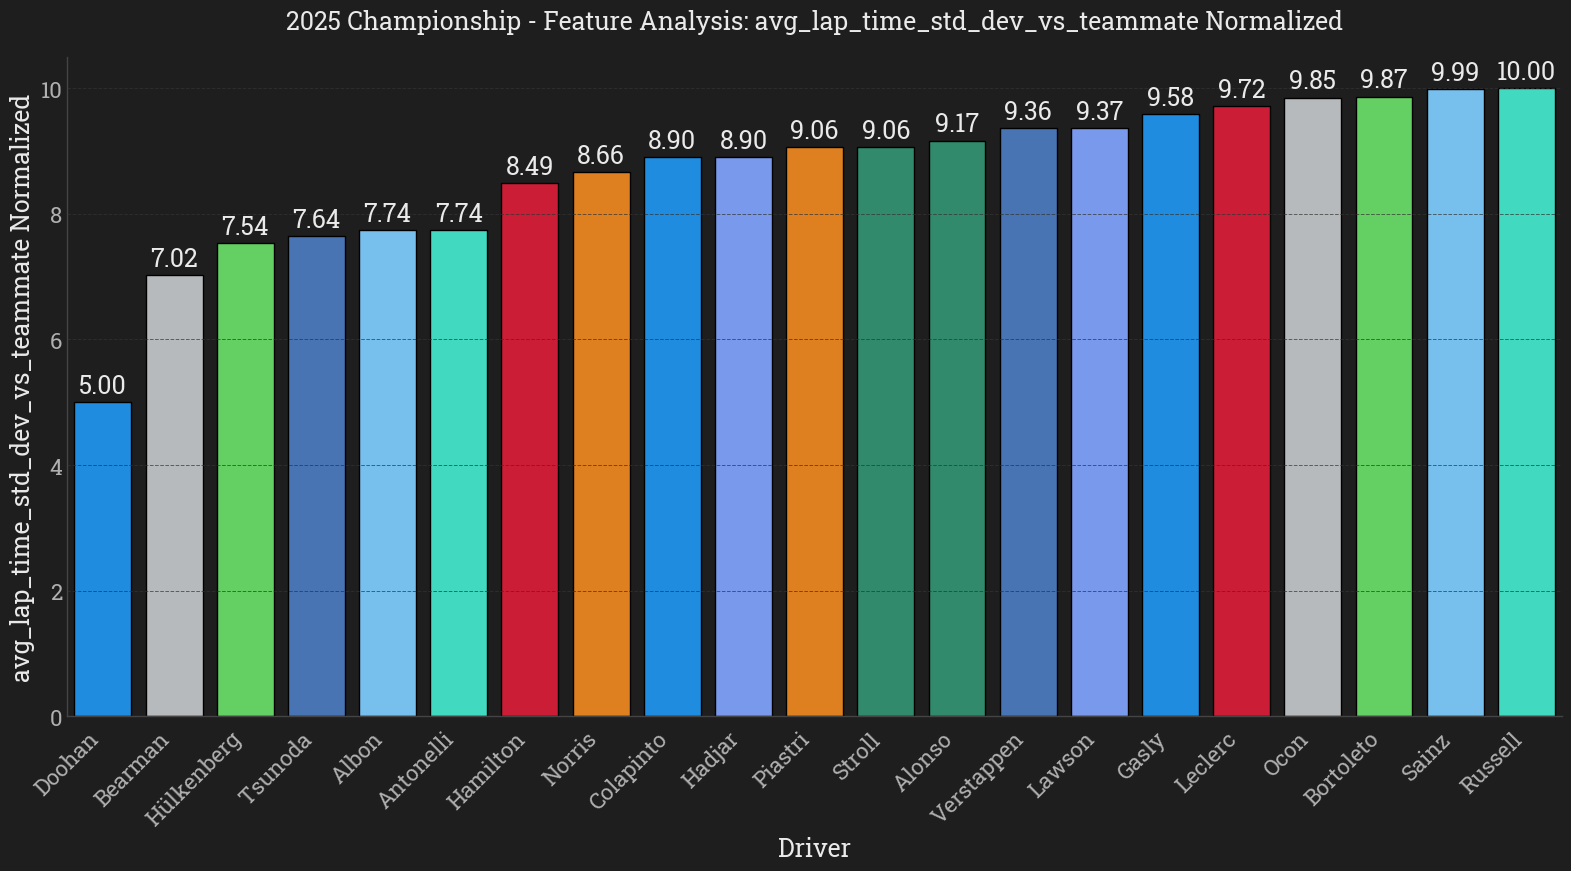

In [69]:
selected_feature = list_pace_features[feature_index]

df_pace = create_feature_norm_analysis(df_feature=df_pace, feature=selected_feature, lower_is_better=True)

feature_index += 1

Again, the formula for the calculation is the same as explained in the previous cell. But now we are comparing the driver's median pace to his teammate's median pace instead of the whole field median pace.

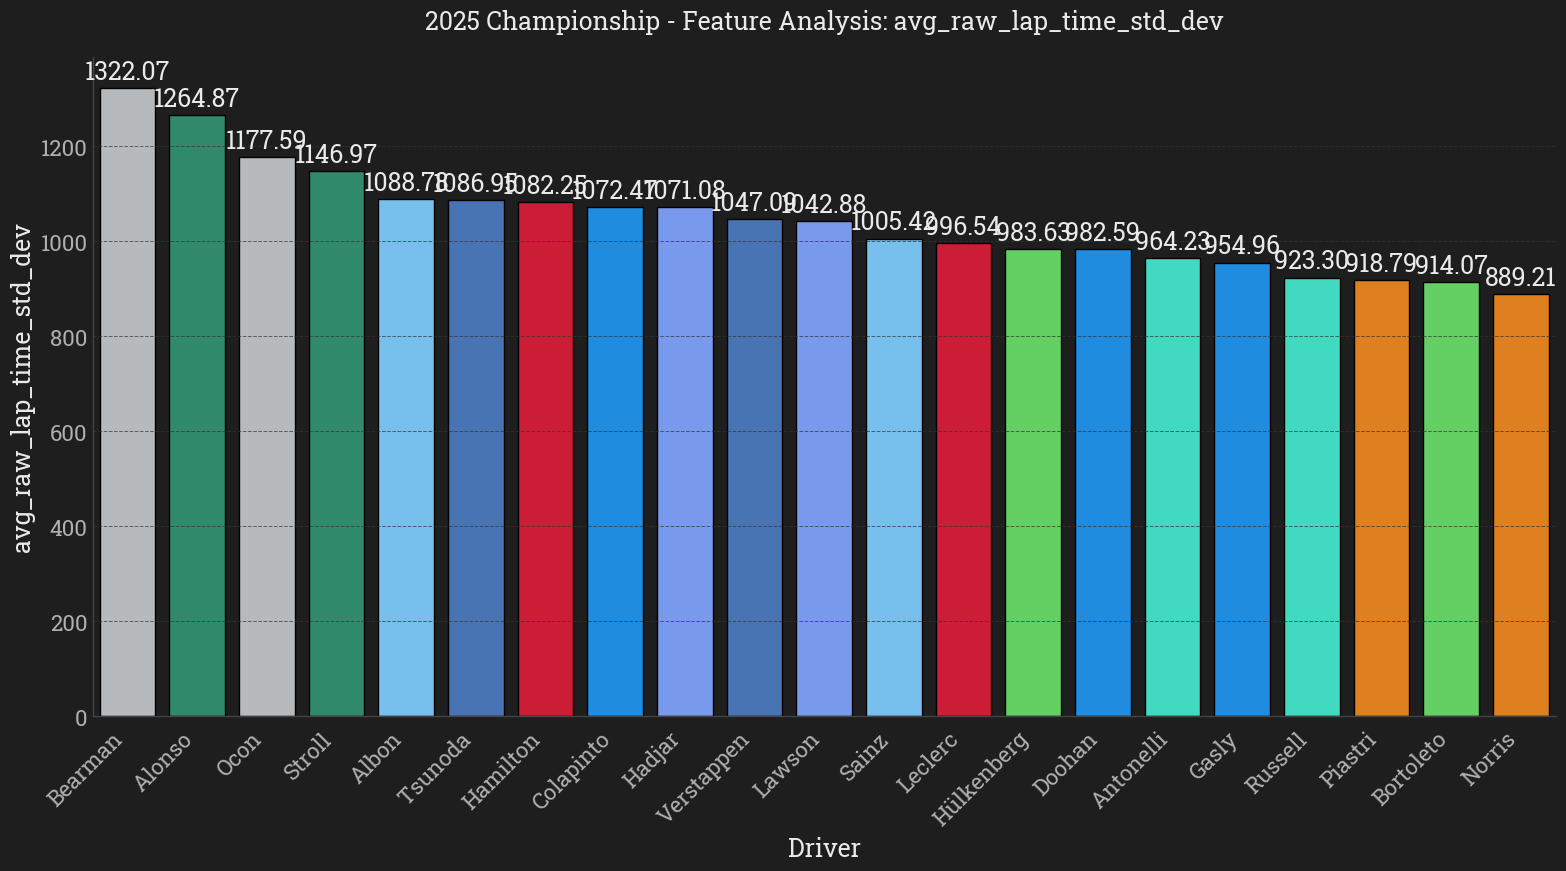

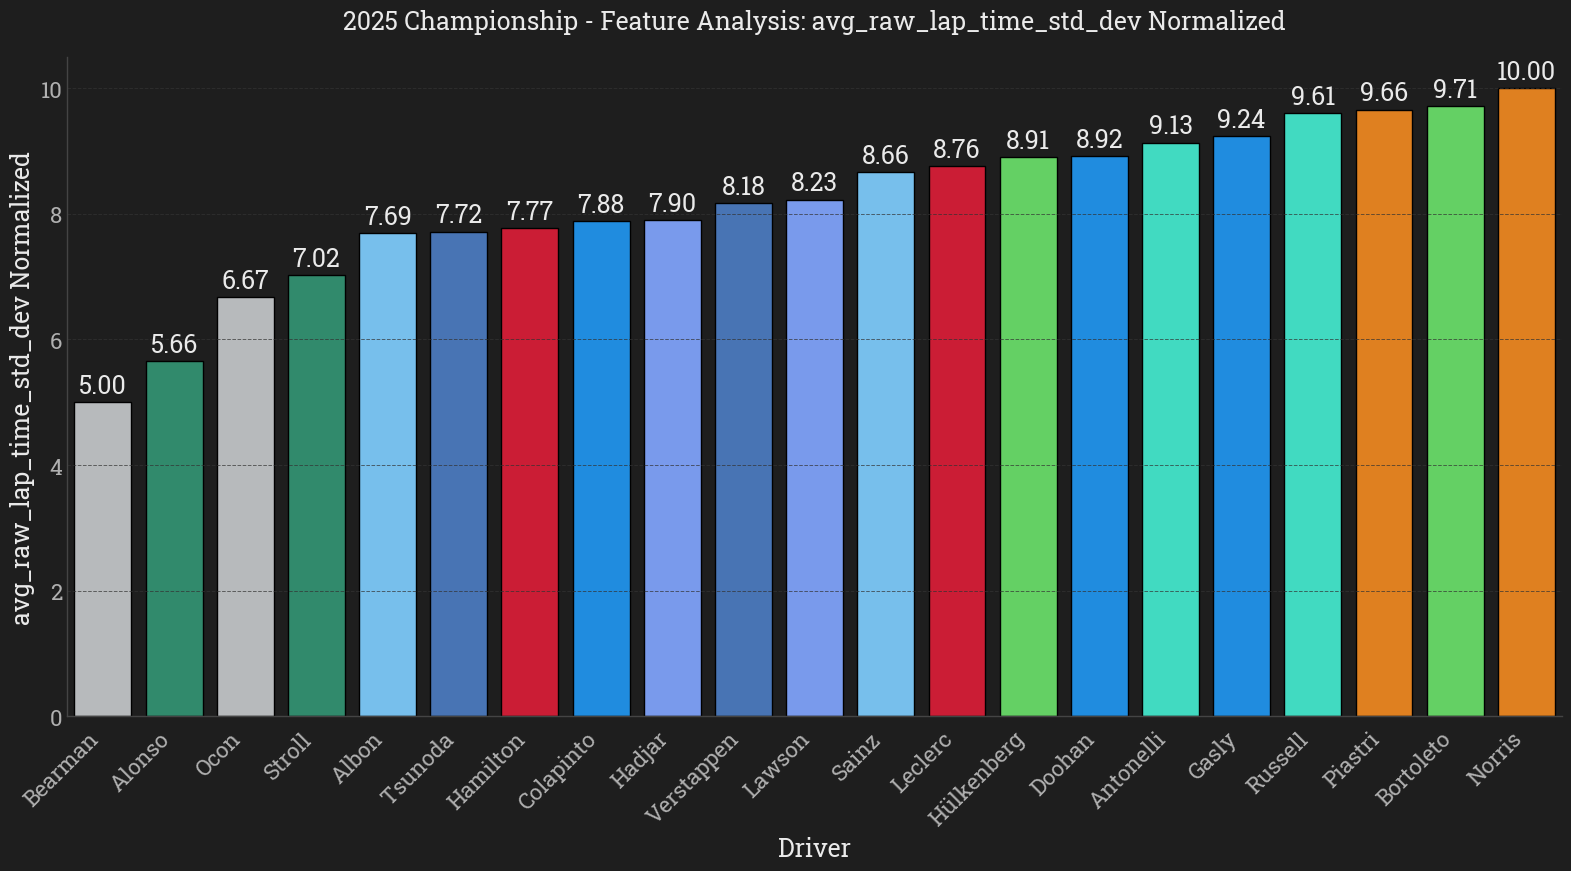

In [70]:
selected_feature = list_pace_features[feature_index]

df_pace = create_feature_norm_analysis(df_feature=df_pace, feature=selected_feature, lower_is_better=True)

feature_index += 1

Here, instead of comparing the standard deviation of the driver's pace to the standard deviation of the field or teammate, we are showing the raw value.

What I found interesting is that Norris shows up as the most consistent driver when looking at the raw value, but when looking at the value for the feature comparing him to his teammate, he has a higher standard deviation.

This can happen because of the way the data is distributed, since we first compare the driver's standard deviation for every race, and than we calculate the mean value for the year. So, a scenario that this phenomena can happen (and probably has), is that Piastri is probably more consistent than Norris in amount of races, but overall, Lando is able to maintain his consistency across races better than Piastri, who could have suffered with a few rounds where he was not as consistent as he should be.


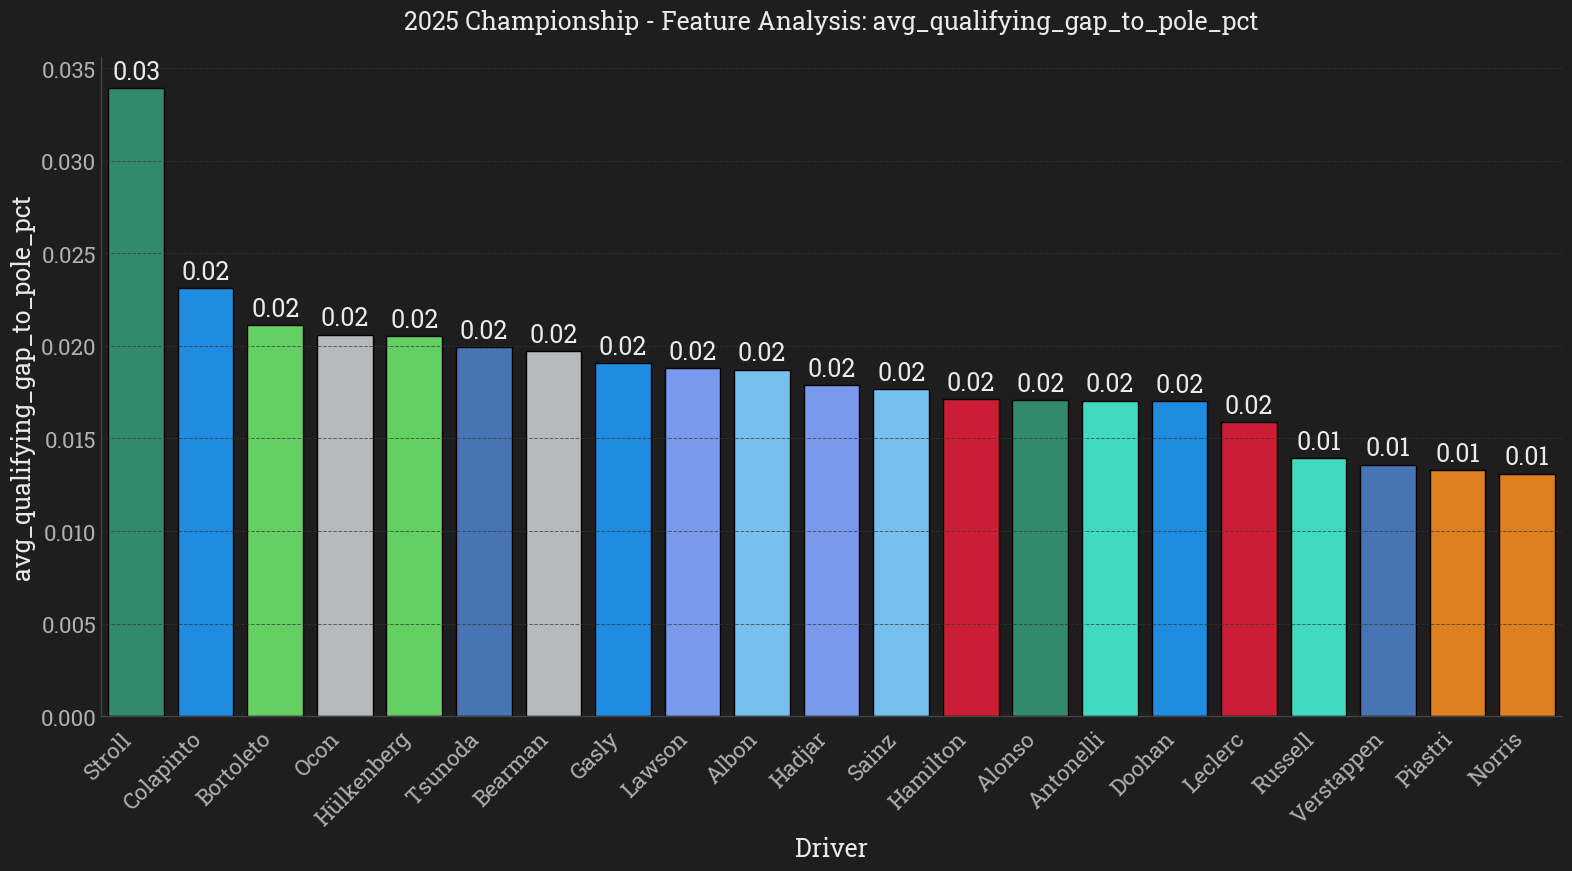

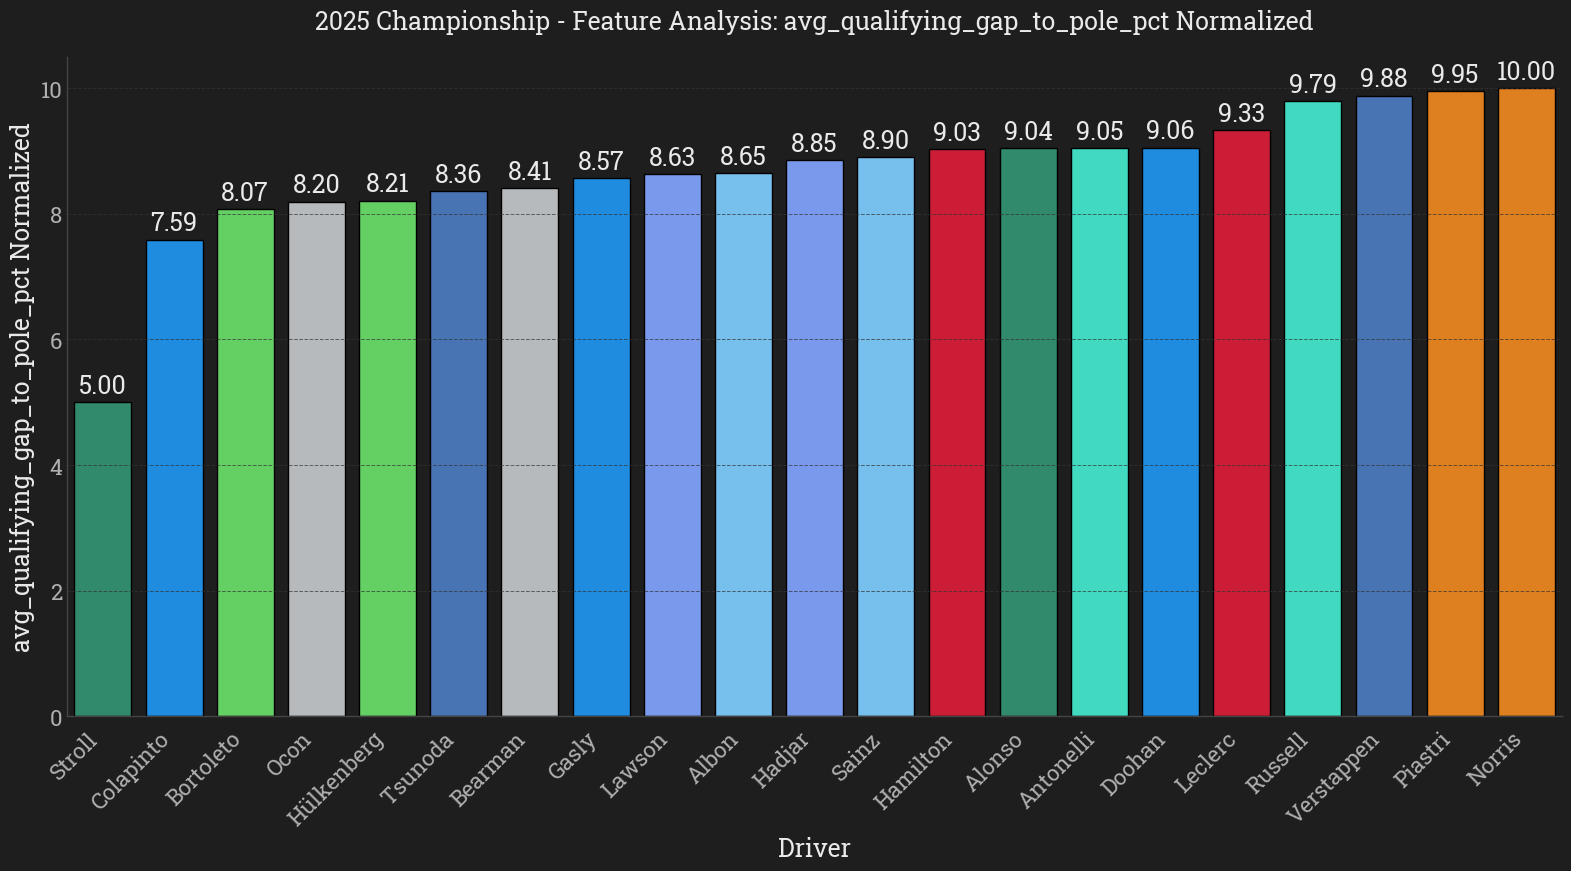

In [71]:
selected_feature = list_pace_features[feature_index]

df_pace = create_feature_norm_analysis(df_feature=df_pace, feature=selected_feature, lower_is_better=True)

feature_index += 1

The feature above is calculated through the following process:

1. Get the driver's best lap time for each qualifying session;
2. Get the best overall time for each qualifying session (usually pole);
3. Divide the driver's best lap time by the best overall time for each qualifying session, getting a ratio of how fast the driver was in comparison to the pole position time;
4. Subtract 1 from the ratio to get a value that represents the "percentage off-pole" of the driver in that session;
5. Average the percentage off-pole for each driver across all qualifying sessions to get the value representative of the whole season.


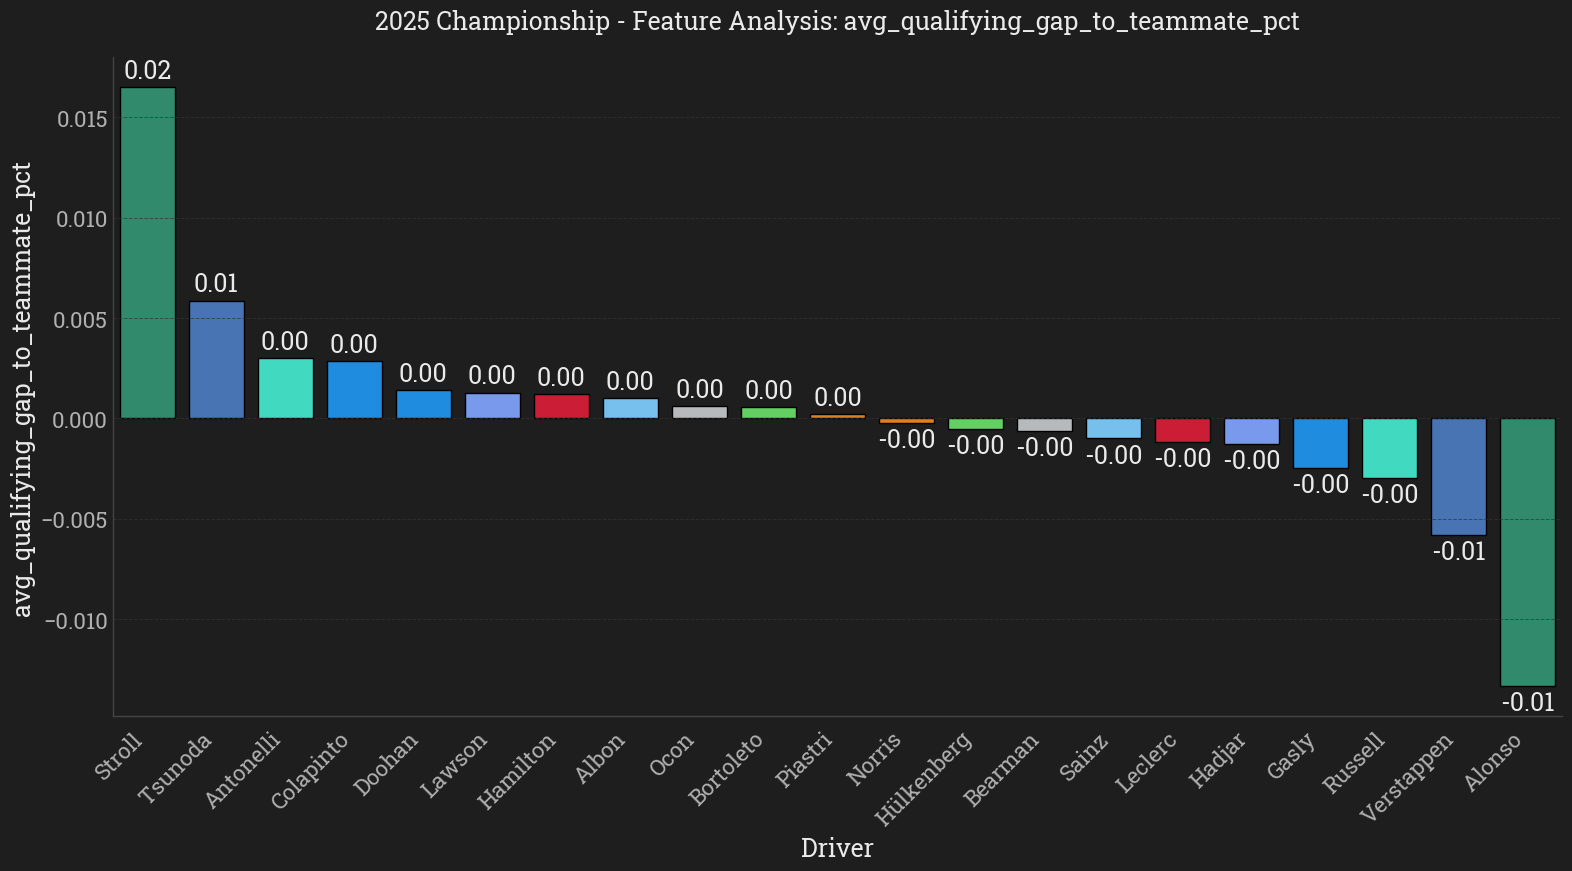

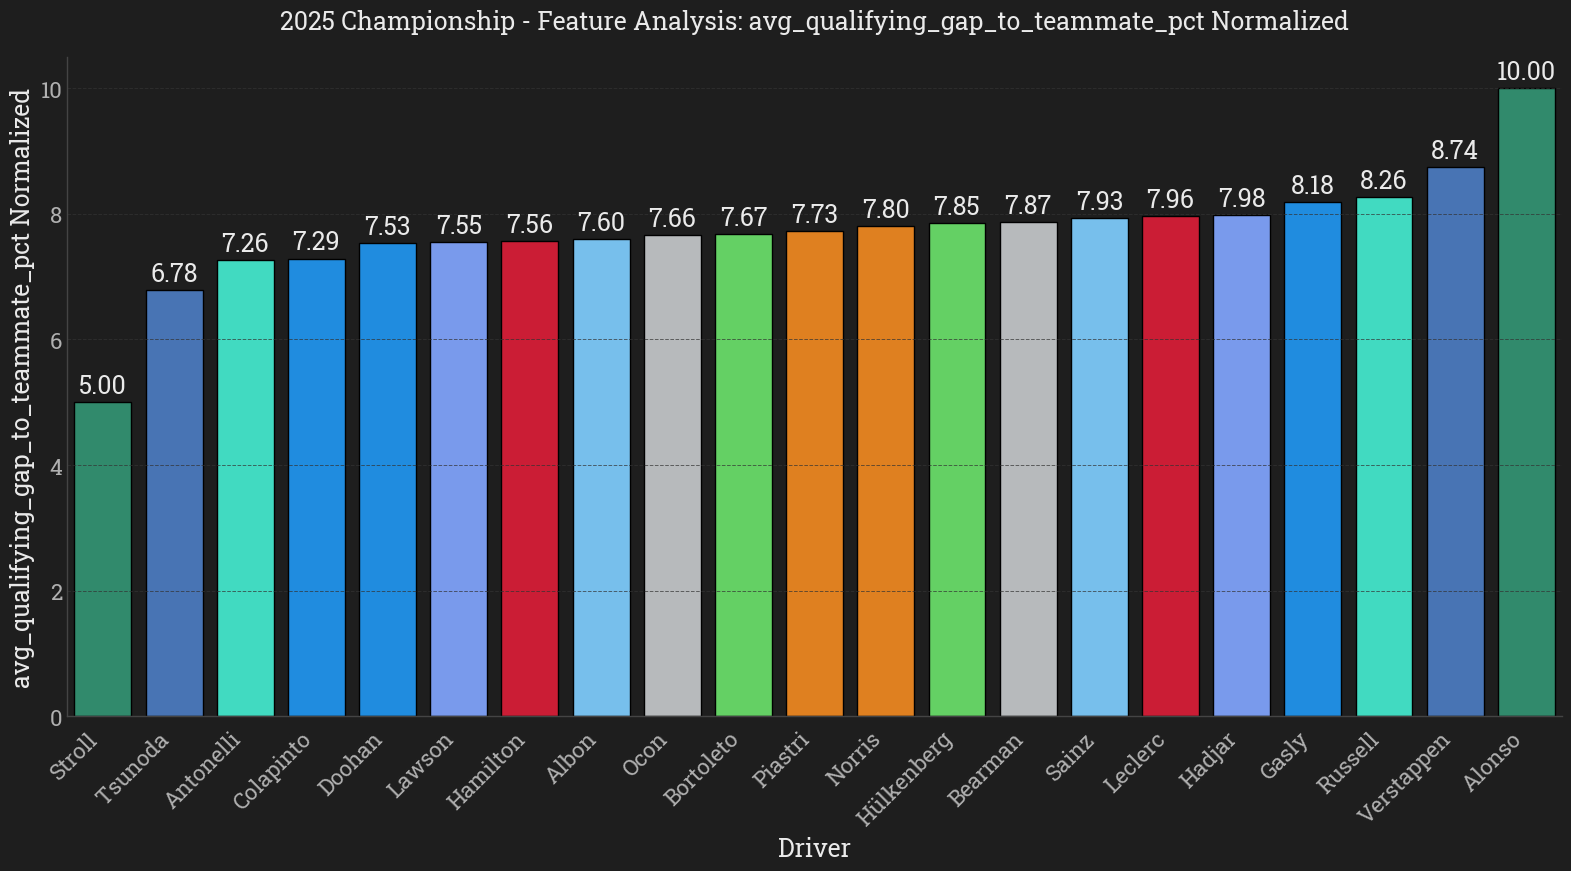

In [72]:
selected_feature = list_pace_features[feature_index]

df_pace = create_feature_norm_analysis(df_feature=df_pace, feature=selected_feature, lower_is_better=True)

feature_index += 1

The calculations for this feature is pretty much the same as above but using the teammate's best time as a comparison basis instead of the pole time.

# Performance Features

In [73]:
df_perf

driver_id  year       driver_full_name driver_surname constructor_name  \
2671        763  2025        Fernando Alonso         Alonso     Aston Martin   
2804        795  2025         Lewis Hamilton       Hamilton          Ferrari   
2877        807  2025        Nico Hülkenberg     Hülkenberg           Sauber   
2987        830  2025           Carlos Sainz          Sainz         Williams   
2998        831  2025         Max Verstappen     Verstappen         Red Bull   
3017        838  2025           Esteban Ocon           Ocon             Haas   
3030        840  2025           Lance Stroll         Stroll     Aston Martin   
3039        841  2025           Pierre Gasly          Gasly           Alpine   
3049        843  2025        Charles Leclerc        Leclerc          Ferrari   
3057        845  2025           Lando Norris         Norris          McLaren   
3063        846  2025        Alexander Albon          Albon         Williams   
3070        847  2025         George Russell        Russell         Mercedes   
3080        851  2025           Yuki Tsunoda        Tsunoda         Red Bull   
3093        857  2025          Oscar Piastri        Piastri          McLaren   
3096        858  2025            Liam Lawson         Lawson            VCARB   
3098        859  2025         Oliver Bearman        Bearman             Haas   
3100        860  2025       Franco Colapinto      Colapinto           Alpine   
3102        861  2025            Jack Doohan         Doohan           Alpine   
3103        862  2025      Gabriel Bortoleto      Bortoleto           Sauber   
3104        863  2025  Andrea Kimi Antonelli      Antonelli         Mercedes   
3105        864  2025           Isack Hadjar         Hadjar            VCARB   

      total_points  avg_finish_pos  avg_grid_pos  avg_positions_gained  \
2671          51.0       11.875000     10.208333             -1.666667   
2804         135.0        8.500000      9.375000              0.875000   
2877          51.0       12.791667     14.708333              1.916667   
2987          54.0       12.166667     11.166667             -1.000000   
2998         389.0        3.666667      3.583333             -0.083333   
3017          34.0       12.500000     15.000000              2.500000   
3030          29.0       13.695652     15.652174              1.956522   
3039          20.0       14.583333     13.375000             -1.208333   
3049         225.0        6.750000      5.416667             -1.333333   
3057         394.0        4.250000      2.958333             -1.291667   
3063          70.0       11.041667     12.750000              1.708333   
3070         289.0        4.541667      4.375000             -0.166667   
3080          21.0       13.227273     10.136364             -3.090909   
3093         381.0        4.208333      3.000000             -1.208333   
3096          38.0       13.113636     15.363636              2.250000   
3098          39.0       11.791667     14.208333              2.416667   
3100           0.0       16.055556     16.444444              0.388889   
3102           0.0       16.333333     15.500000             -0.833333   
3103          19.0       14.250000     14.208333             -0.041667   
3104         135.0        9.833333      8.750000             -1.083333   
3105          50.0       11.791667      9.791667             -2.000000   

      points_per_race  team_points_share  qualy_h2h_wins  race_h2h_wins  \
2671         2.125000           0.637500            22.0           15.0   
2804         5.625000           0.375000             5.0            4.0   
2877         2.125000           0.728571            12.0           13.0   
2987         2.250000           0.435484            15.0            9.0   
2998        16.208333           0.948780            23.0           23.0   
3017         1.416667           0.465753            11.0           12.0   
3030         1.260870           0.362500             1.0            8.0   
3039         0.8

In [74]:
list_perf_features = nb_utils.get_features_column_list(df_perf)
list_perf_features

['total_points',
 'avg_finish_pos',
 'avg_grid_pos',
 'avg_positions_gained',
 'points_per_race',
 'team_points_share',
 'qualy_h2h_wins',
 'race_h2h_wins',
 'starting_pos_diff_vs_tmate',
 'finish_pos_diff_vs_tmate',
 'points_obtained_diff_vs_tmate',
 'qualy_vs_teammate_win_rate',
 'race_vs_teammate_win_rate']

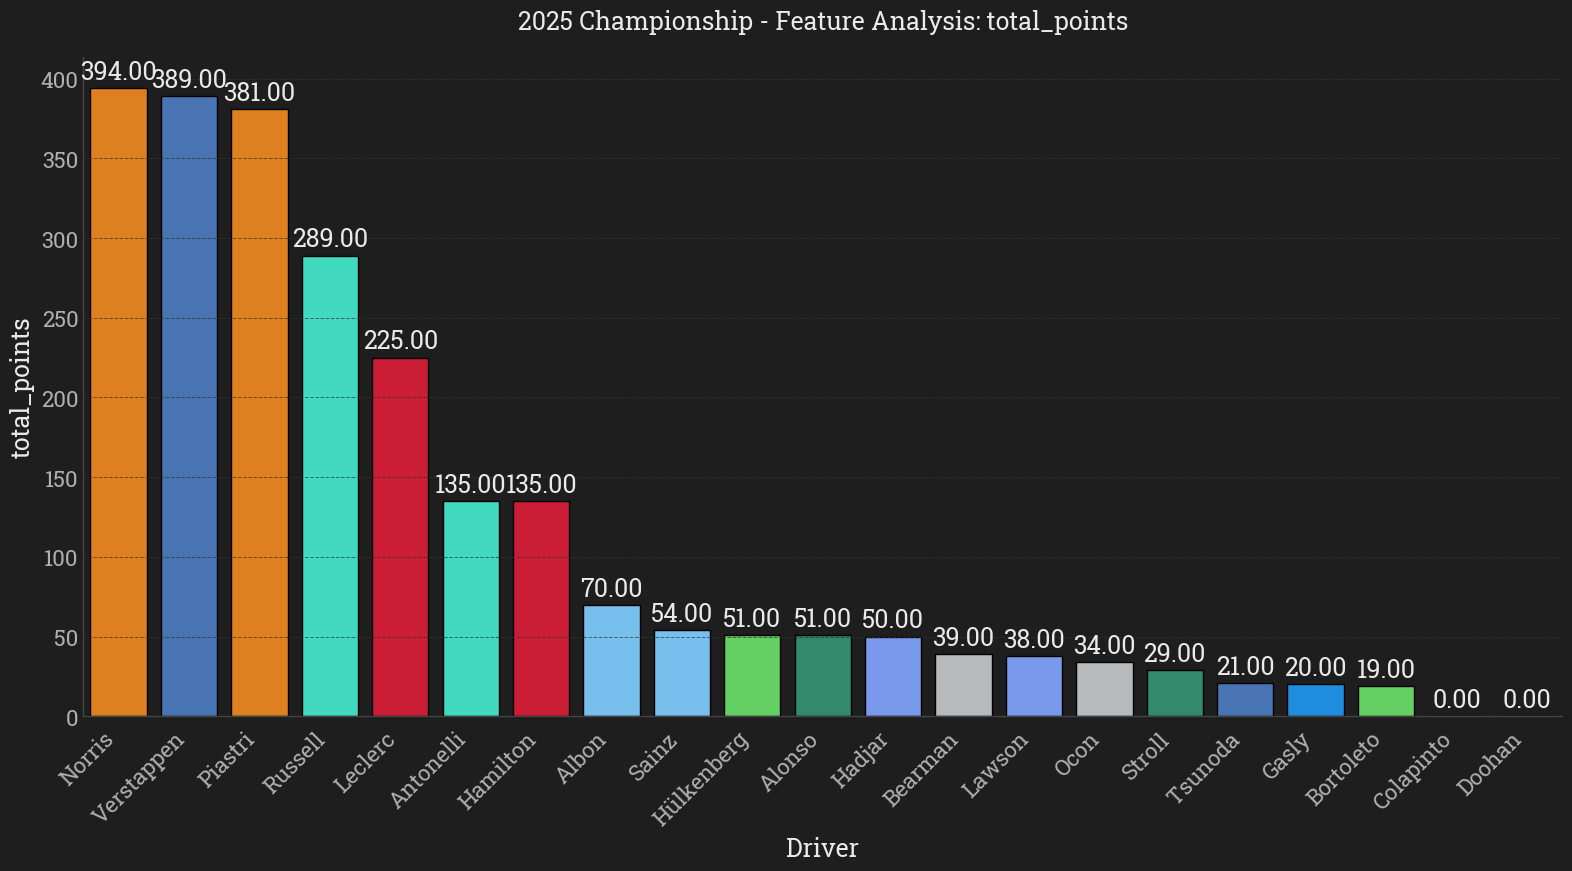

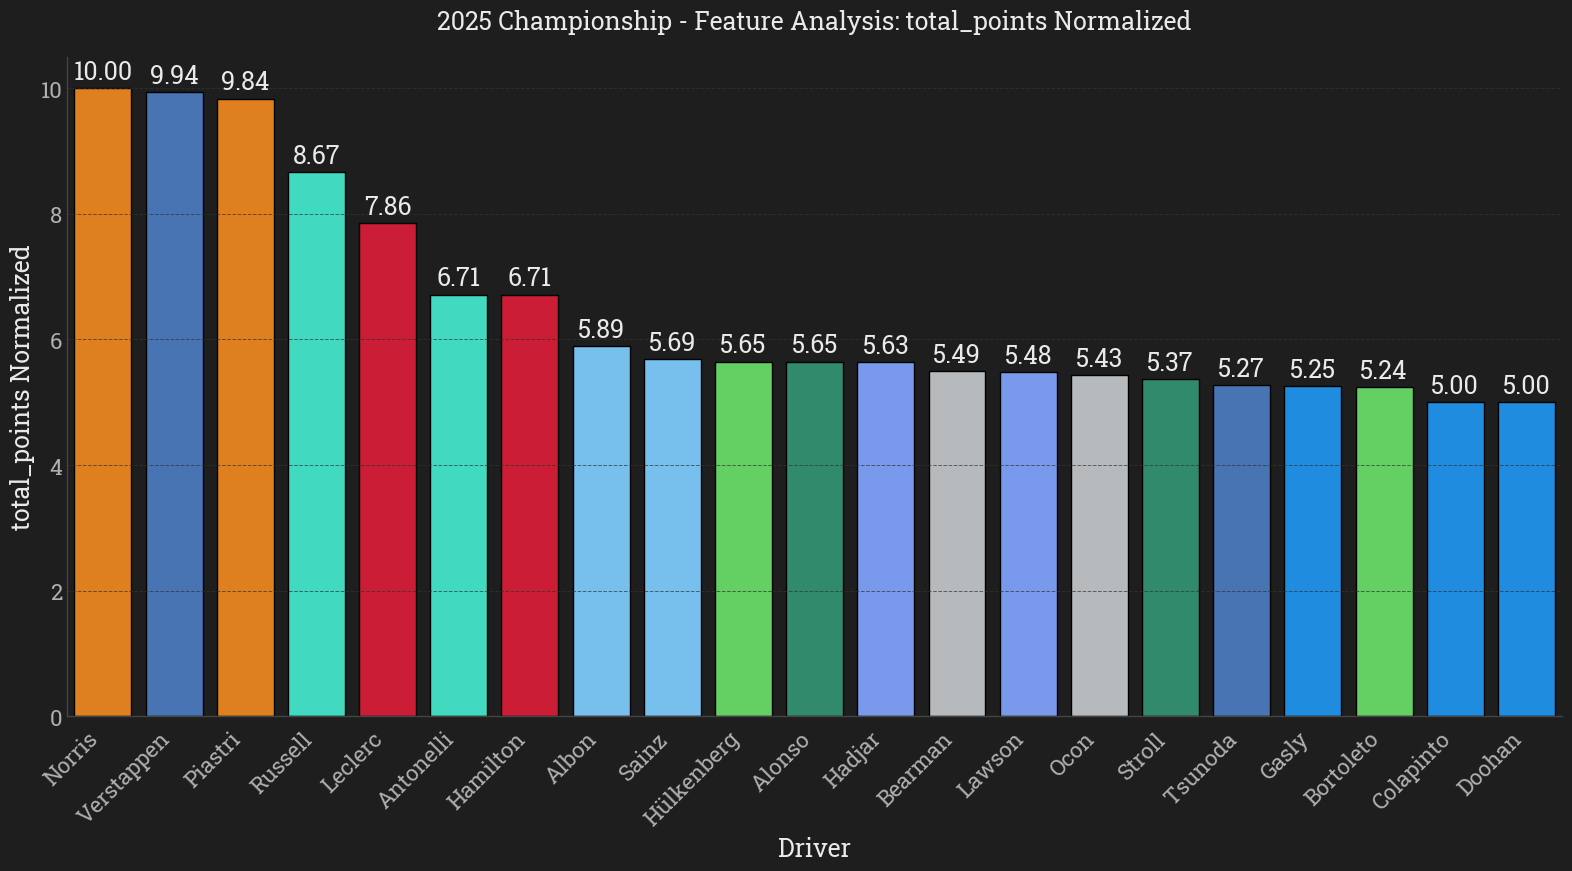

In [75]:
feature_index = 0

selected_feature = list_perf_features[feature_index]

df_perf = create_feature_norm_analysis(df_feature=df_perf, feature=selected_feature, lower_is_better=False)

feature_index += 1

Total points in the season, self-explanatory

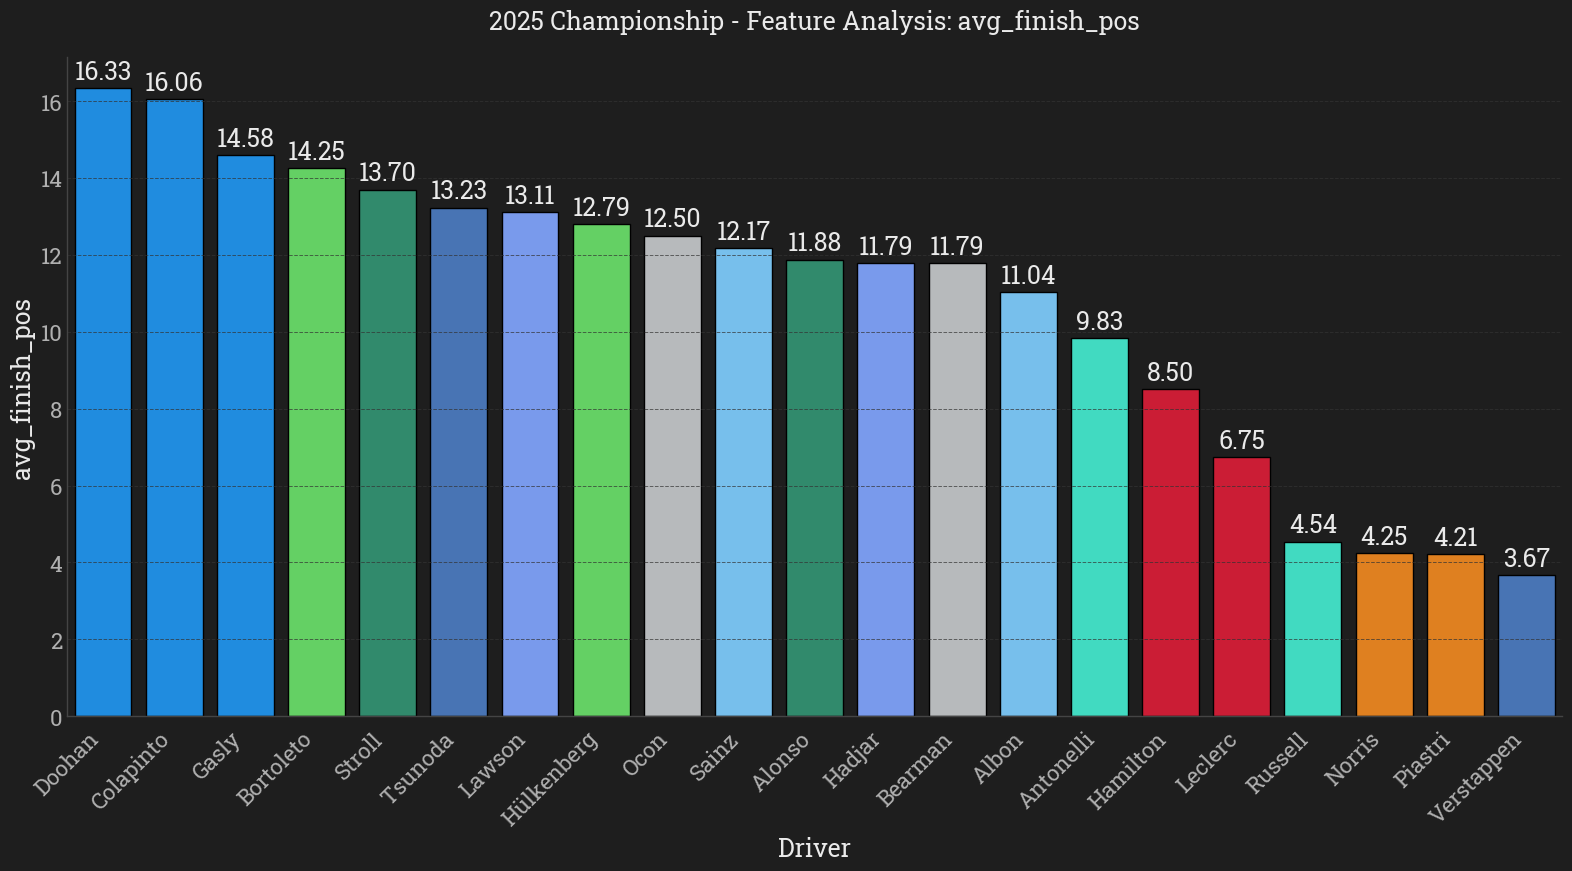

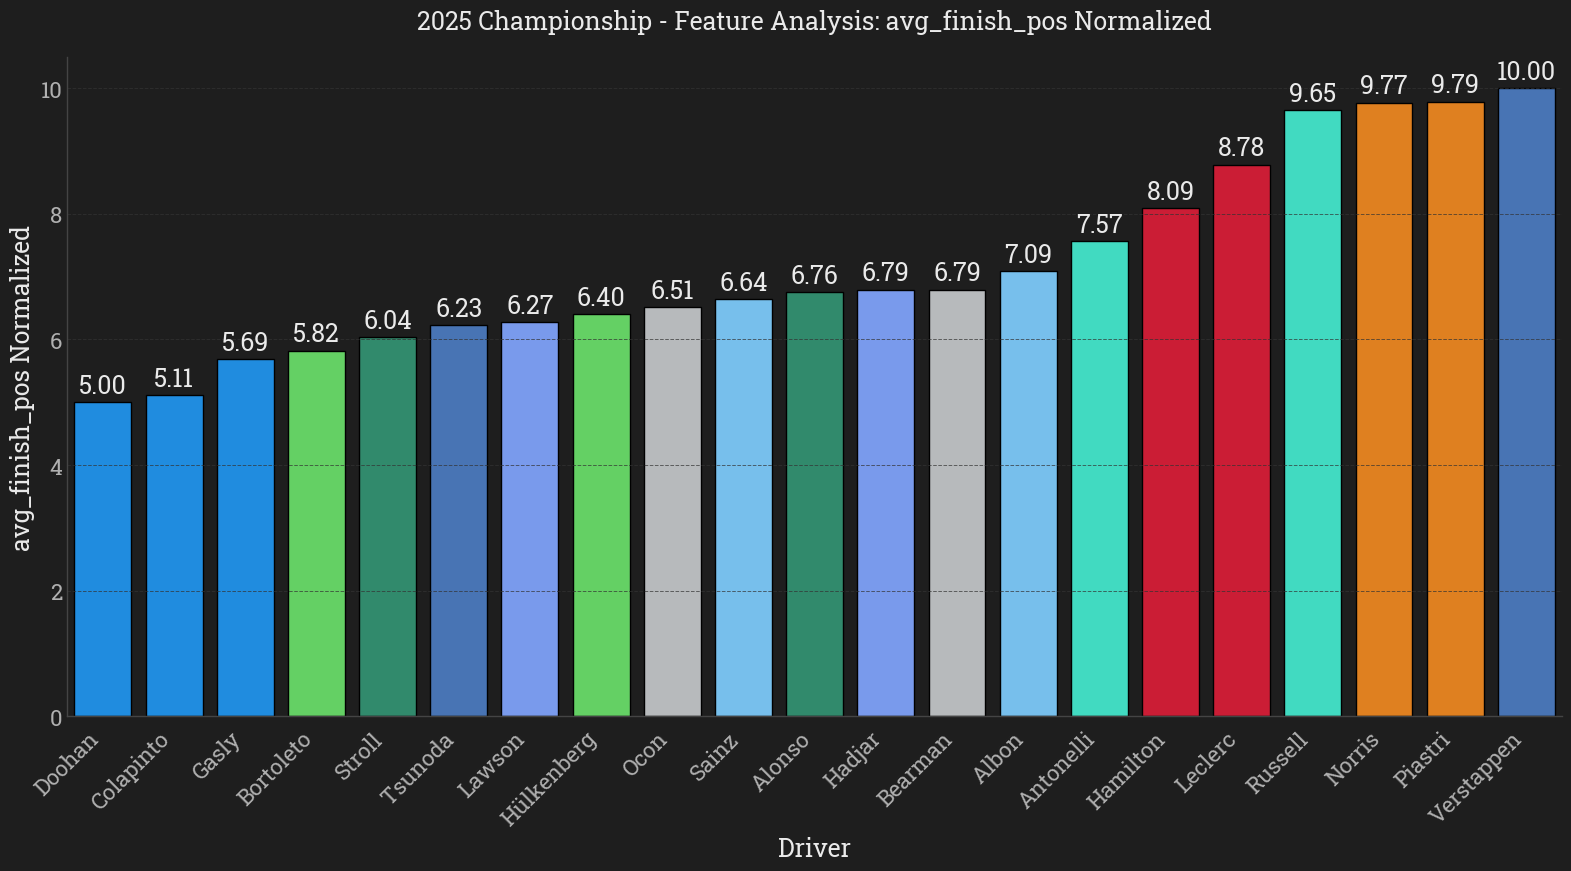

In [76]:
selected_feature = list_perf_features[feature_index]

df_perf = create_feature_norm_analysis(df_feature=df_perf, feature=selected_feature, lower_is_better=True)

feature_index += 1

Mean finishing position.

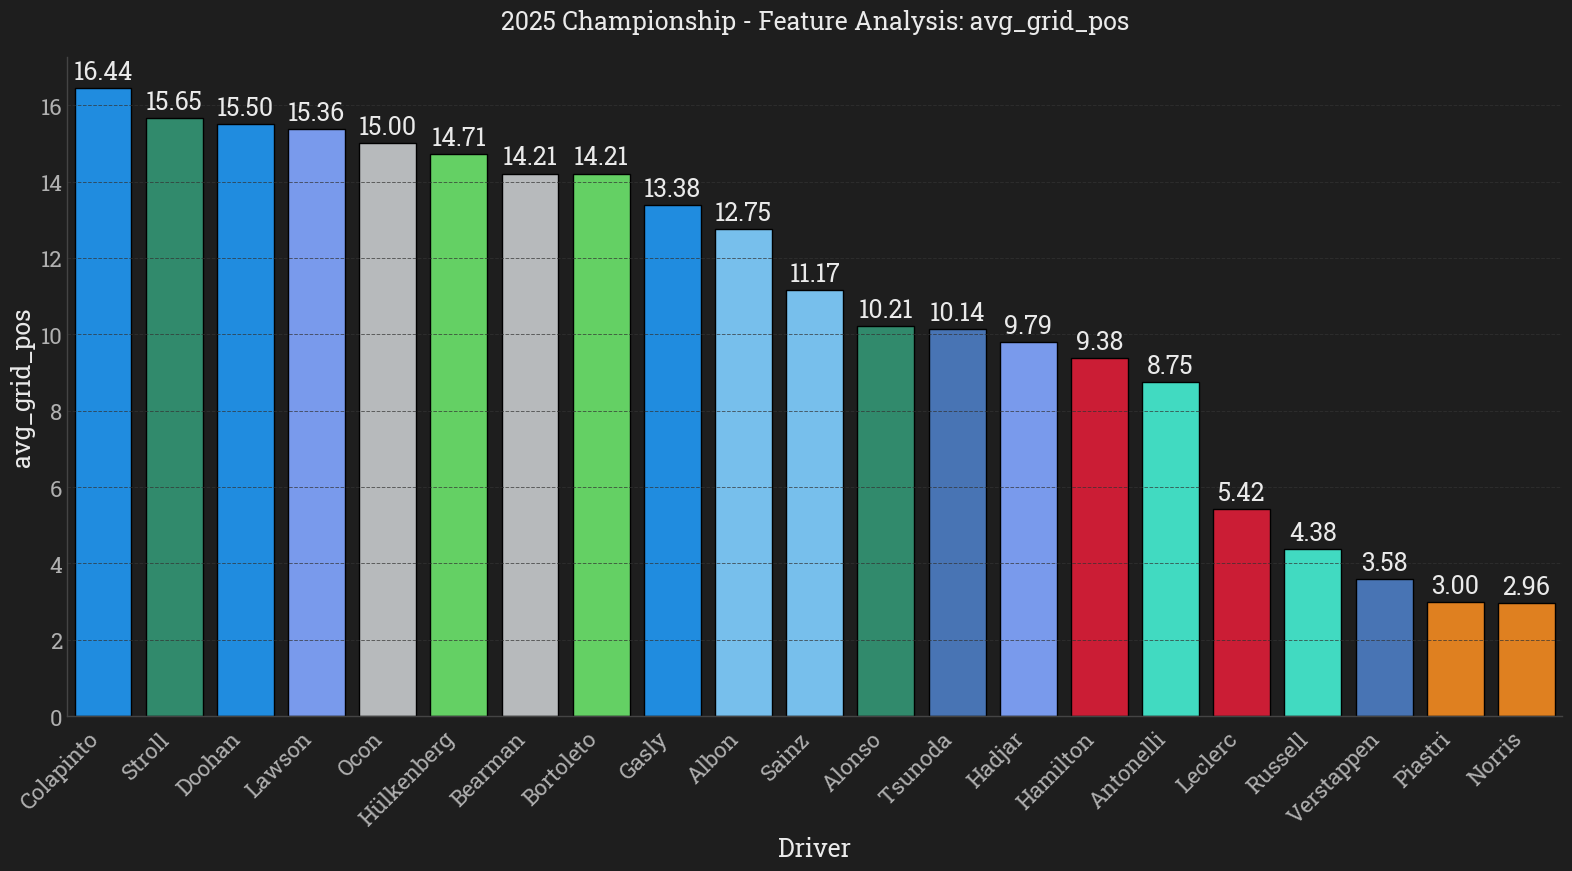

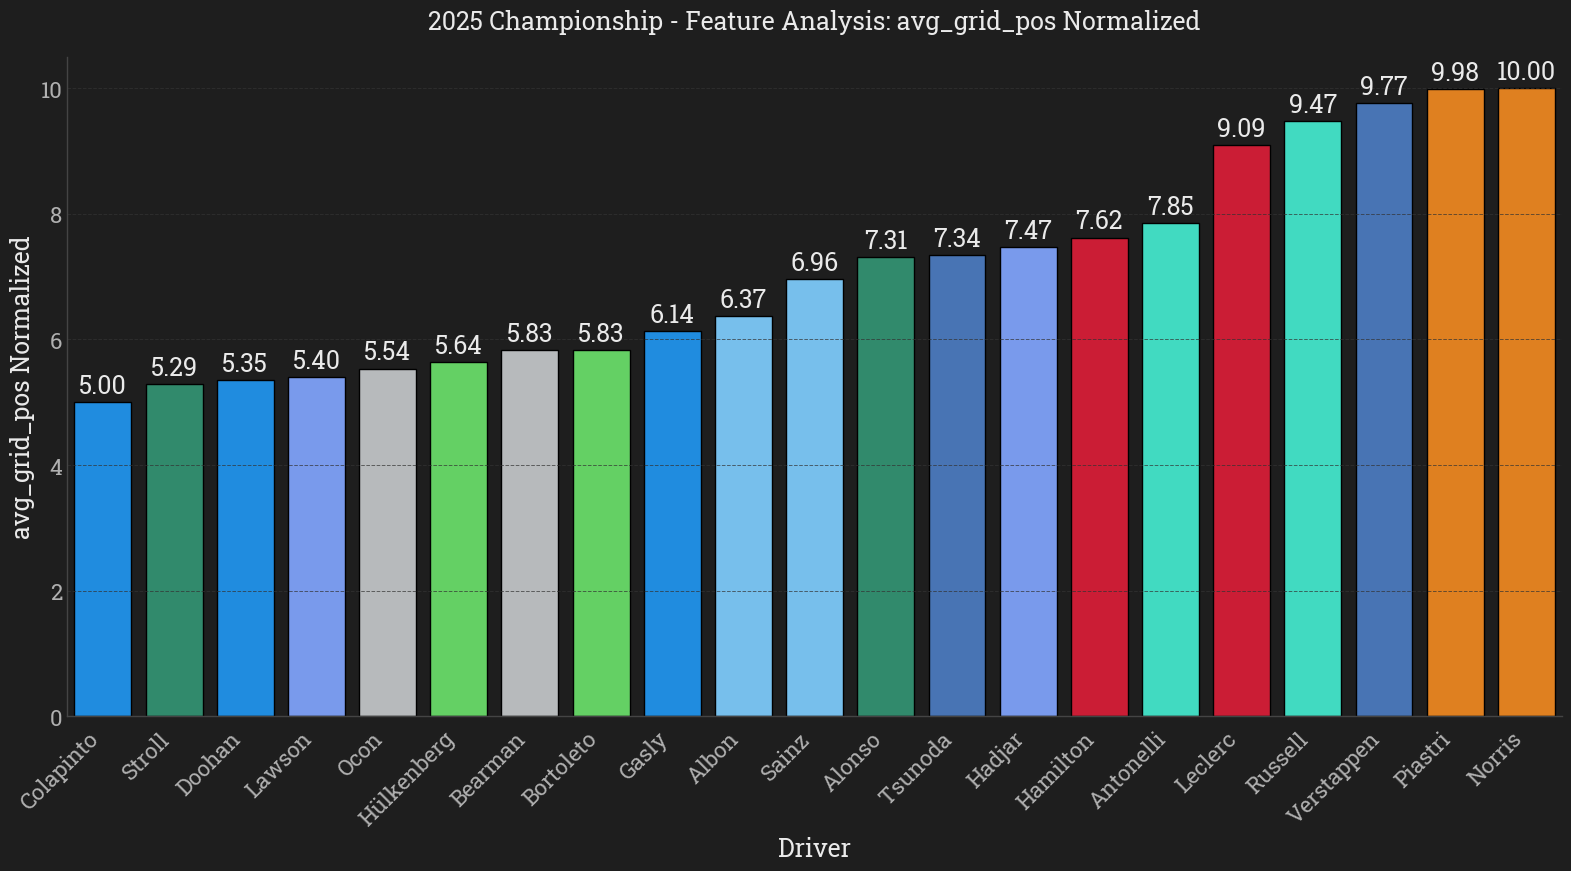

In [77]:
selected_feature = list_perf_features[feature_index]

df_perf = create_feature_norm_analysis(df_feature=df_perf, feature=selected_feature, lower_is_better=True)

feature_index += 1

Average starting position.

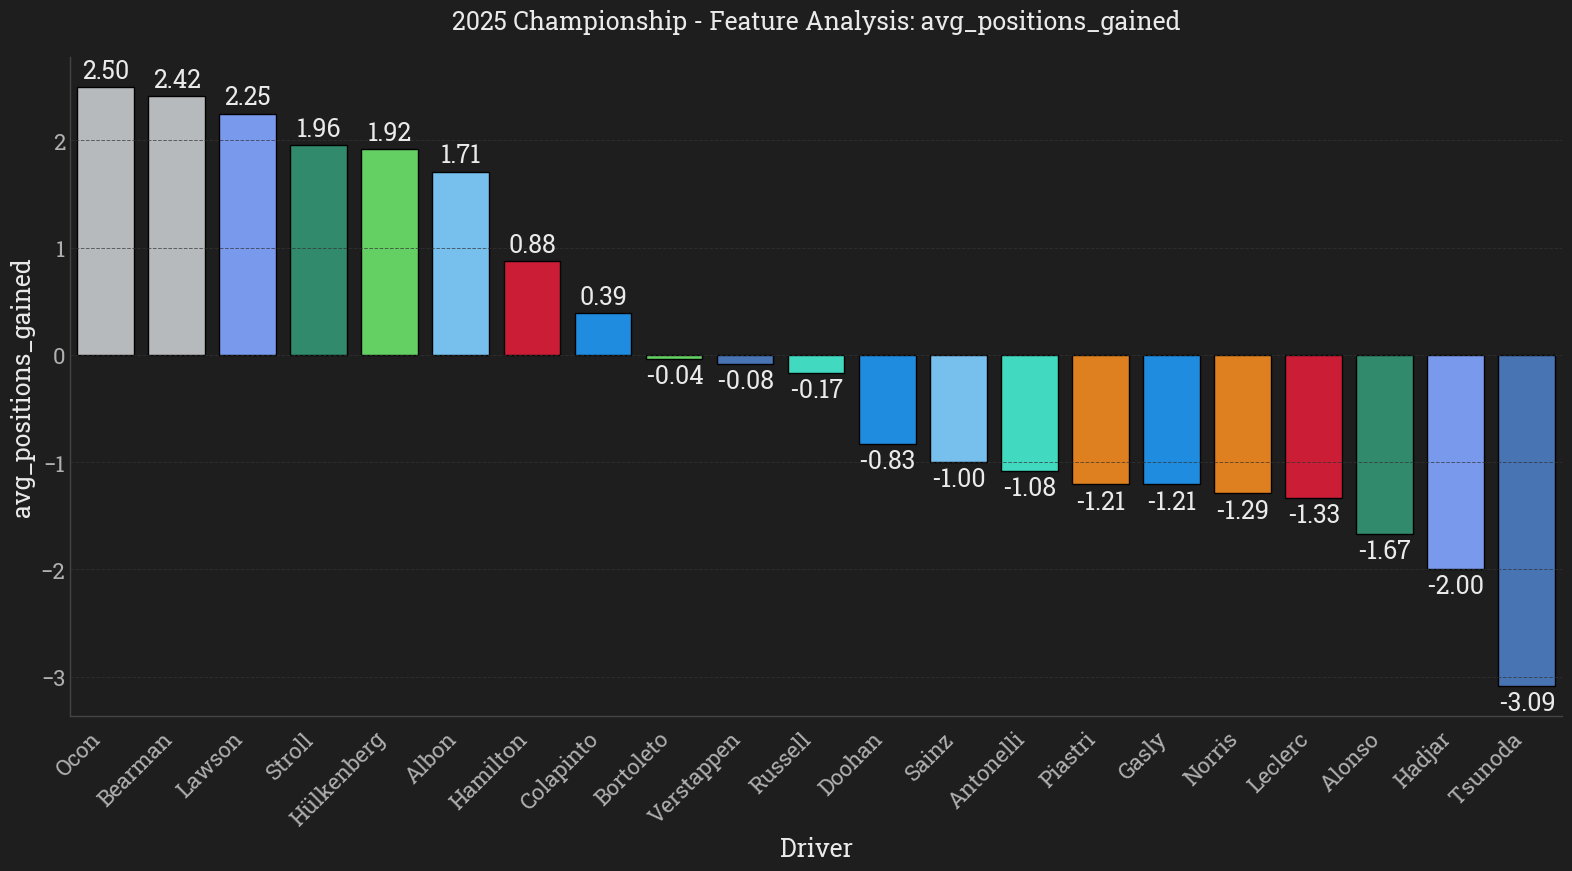

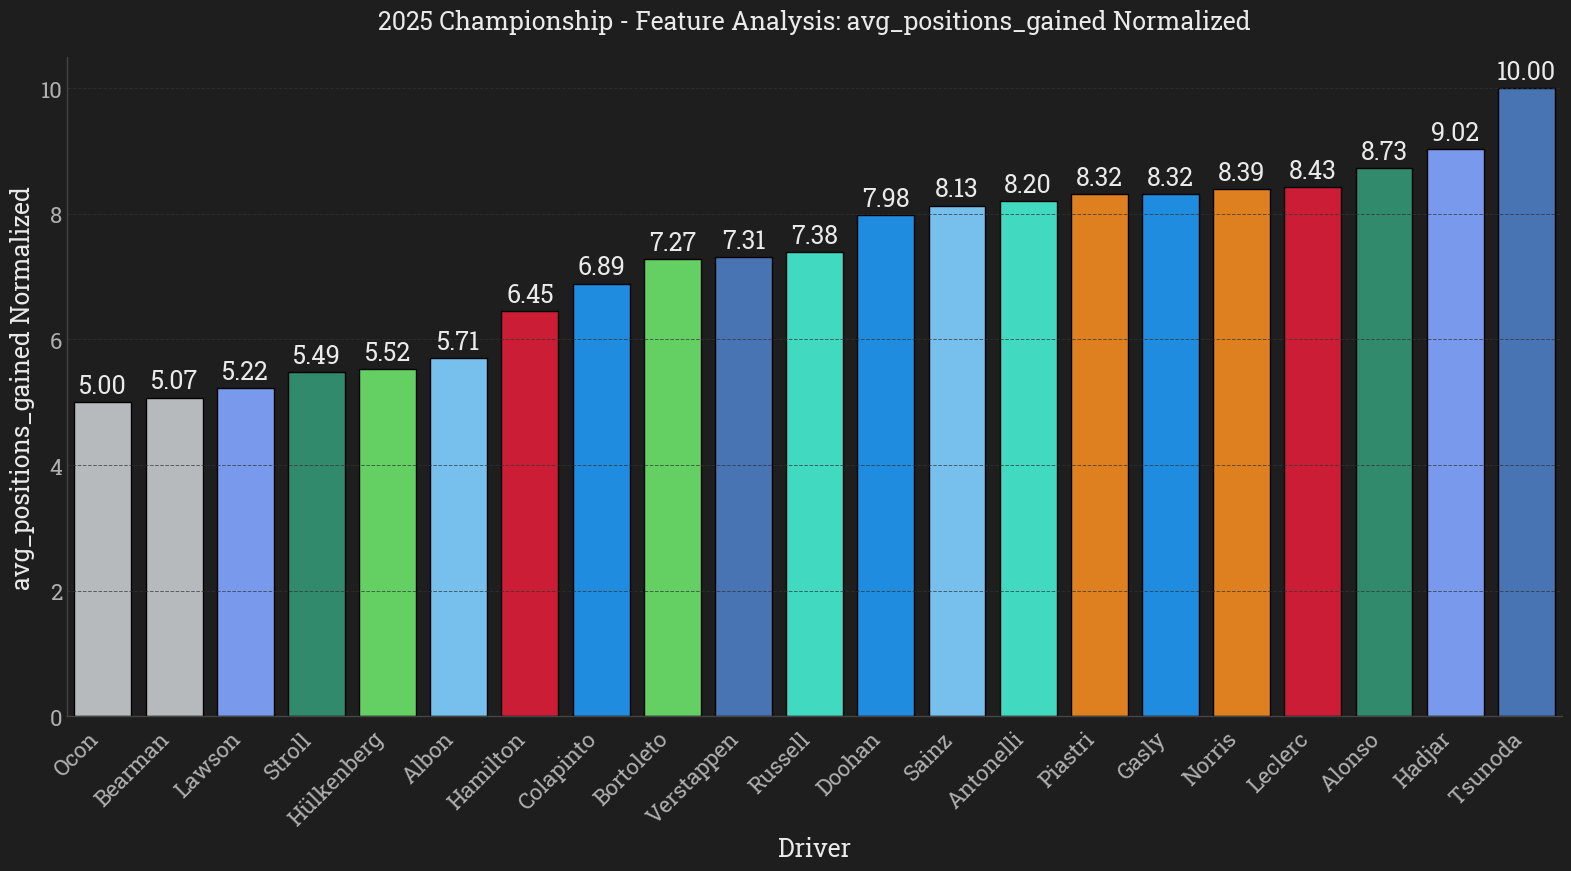

In [78]:
selected_feature = list_perf_features[feature_index]

df_perf = create_feature_norm_analysis(df_feature=df_perf, feature=selected_feature, lower_is_better=True)

feature_index += 1

Average difference between the finishing position and the starting position.

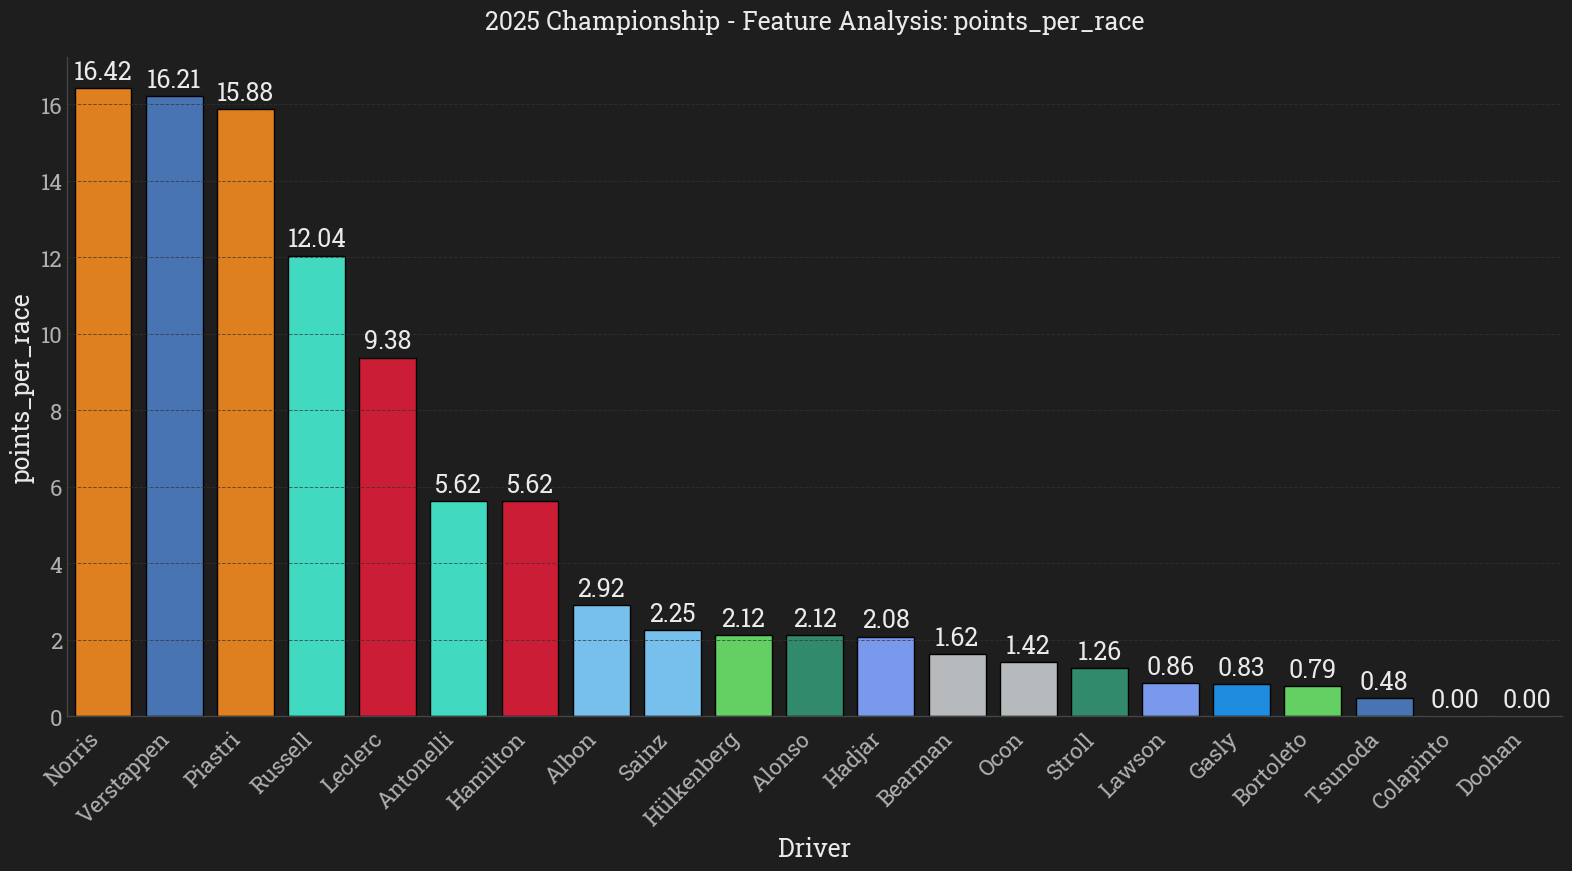

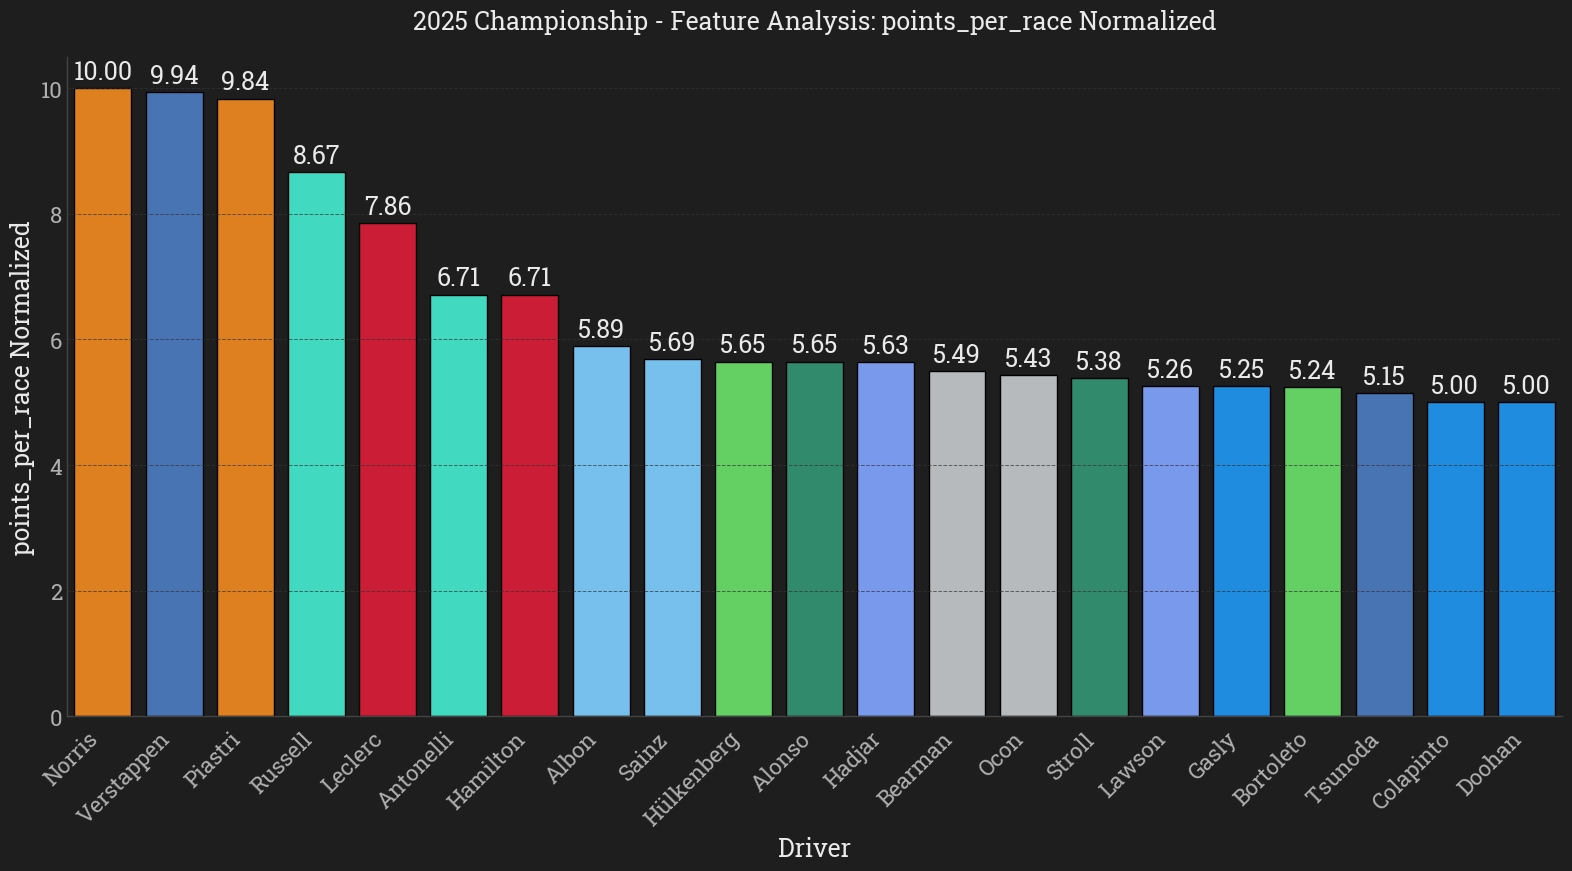

In [79]:
selected_feature = list_perf_features[feature_index]

df_perf = create_feature_norm_analysis(df_feature=df_perf, feature=selected_feature, lower_is_better=False)

feature_index += 1

Average points obtained in each round.

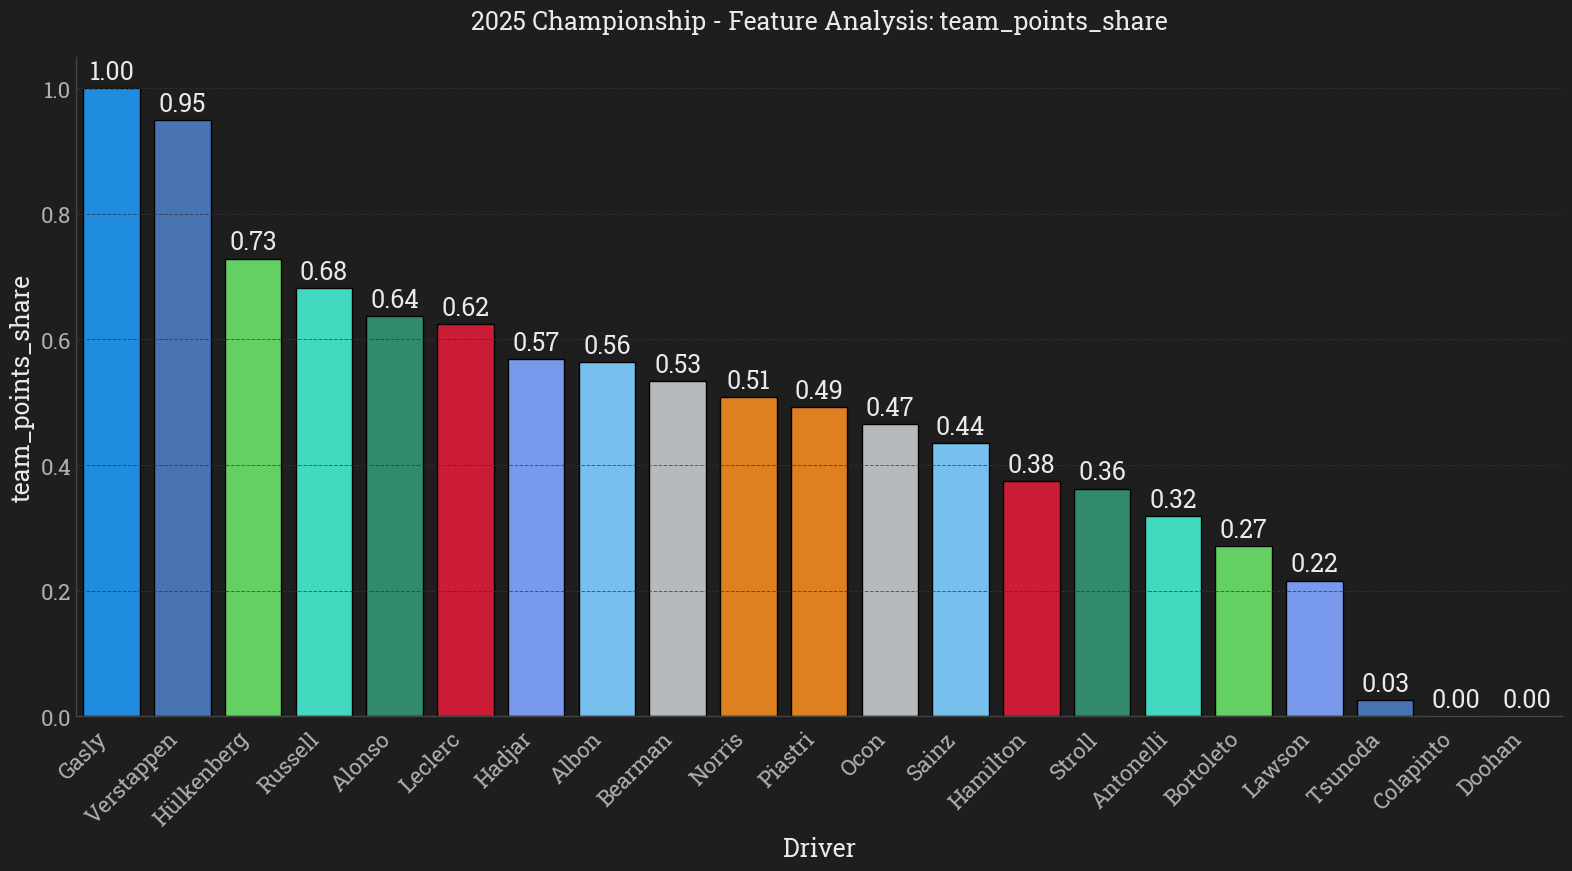

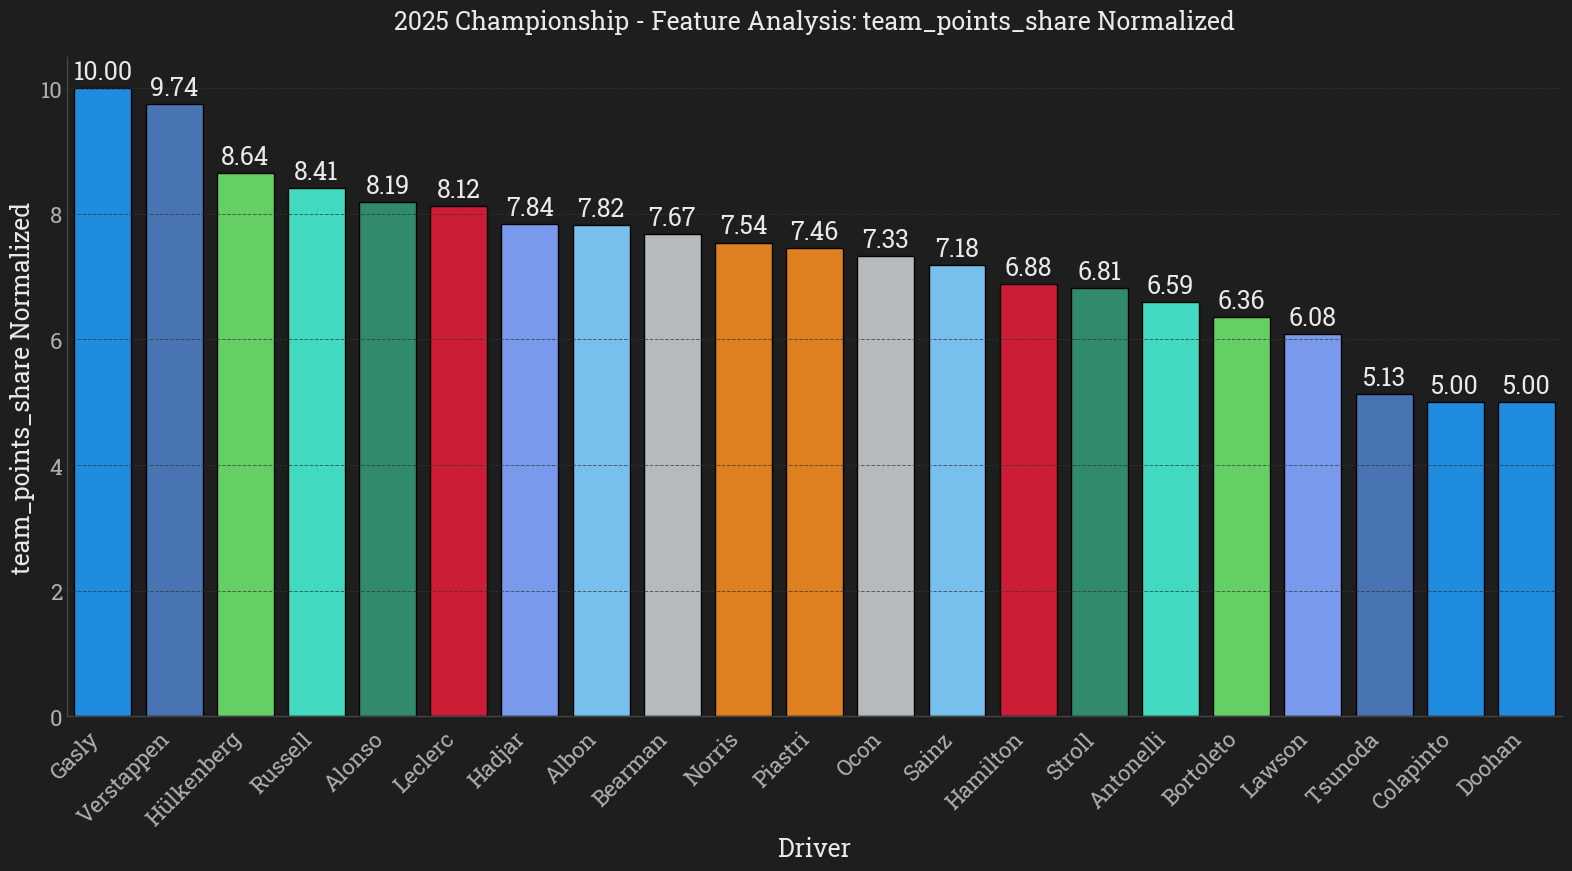

In [80]:
selected_feature = list_perf_features[feature_index]

df_perf = create_feature_norm_analysis(df_feature=df_perf, feature=selected_feature, lower_is_better=False)

feature_index += 1

Team's point share for each driver of the team.

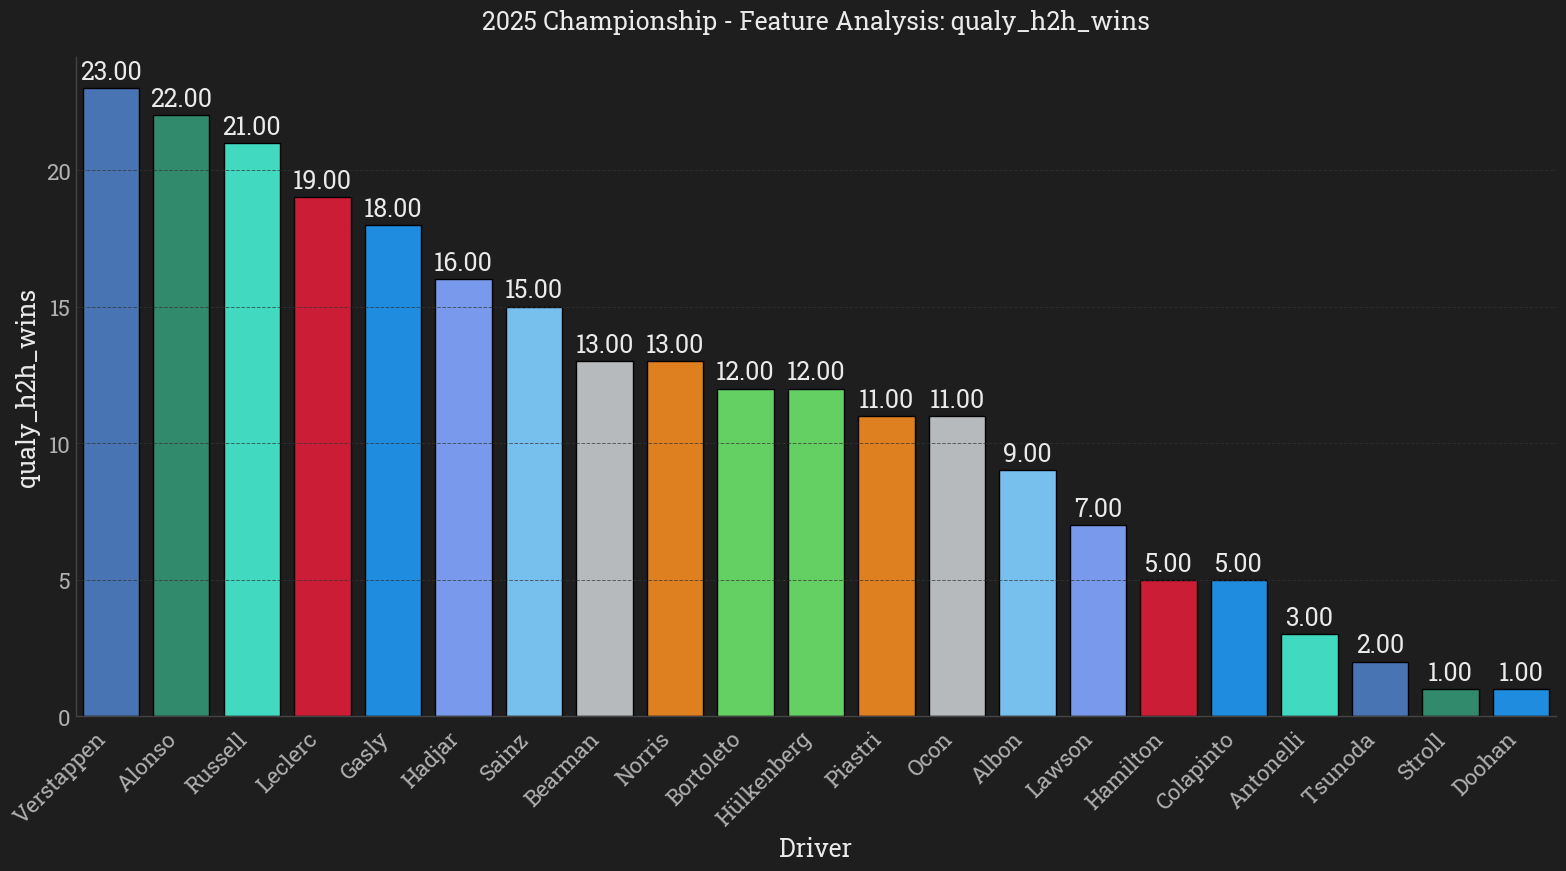

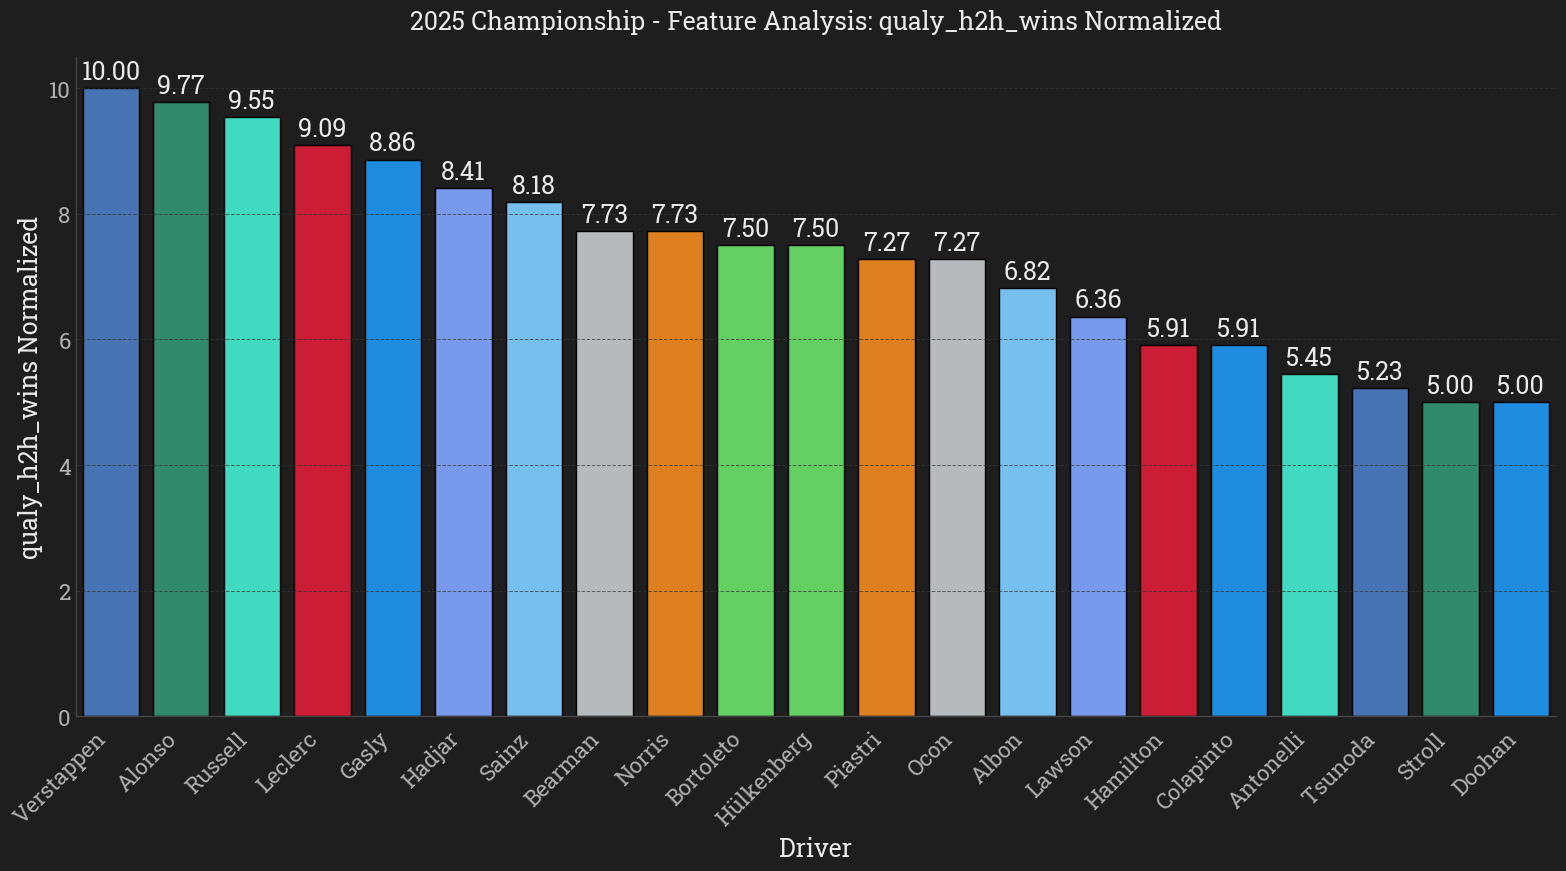

In [81]:
selected_feature = list_perf_features[feature_index]

df_perf = create_feature_norm_analysis(df_feature=df_perf, feature=selected_feature, lower_is_better=False)

feature_index += 1

Number of times a driver outperformed their teammates in qualifying.

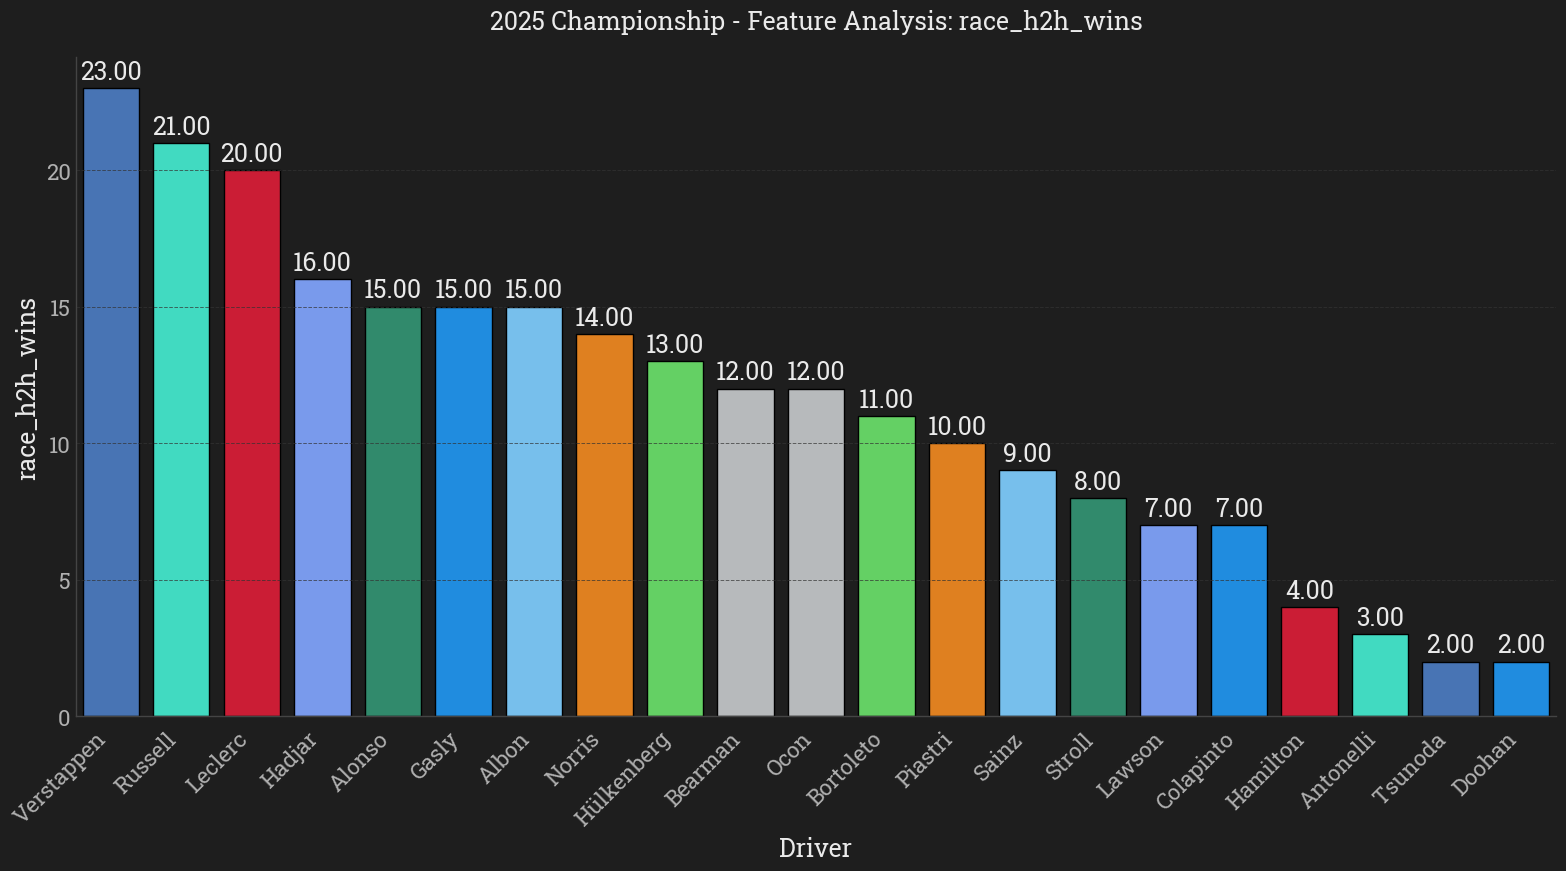

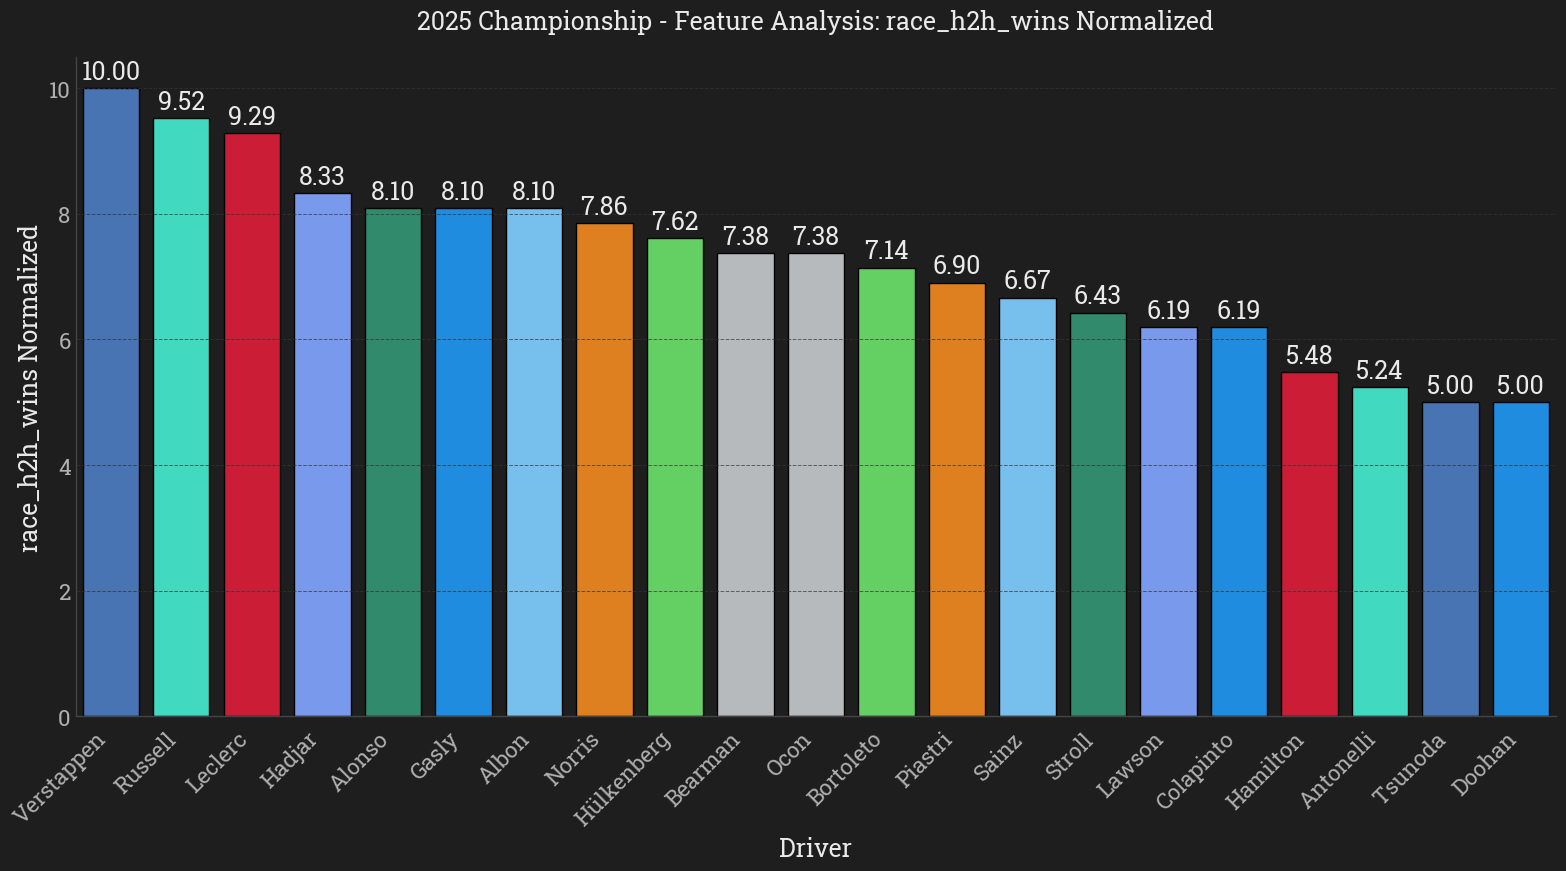

In [82]:
selected_feature = list_perf_features[feature_index]

df_perf = create_feature_norm_analysis(df_feature=df_perf, feature=selected_feature, lower_is_better=False)

feature_index += 1

Number of times a driver outperformed their teammates in main race event.

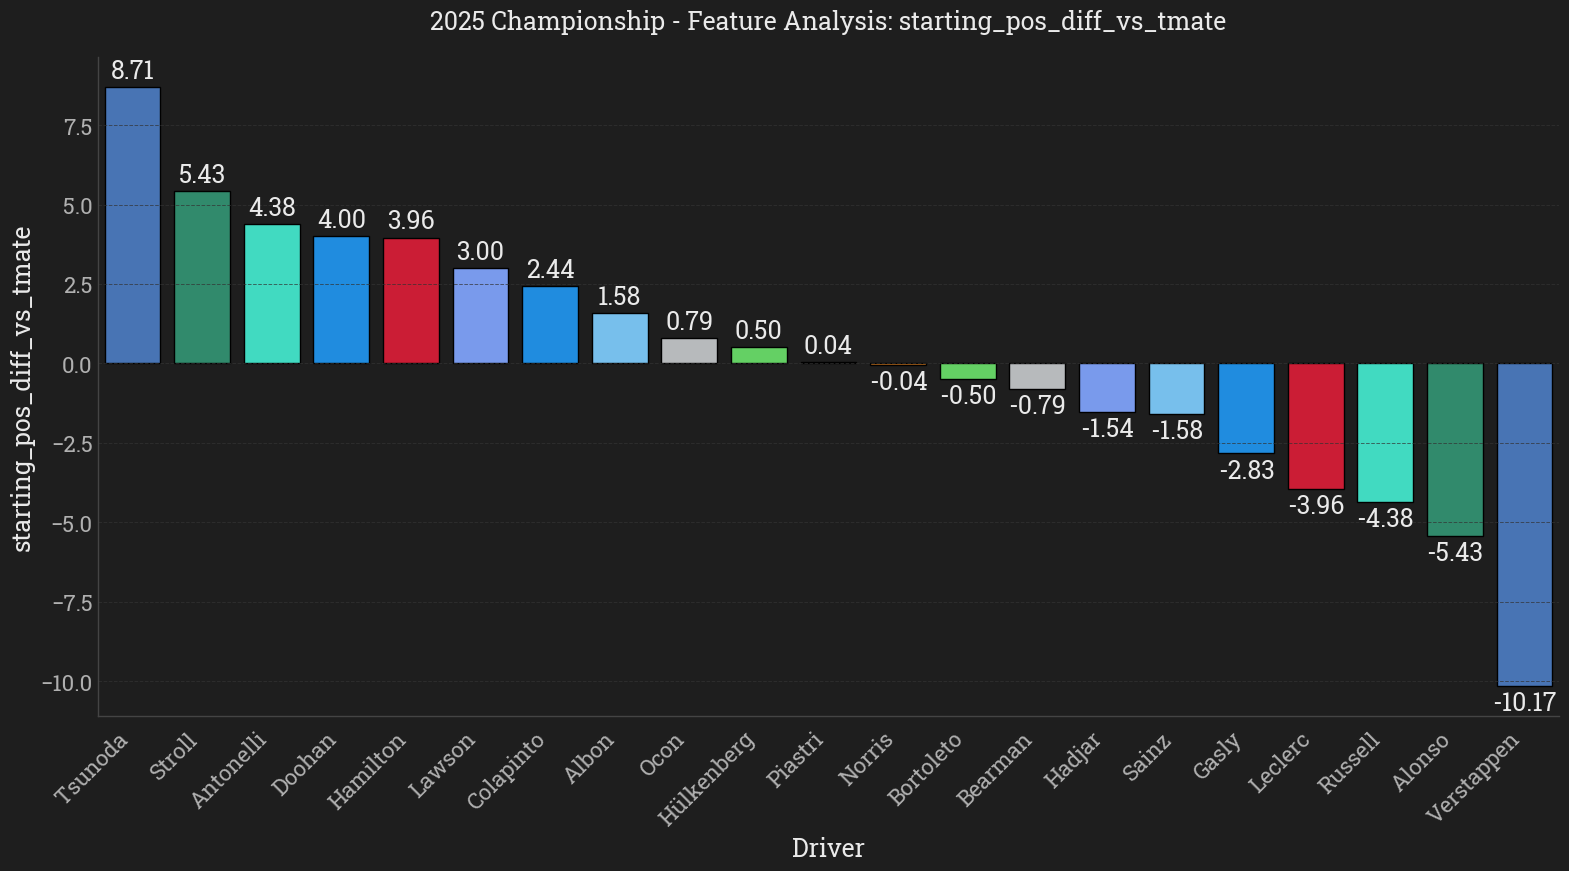

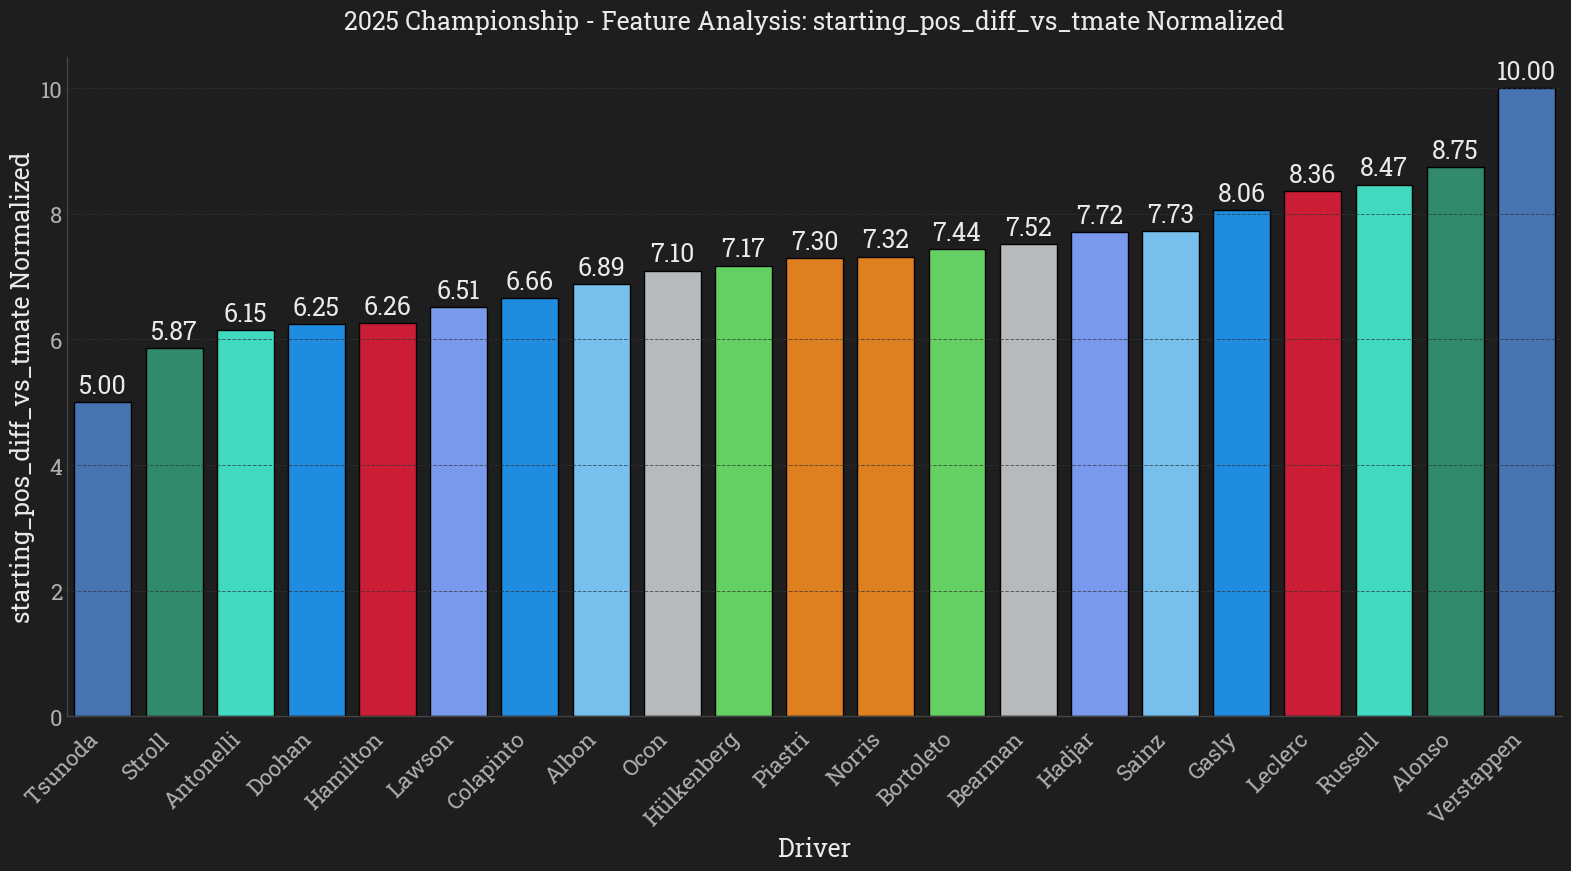

In [83]:
selected_feature = list_perf_features[feature_index]

df_perf = create_feature_norm_analysis(df_feature=df_perf, feature=selected_feature, lower_is_better=True)

feature_index += 1

This is the difference between starting position in each race. Is probably highly correlated (if not the same) with other features presented here. Will look into it in a bit.

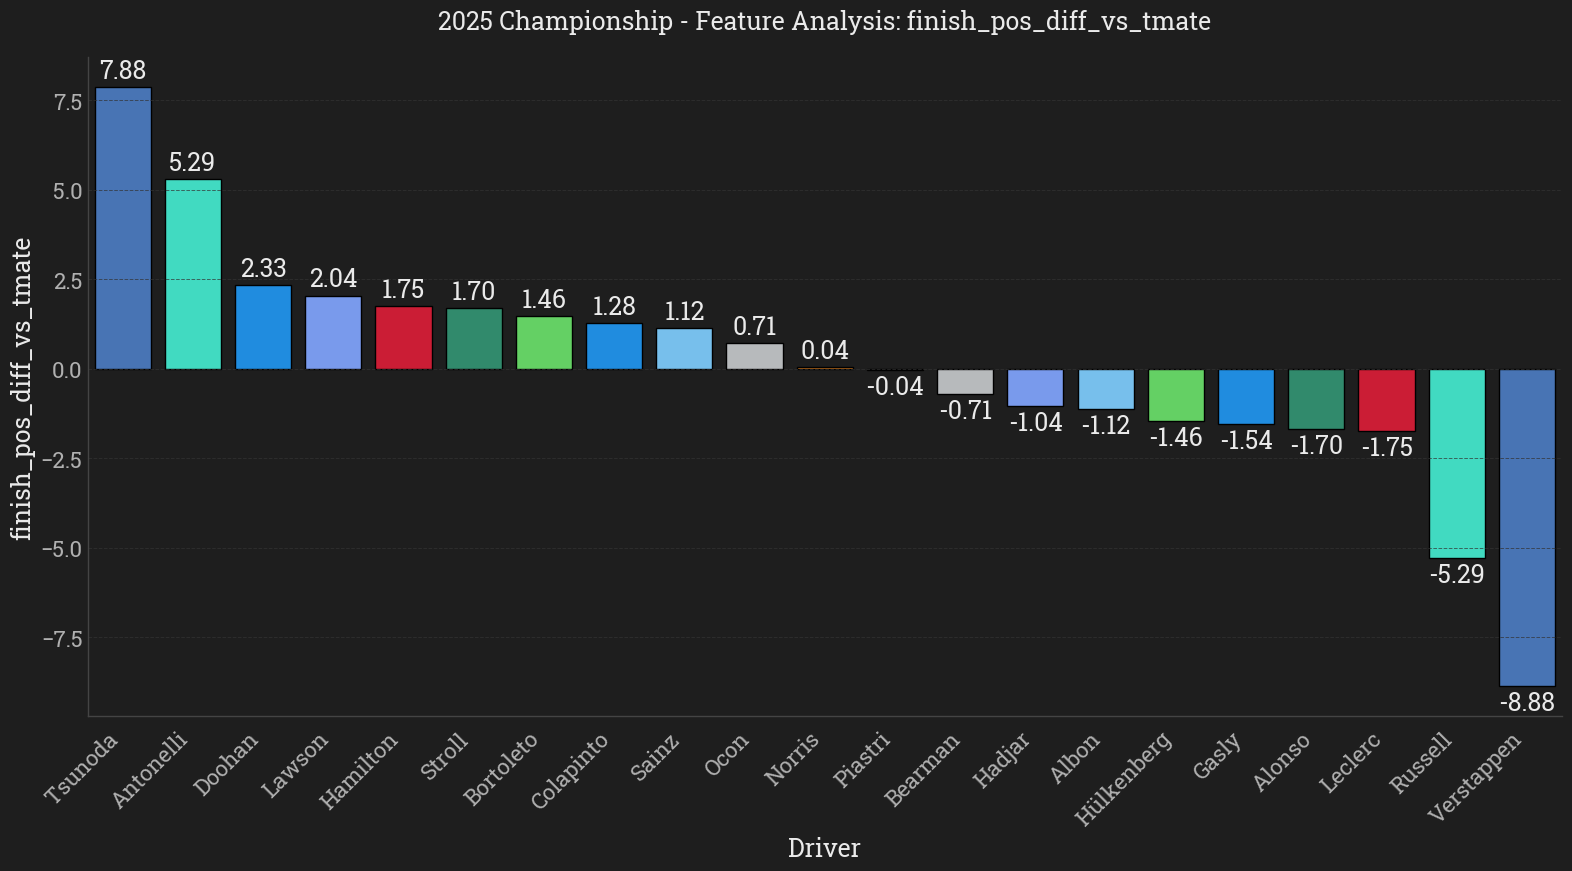

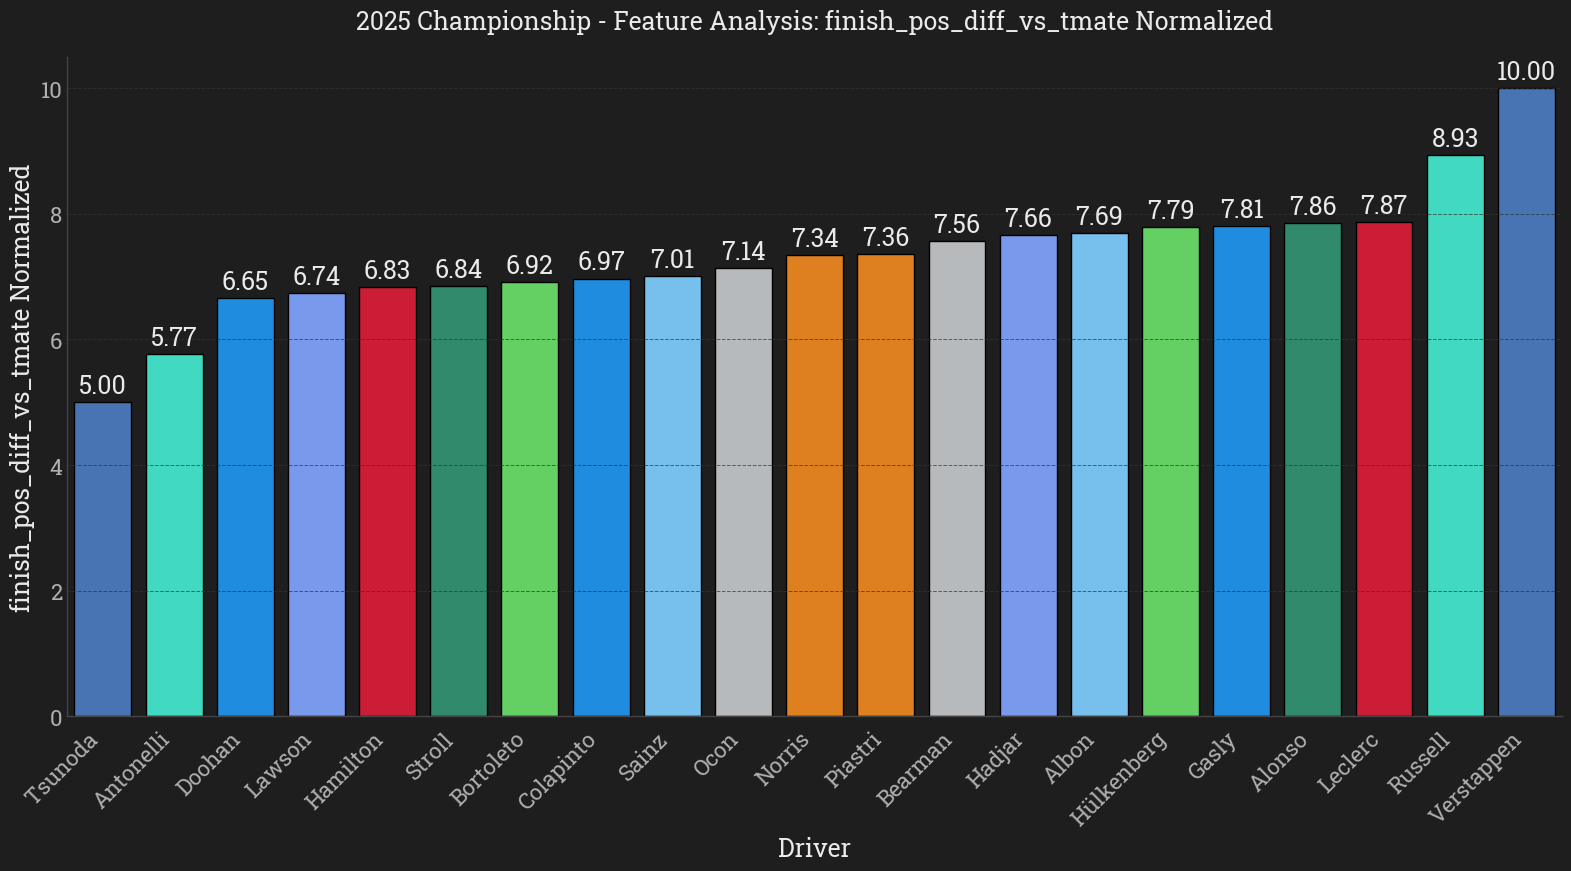

In [84]:
selected_feature = list_perf_features[feature_index]

df_perf = create_feature_norm_analysis(df_feature=df_perf, feature=selected_feature, lower_is_better=True)

feature_index += 1

Average difference between finishing position

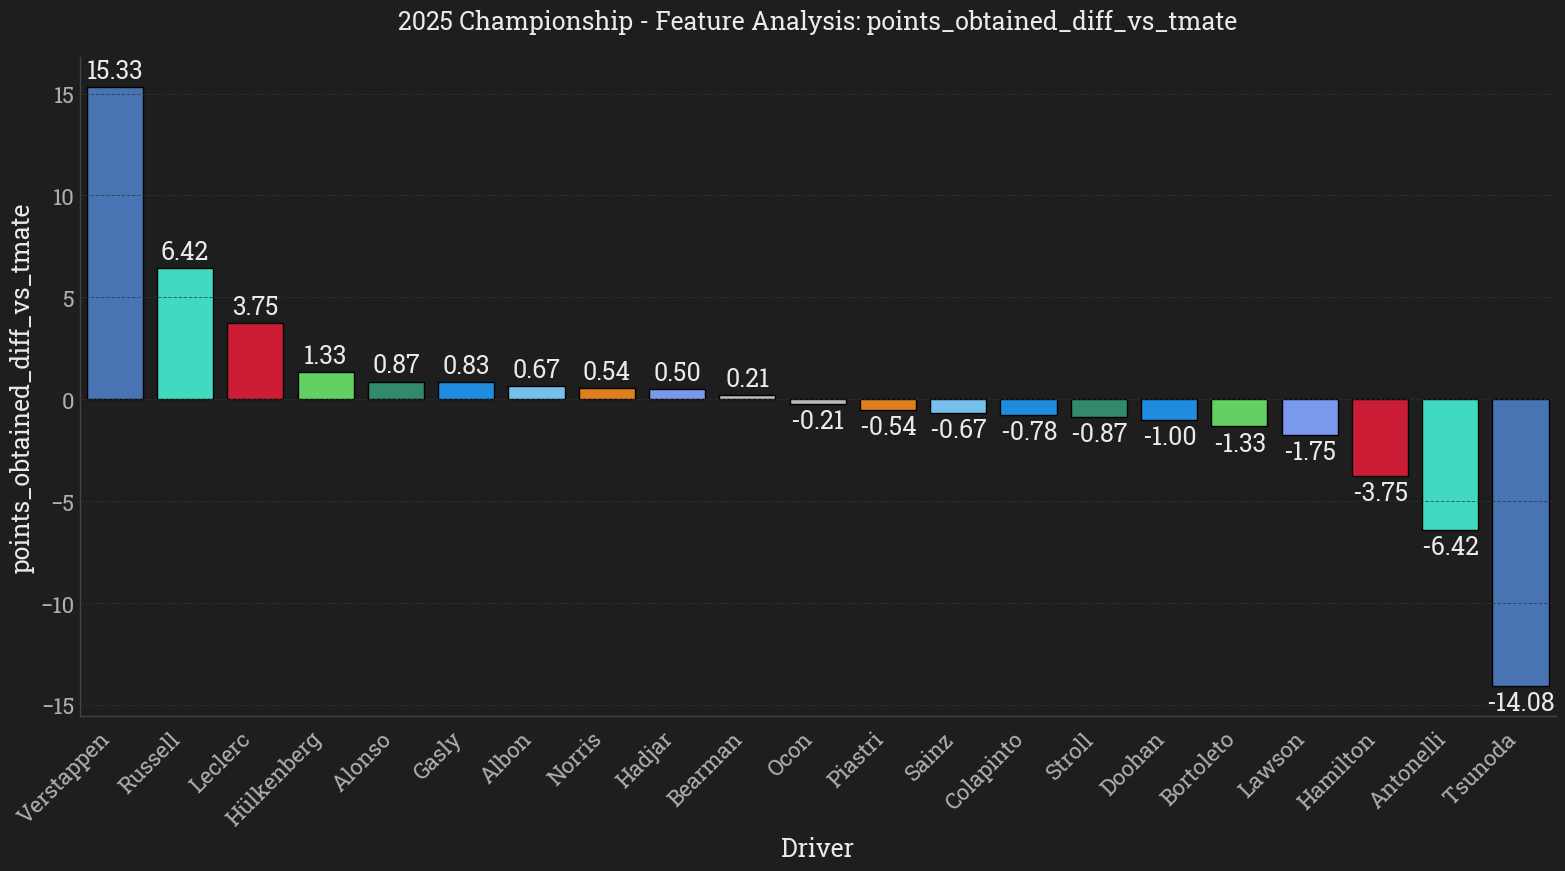

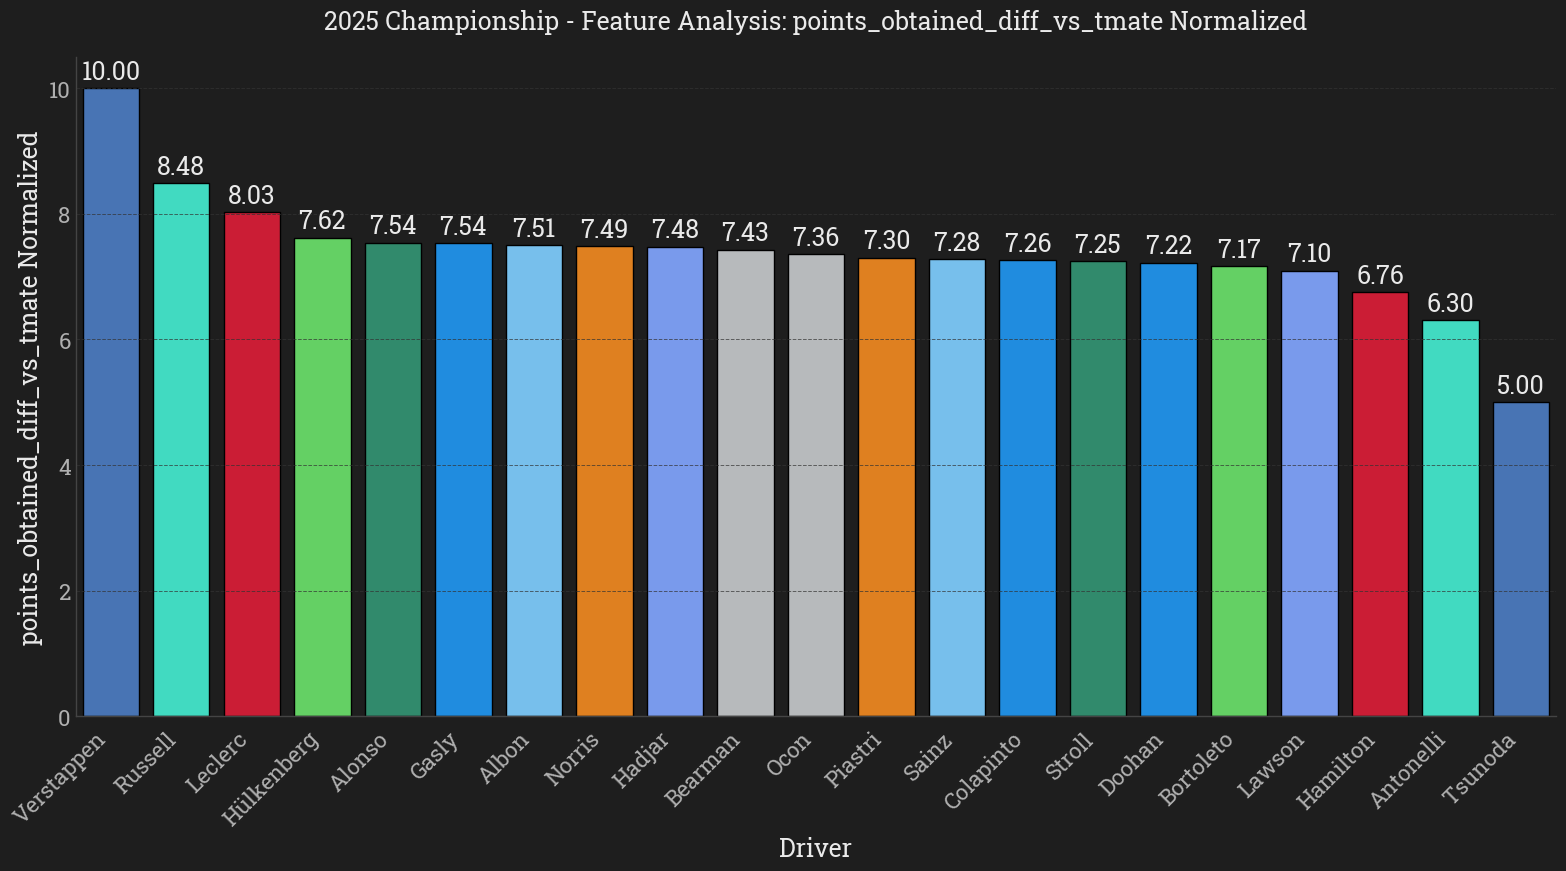

In [85]:
selected_feature = list_perf_features[feature_index]

df_perf = create_feature_norm_analysis(df_feature=df_perf, feature=selected_feature, lower_is_better=False)

feature_index += 1

Average difference between points obtained between teammates.

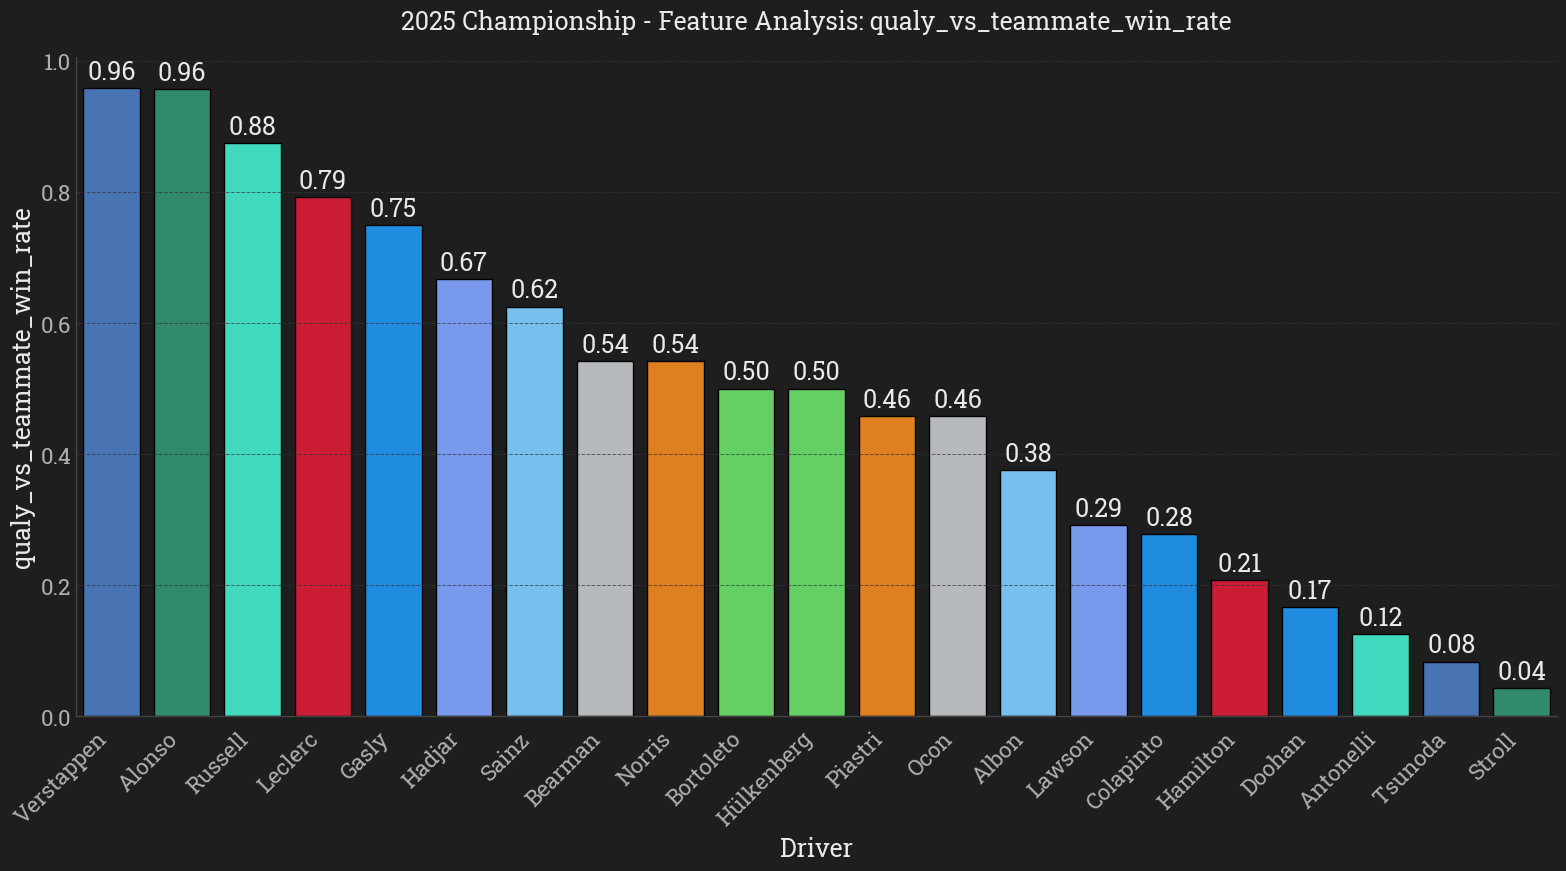

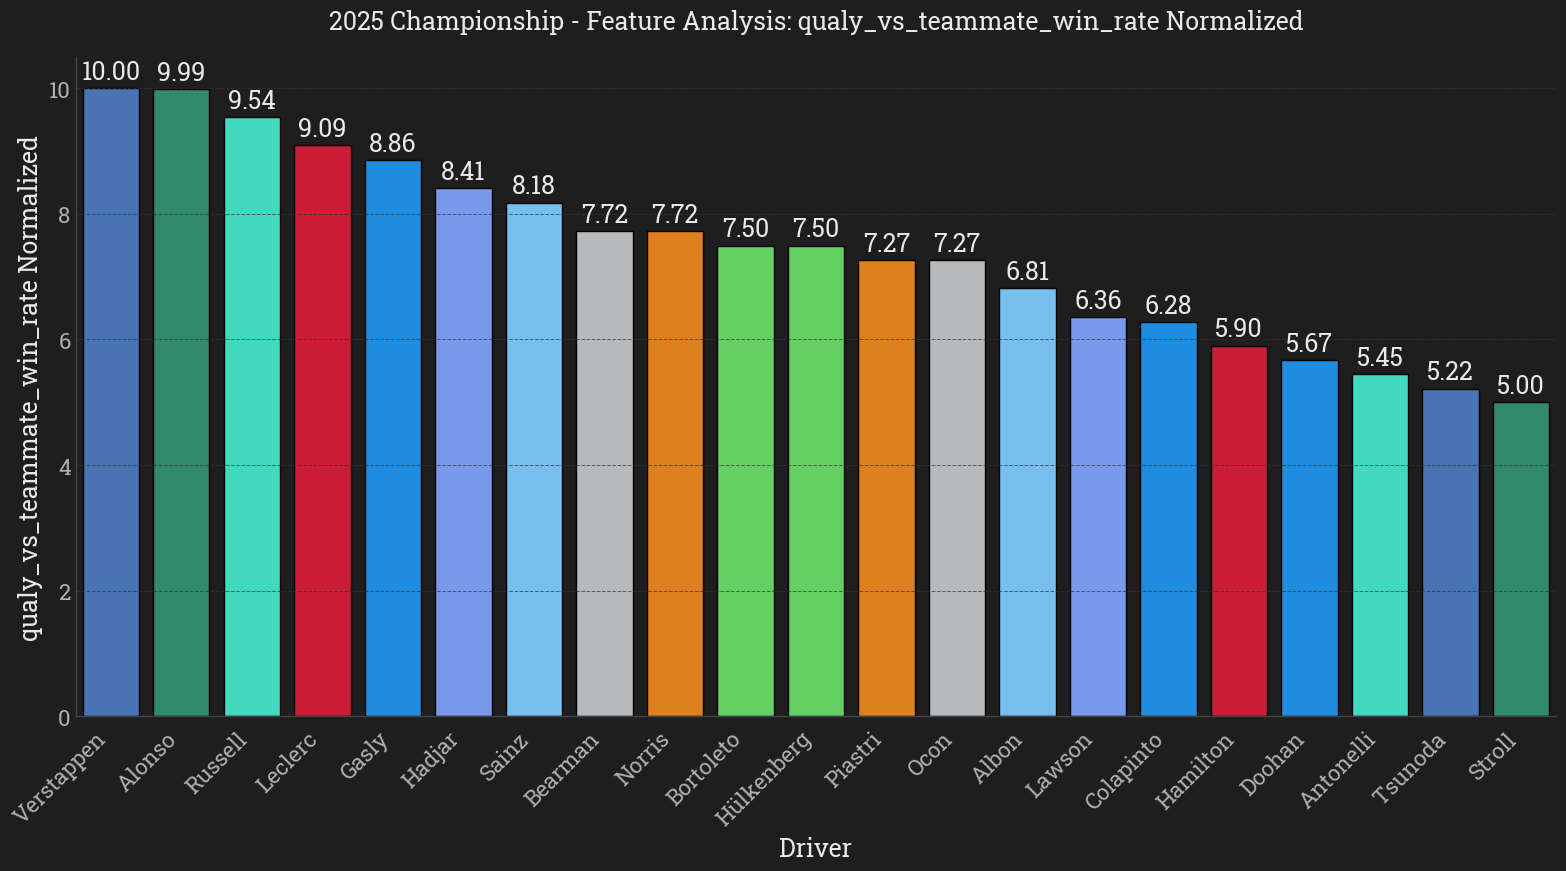

In [86]:
selected_feature = list_perf_features[feature_index]

df_perf = create_feature_norm_analysis(df_feature=df_perf, feature=selected_feature, lower_is_better=False)

feature_index += 1

Win rate for quali between teammates.

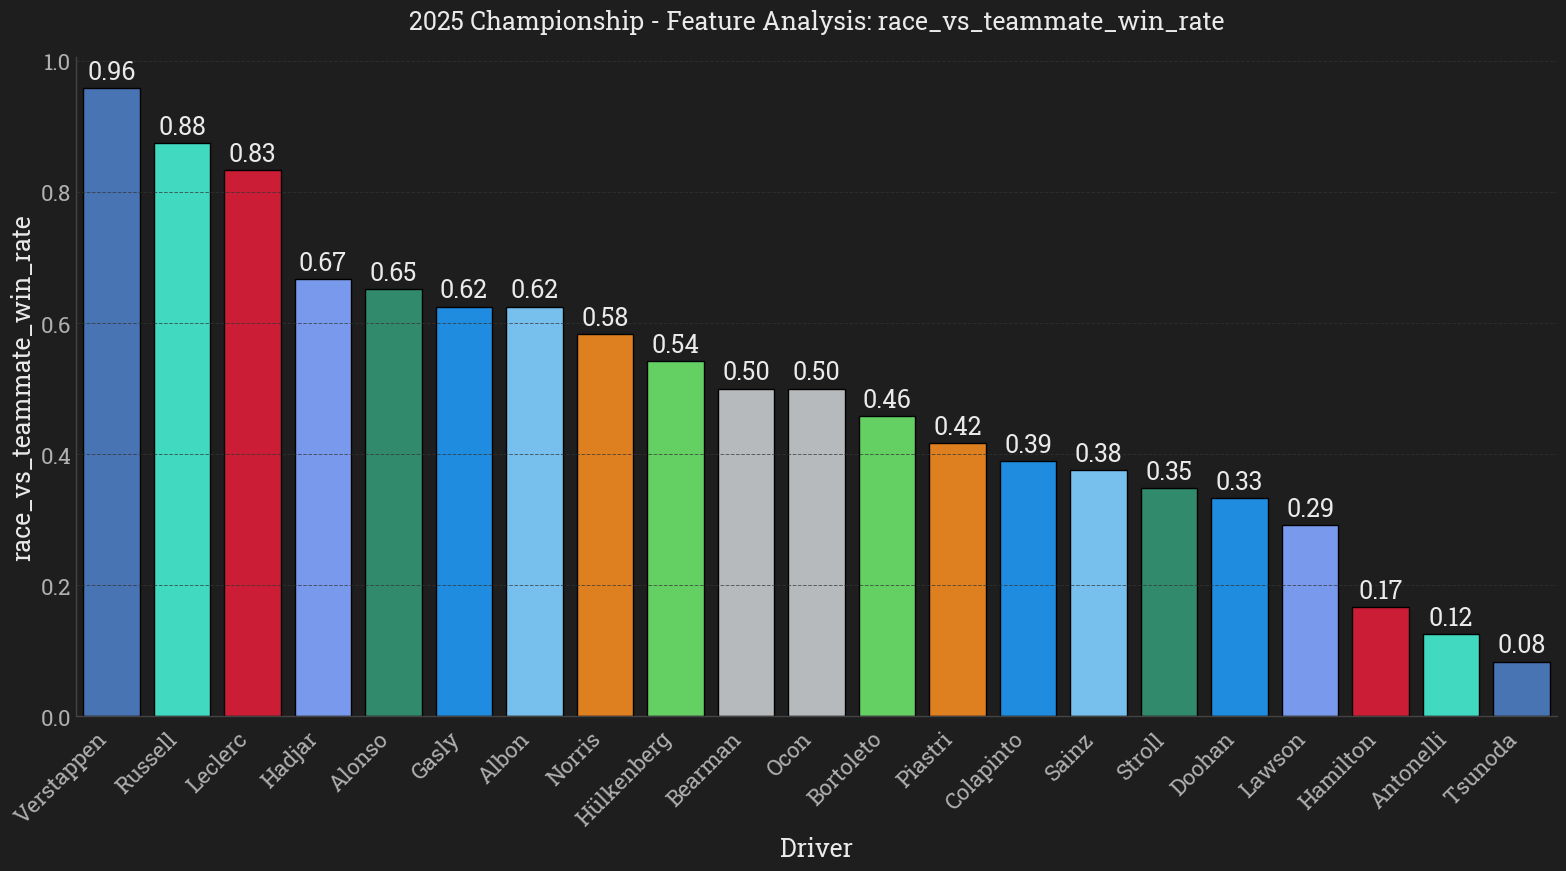

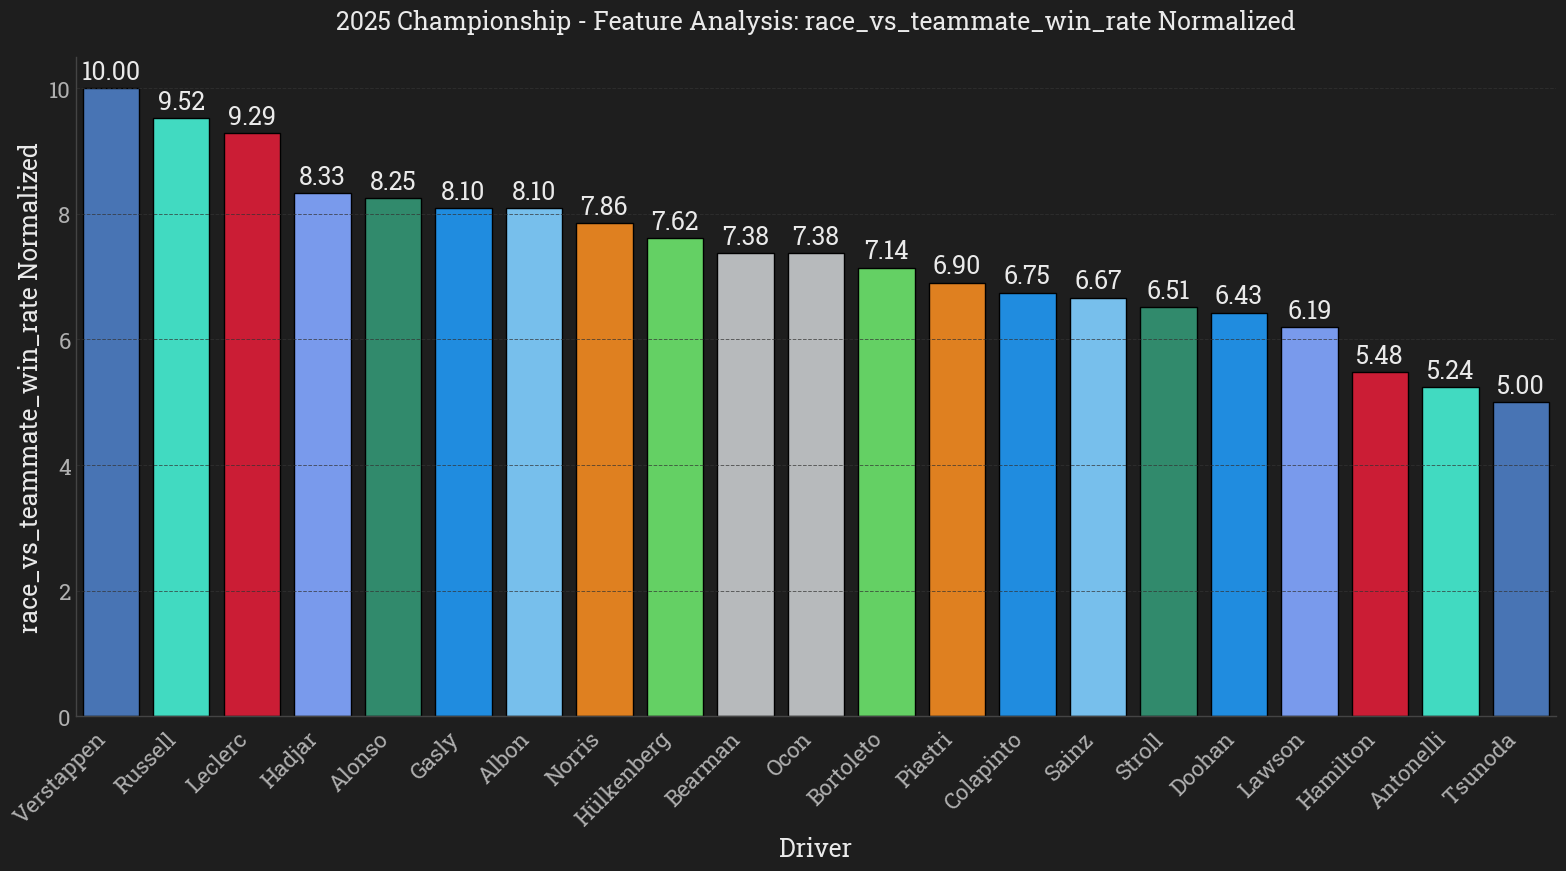

In [87]:
selected_feature = list_perf_features[feature_index]

df_perf = create_feature_norm_analysis(df_feature=df_perf, feature=selected_feature, lower_is_better=False)

feature_index += 1

Win rate for main race events between teammates

# Experience Features:

In [90]:
df_exp

driver_id  year       driver_full_name driver_surname constructor_name  \
2671        763  2025        Fernando Alonso         Alonso     Aston Martin   
2804        795  2025         Lewis Hamilton       Hamilton          Ferrari   
2877        807  2025        Nico Hülkenberg     Hülkenberg           Sauber   
2987        830  2025           Carlos Sainz          Sainz         Williams   
2998        831  2025         Max Verstappen     Verstappen         Red Bull   
3017        838  2025           Esteban Ocon           Ocon             Haas   
3030        840  2025           Lance Stroll         Stroll     Aston Martin   
3039        841  2025           Pierre Gasly          Gasly           Alpine   
3049        843  2025        Charles Leclerc        Leclerc          Ferrari   
3057        845  2025           Lando Norris         Norris          McLaren   
3063        846  2025        Alexander Albon          Albon         Williams   
3070        847  2025         George Russell        Russell         Mercedes   
3080        851  2025           Yuki Tsunoda        Tsunoda         Red Bull   
3093        857  2025          Oscar Piastri        Piastri          McLaren   
3096        858  2025            Liam Lawson         Lawson            VCARB   
3098        859  2025         Oliver Bearman        Bearman             Haas   
3100        860  2025       Franco Colapinto      Colapinto           Alpine   
3102        861  2025            Jack Doohan         Doohan           Alpine   
3103        862  2025      Gabriel Bortoleto      Bortoleto           Sauber   
3104        863  2025  Andrea Kimi Antonelli      Antonelli         Mercedes   
3105        864  2025           Isack Hadjar         Hadjar            VCARB   

      career_races  career_wins  career_podiums  career_poles  years_in_f1  
2671           428           32             106            22           22  
2804           380          105             202           104           19  
2877           254            0               1             1           14  
2987           232            4              29             6           11  
2998           233           71             127            48           11  
3017           180            1               4             0            9  
3030           191            0               3             1            9  
3039           178            1               5             0            9  
3049           173            8              50            27            8  
3057           152           11              44            16            7  
3063           129            0               2             0            6  
3070           152            5              24             8            7  
3080           114            0               0             0            5  
3093            70            9              26             6            3  
3096            35            0               0             0            3  
3098            27            0               0             0            2  
3100            27            0               0             0            2  
3102             7            0               0             0            2  
3103            24            0               0             0            1  
3104            24            0               3             0            1  
3105            24            0               1             0            1

Now we have a few more features created to show the driver experience. Let's take a look:

In [91]:
list_exp_features = nb_utils.get_features_column_list(df_exp)
list_exp_features

['career_races',
 'career_wins',
 'career_podiums',
 'career_poles',
 'years_in_f1']

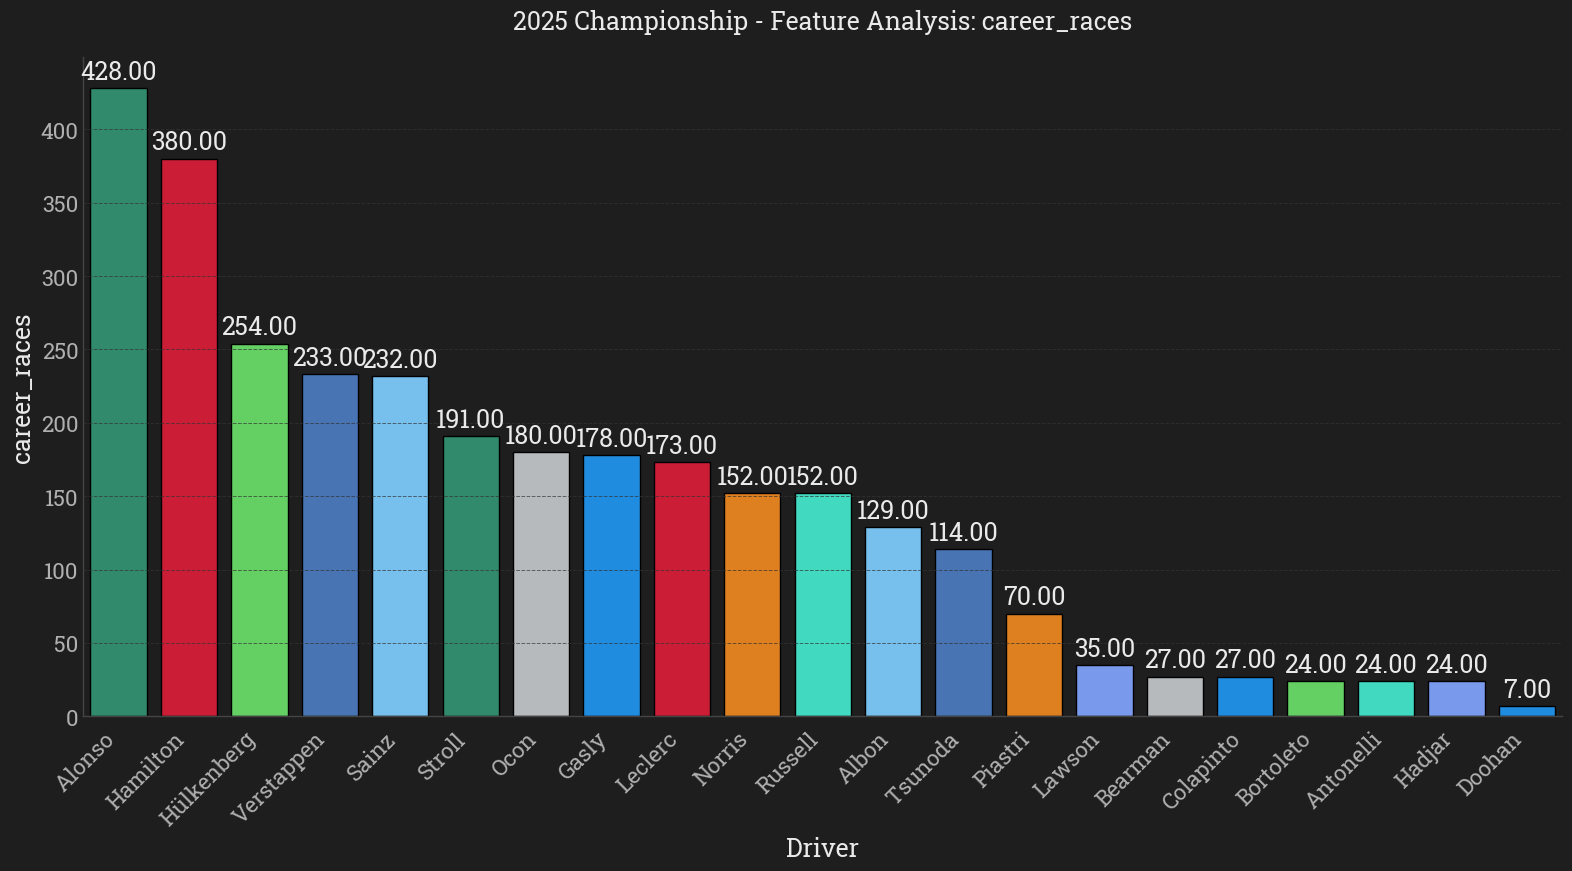

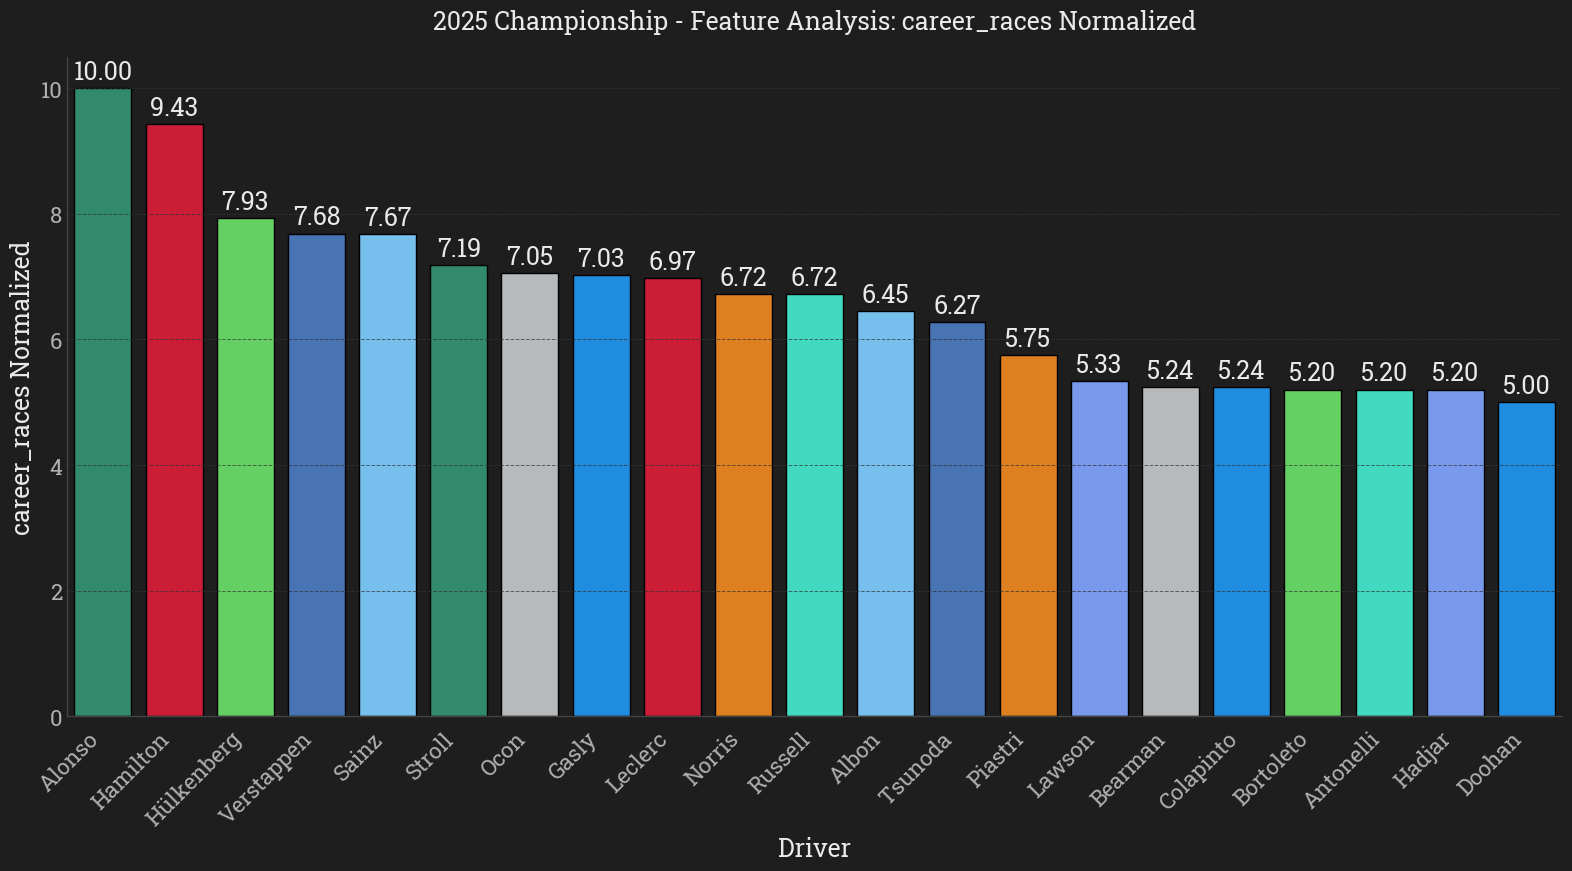

In [92]:
feature_index = 0

selected_feature = list_exp_features[feature_index]

df_exp = create_feature_norm_analysis(df_feature=df_exp, feature=selected_feature, lower_is_better=False)

feature_index += 1

Number of races entered.

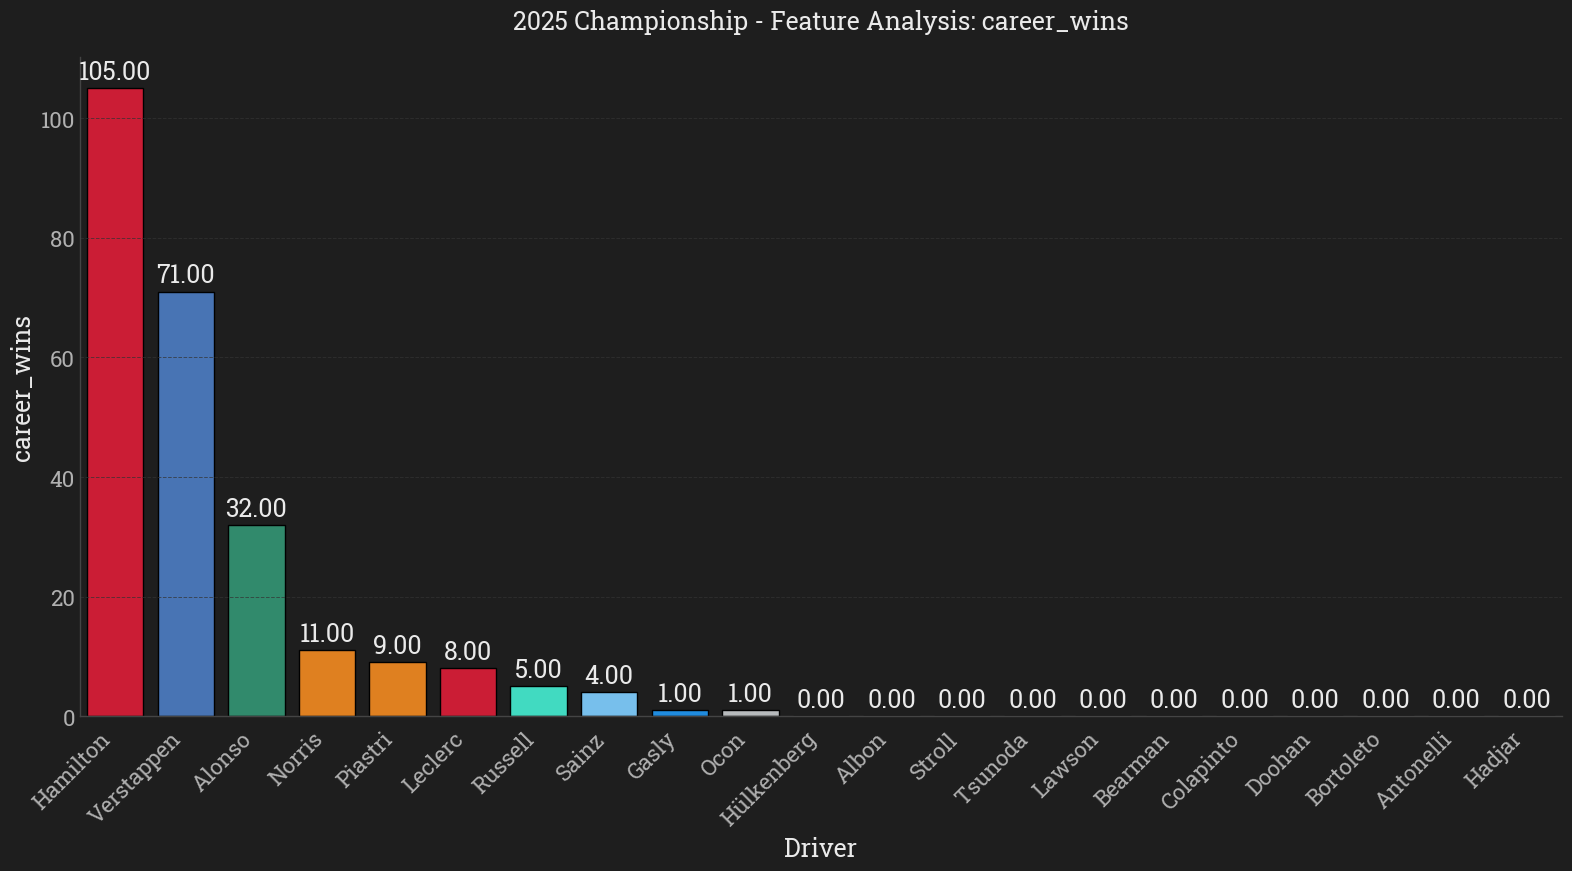

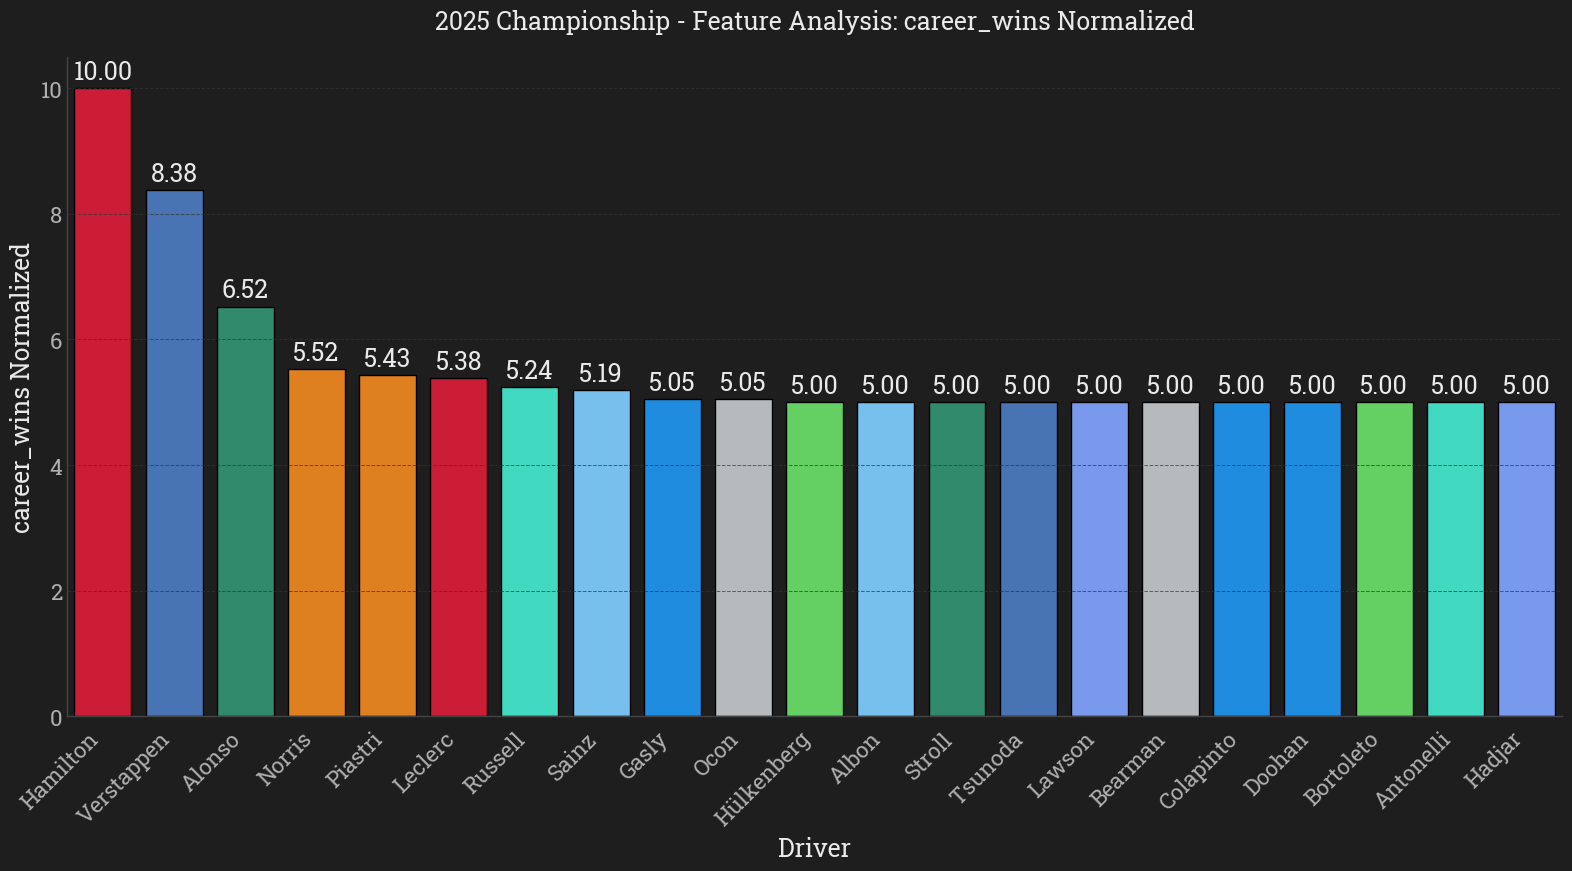

In [93]:
selected_feature = list_exp_features[feature_index]

df_exp = create_feature_norm_analysis(df_feature=df_exp, feature=selected_feature, lower_is_better=False)

feature_index += 1

Number of career wins

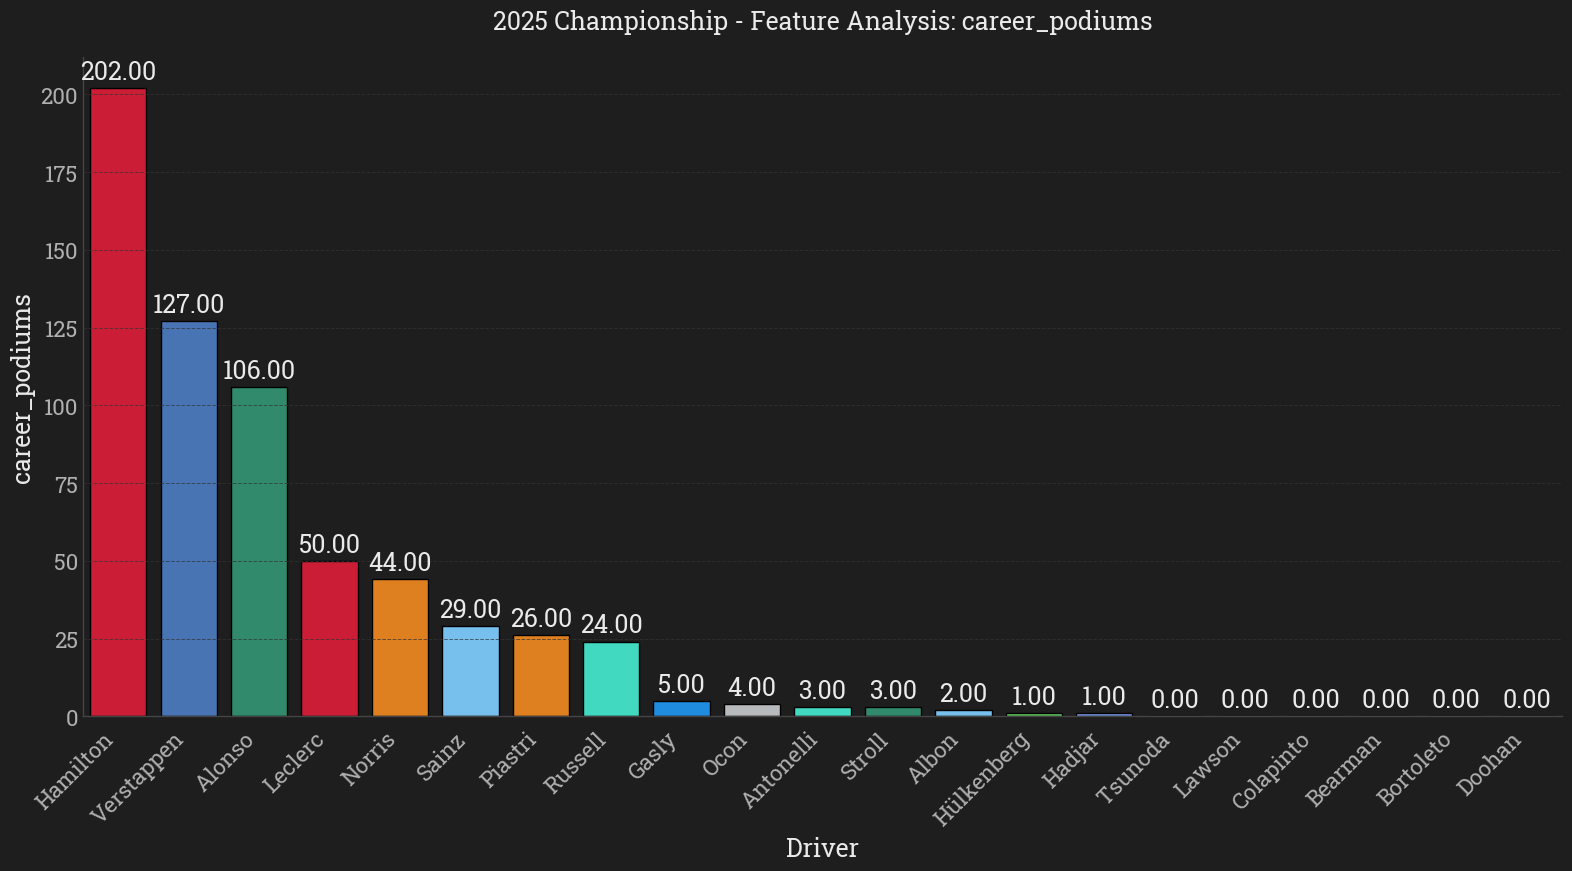

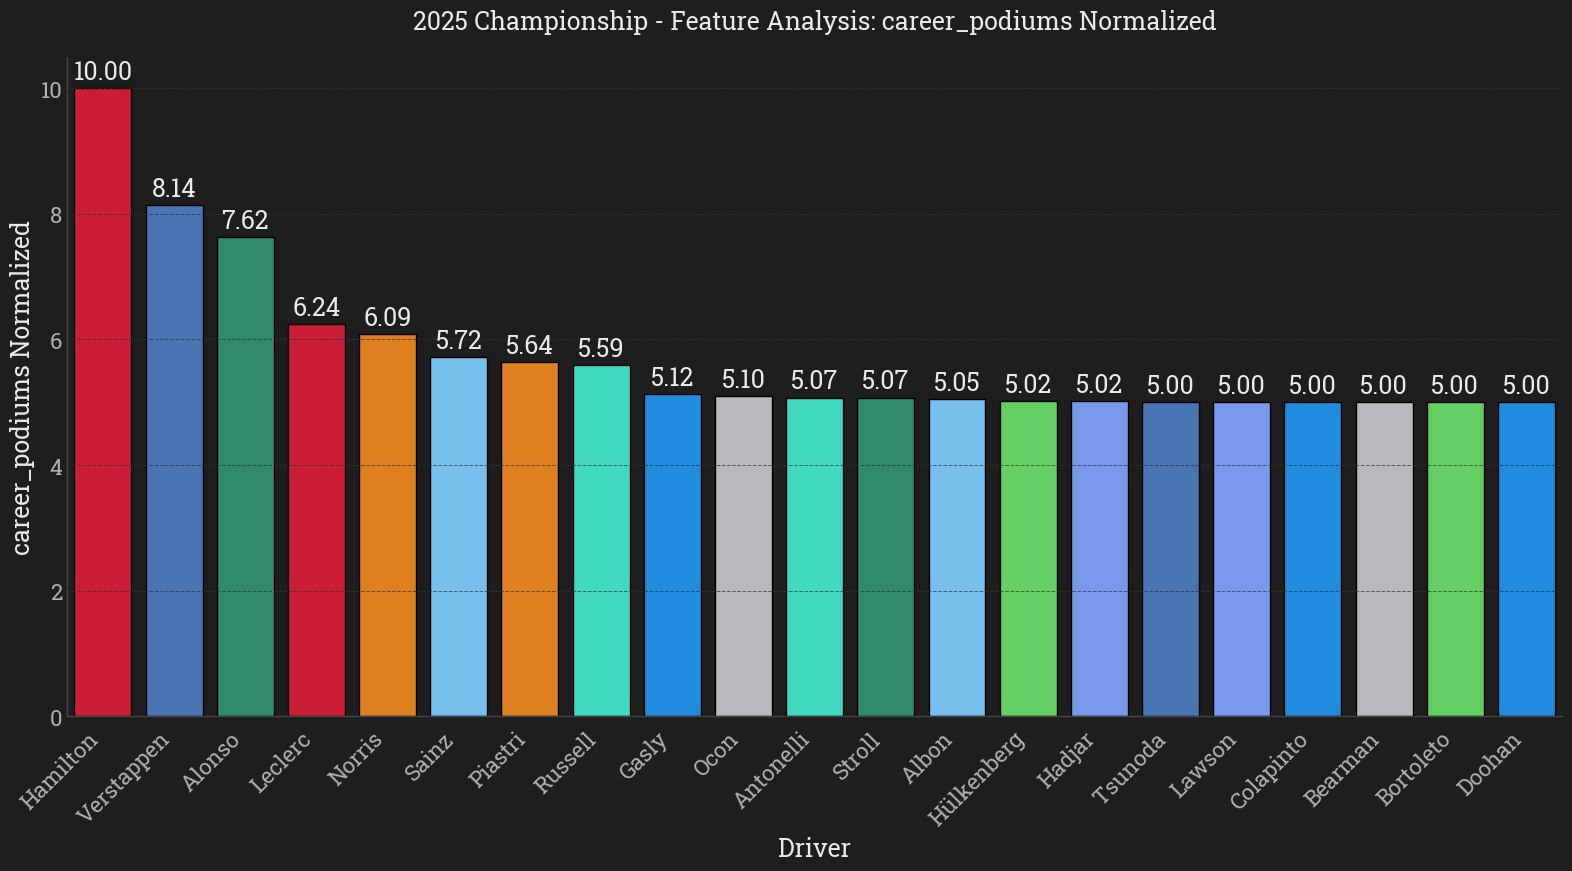

In [95]:
selected_feature = list_exp_features[feature_index]

df_exp = create_feature_norm_analysis(df_feature=df_exp, feature=selected_feature, lower_is_better=False)

feature_index += 1

Number of career podiums

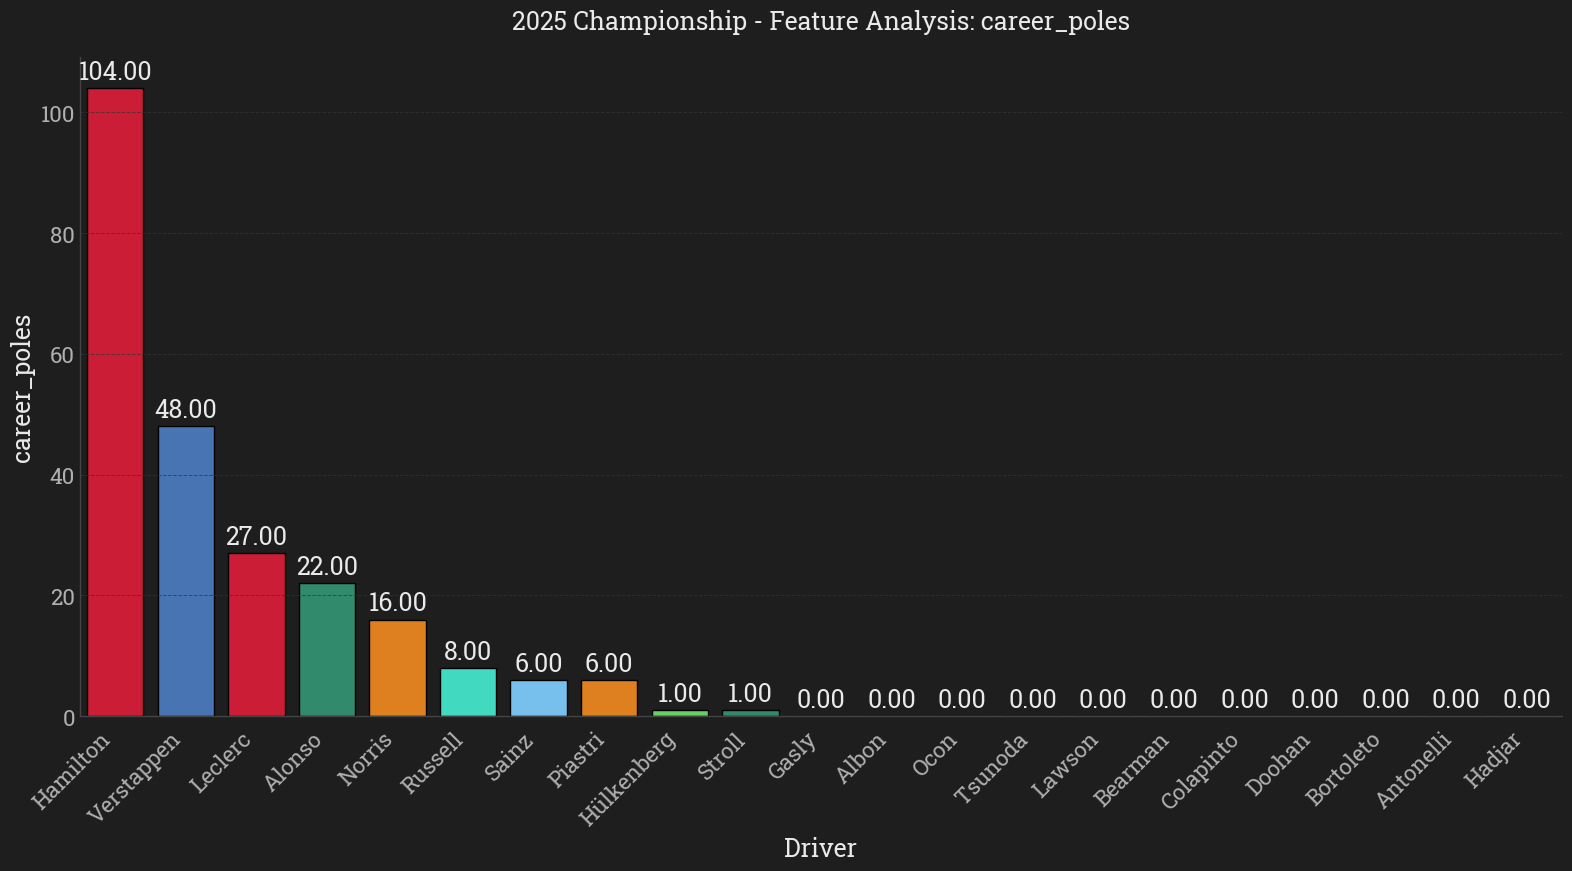

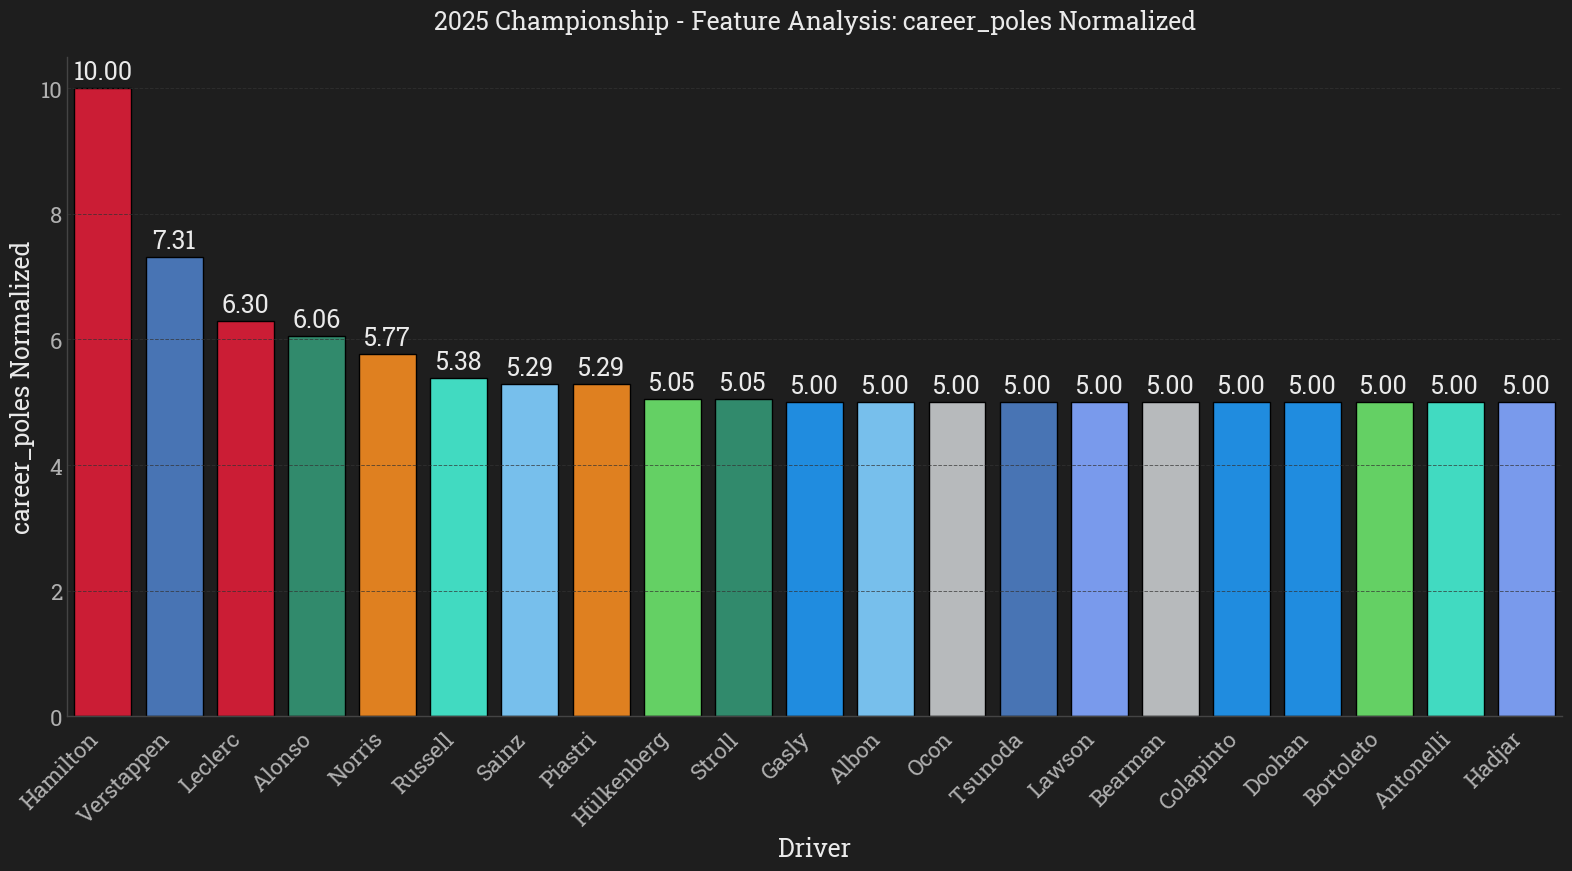

In [96]:
selected_feature = list_exp_features[feature_index]

df_exp = create_feature_norm_analysis(df_feature=df_exp, feature=selected_feature, lower_is_better=False)

feature_index += 1

Number of career poles.

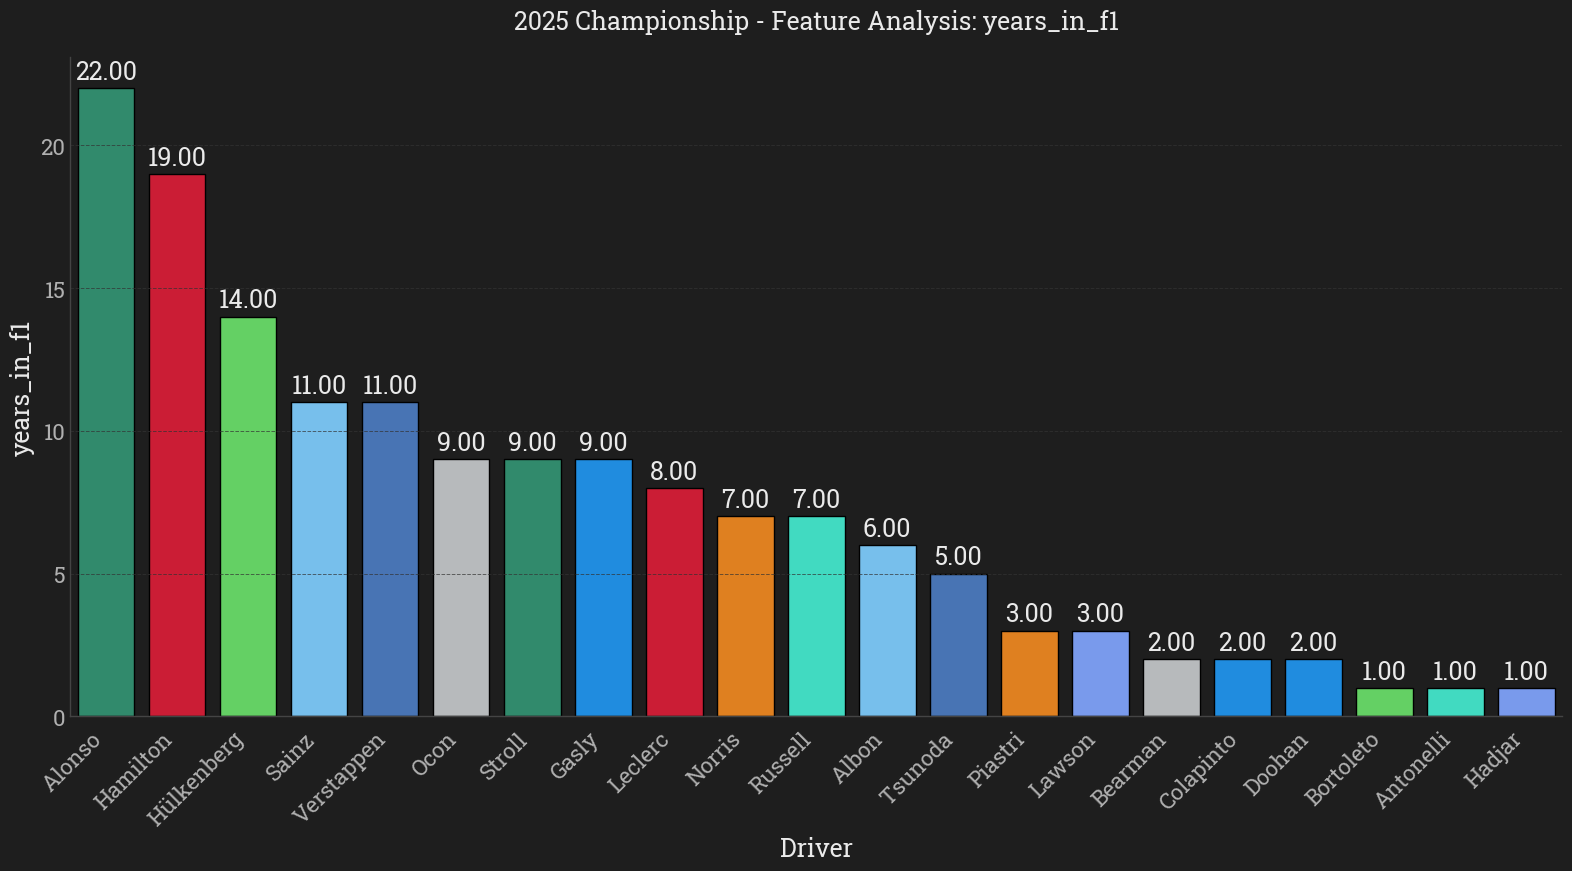

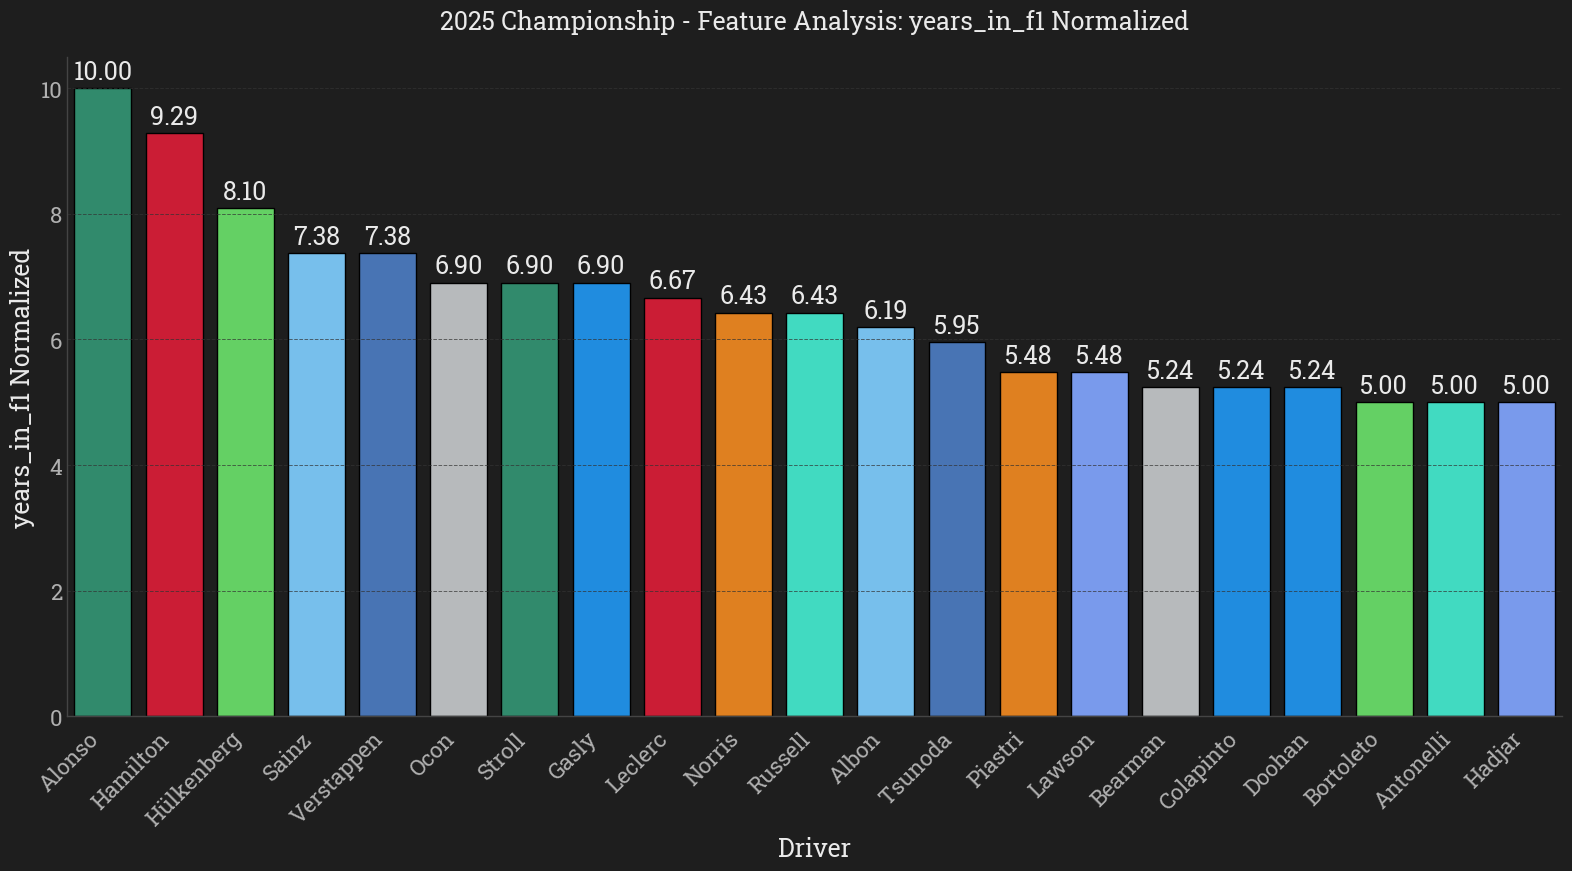

In [97]:
selected_feature = list_exp_features[feature_index]

df_exp = create_feature_norm_analysis(df_feature=df_exp, feature=selected_feature, lower_is_better=False)

feature_index += 1

Number of years competed in F1.

# Creating the scores

Ok, now that we have taken a look at all the features, making sure they make sense and also understanding each one of them. I will work on creating a score for each one of them. Using a mapping to create the weight of each feature and I will explain the logic along the way...

## Weights

Before starting the final score for each kind of feature, we need to define the weights for each feature.

I did this in a compoletely subjective way, based on my knowledge of the sport and the features I selected and how I feel each of them should be representative of the final score (for each feature category). I usually attributed more weight to features that compare teammates directly, as I believe this is a better indicator of the driver's performance since, as a premise of this analysis, I consider that drivers in the same team have access to the same resources and equipment.

After calculating the score for each category of feature, I will create a final weight for each one of this final scores, combining them into one final score for each driver. But I will dive deeper into this after presenting the score for each driver in each category.

First let's load the weights for each feature and I will present them below, they range from 1 to 4.

In [106]:
file_path = 'notebooks/f1_2025_data_rankings/feature_weights.xlsx'

df_weight_pace = pd.read_excel(file_path, sheet_name='pace')
df_weight_perf = pd.read_excel(file_path, sheet_name='perf')
df_weight_exp = pd.read_excel(file_path, sheet_name='exp')

In [107]:
df_weight_pace

column  weight
0                   avg_pace_vs_field_norm       2
1                avg_pace_vs_teammate_norm       4
2       avg_lap_time_std_dev_vs_field_norm       2
3    avg_lap_time_std_dev_vs_teammate_norm       4
4            avg_raw_lap_time_std_dev_norm       2
5      avg_qualifying_gap_to_pole_pct_norm       2
6  avg_qualifying_gap_to_teammate_pct_norm       4

The idea above is to give the *H2H* ones double the weight of the *VS. Pace* ones.

In [108]:
df_weight_perf

column  weight
0                    total_points_norm       1
1                  avg_finish_pos_norm       1
2                    avg_grid_pos_norm       1
3            avg_positions_gained_norm       3
4                 points_per_race_norm       1
5               team_points_share_norm       3
6                  qualy_h2h_wins_norm       3
7                   race_h2h_wins_norm       4
8      starting_pos_diff_vs_tmate_norm       3
9        finish_pos_diff_vs_tmate_norm       4
10  points_obtained_diff_vs_tmate_norm       3
11     qualy_vs_teammate_win_rate_norm       3
12      race_vs_teammate_win_rate_norm       4

The idea here is to keep the influence of the more "absolute value" features, but not by much, as I think those are merit of the driver but much more a merit of the team.

Apllied more weight to the teammate relative features, as I think those are more merit of the driver, as well as for the *avg_positions_gained_norm* feature because I think this is also a good representation of the driver's hability on track.

In [109]:
df_weight_exp

column  weight
0    career_races_norm       4
1     career_wins_norm       2
2  career_podiums_norm       3
3    career_poles_norm       3
4     years_in_f1_norm       3

And, now, for the experience features, there is really not that much to it, they are pretty self explanatory and the one I'm valuing the most is the number of races. I reduced the weight of the number of wins by a bit because I think this is highly dependent on the team that the driver was/is on.

## Pace Score:

In [110]:
df_pace

driver_id  year       driver_full_name driver_surname constructor_name  \
332        763  2025        Fernando Alonso         Alonso     Aston Martin   
460        795  2025         Lewis Hamilton       Hamilton          Ferrari   
528        807  2025        Nico Hülkenberg     Hülkenberg           Sauber   
632        830  2025           Carlos Sainz          Sainz         Williams   
643        831  2025         Max Verstappen     Verstappen         Red Bull   
661        838  2025           Esteban Ocon           Ocon             Haas   
673        840  2025           Lance Stroll         Stroll     Aston Martin   
682        841  2025           Pierre Gasly          Gasly           Alpine   
692        843  2025        Charles Leclerc        Leclerc          Ferrari   
700        845  2025           Lando Norris         Norris          McLaren   
706        846  2025        Alexander Albon          Albon         Williams   
713        847  2025         George Russell        Russell         Mercedes   
721        851  2025           Yuki Tsunoda        Tsunoda         Red Bull   
733        857  2025          Oscar Piastri        Piastri          McLaren   
736        858  2025            Liam Lawson         Lawson            VCARB   
737        859  2025         Oliver Bearman        Bearman             Haas   
739        860  2025       Franco Colapinto      Colapinto           Alpine   
740        861  2025            Jack Doohan         Doohan           Alpine   
741        862  2025      Gabriel Bortoleto      Bortoleto           Sauber   
742        863  2025  Andrea Kimi Antonelli      Antonelli         Mercedes   
743        864  2025           Isack Hadjar         Hadjar            VCARB   

     avg_pace_vs_field  avg_pace_vs_teammate  avg_lap_time_std_dev_vs_field  \
332           1.001067              0.996977                       1.132184   
460           0.994950              1.004095                       0.920399   
528           1.004016              0.999390                       1.163217   
632           1.001073              1.002047                       0.930246   
643           0.989197              0.986488                       0.870101   
661           1.003274              1.001039                       1.036349   
673           1.004111              1.003052                       1.152193   
682           1.005062              0.999293                       1.069933   
692           0.990911              0.995954                       0.836841   
700           0.986219              0.999705                       0.857730   
706           0.999037              0.997988                       1.060487   
713           0.993418              0.996992                       0.824542   
721           1.002775              1.013794                       0.984863   
733           0.986521              1.000307                       0.858410   
736           1.002187              1.001558                       1.068566   
737           1.002249              0.998995                       1.208730   
739           1.006296              1.000252                       1.159259   
740           1.001739              1.004600                       1.265951   
741           1.004640              1.000636                       1.041961   
742           0.996432              1.003038                       0.933710   
743           1.000653              0.998489                       1.113047   

     avg_lap_time_std_dev_vs_teammate  avg_raw_lap_time_std_dev  \
332                          1.043929               1264.869173   
460                          1.153122               1082.251872   
528                          1.306893                983.630713   
632                          0.911361               1005.424836   
643                          1.012703               1047.093856   
661                          0.933262               1177.592150   
673                          1.060781               1146.9